In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve
from math import pi, exp, log10, sqrt, log
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [3]:
class FirstOrderForward:
    
    # constant parameters used in computing
    _c1 =  1.211243
    _c2 = -0.08972168
    _c3 =  0.001384277
    _c4 = -0.00176566
    _c5 =  0.0001186795
    
    # model parameters
    _pmodel = None
    _vpmodel = None
    _vsmodel = None
    _c11 = None   # = c33 = λ+ 2μ
    _c13 = None   # = λ
    _c44 = None   # = μ
    _vx = None
    _vx = None
    _dt = 0
    _dx = 0
    _dz = 0
    _nt = 0
    _nx = 0
    _nz = 0
    _tmax = 0
    _xmax = 0
    _zmax = 0
    
    def __init__(self, pmodel=None, vpmodel=None, vsmodel=None, tmax=1., xmax=1000., zmax=800., nt=1000, nx=100, nz=80):
        # if not setting model parameter, using a easy model to test

        self._pmodel = pmodel
        self._vpmodel = vpmodel
        self._vsmodel = vsmodel
        # setting other parameters     
        self._tmax = tmax
        self._xmax = xmax
        self._zmax = zmax
        self._nt = nt
        self._nx = nx
        self._nz = nz
        
        # computing some parameters
        self._dt = tmax/nt
        self._dx = xmax/nx
        self._dz = zmax/nz
        
        self._c11 = self._pmodel * np.power(self._vpmodel, 2)
        self._c44 = self._pmodel * np.power(self._vsmodel, 2)
        self._c13 = self._c11 - 2 * self._c44
        
        # initialize the u
        self._vx = np.zeros((nx, nz, nt), dtype=float)
        self._vz = np.zeros((nx, nz, nt), dtype=float)

    # forward modeling operator with precion of O(4,10)
    def o4xFM(self, wavelet, wavalet_position, wavalet_direction='z'):
        # setting time array
        t_array = np.arange(0, self._tmax, self._dt)
        
        # initialize parameter used in process
        u = np.zeros((self._nx, self._nz), dtype=float)
        v = np.zeros((self._nx, self._nz), dtype=float)
        r = np.zeros((self._nx, self._nz), dtype=float)
        t = np.zeros((self._nx, self._nz), dtype=float)
        h = np.zeros((self._nx, self._nz), dtype=float)
        
        # start to compute
        for tk, tt in enumerate(t_array):
            if tk >= 1:  # the first step needs not to compute
                u = self.o4xComputeVx(u, v, r, t, h)
                v = self.o4xComputeVz(u, v, r, t, h)
                r = self.o4xComputeTauxx(u ,v, r, t, h)
                t = self.o4xComputeTauzz(u ,v, r, t, h)
                h = self.o4xComputeTauxz(u ,v, r, t, h)
                
                if tk < len(wavelet):  # source is active
                    if wavalet_direction=='x':
                        u[wavalet_position[0], wavalet_position[1]] += wavelet[tk]
                    else:
                        v[wavalet_position[0], wavalet_position[1]] += wavelet[tk]
                
                self._vx[:,:,tk] = u
                self._vz[:,:,tk] = v
      
    # function to oompute the velocity in x axis of the next time step
    def o4xComputeVx(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        # compute the 1st item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[5,:] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        one = self._dt / (self._dx * self._pmodel * 2) * convolve(r, kernal, mode='same')
        
        # compute the 2nd item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[:,5] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[5,:] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        two = self._dt / (self._dz * self._pmodel * 2) * convolve(h, kernal, mode='same')
        
        # compute the 3rd item
        kernal = np.zeros((5, 5), dtype=float)
        # kernal[2,:] = [-1, 3, -3, 1, 0]
        kernal[:,2] = [0, 1, -3, 3, -1]
        three = self._dt**3 * self._c11 / (24 * self._pmodel**2 * self._dx**3) * convolve(r, kernal, mode='same')
        
        # compute the 4th item
        # kernal = np.array([[-1, 2, -1],[1, -2, 1],[0, 0, 0]])
        kernal = np.array([[0, 1, -1],[0, -2, 2],[0, 1, -1]])
        four = self._dt**3 * (self._c44 + self._c11 + self._c13) \
                / (24 * self._pmodel**2 * self._dz * self._dx**2) * convolve(h, kernal, mode='same')
        
        # compute the 5th item
        # kernal = np.array([[-1, 1, 0],[2, -2, 0],[-1, 1, 0]])
        kernal = np.array([[0, 0, 0],[1, -2, 1],[-1, 2, -1]])
        five = self._dt**3 * (self._c44 + self._c13) \
                / (24 * self._pmodel**2 * self._dz**2 * self._dx) * convolve(t, kernal, mode='same')      
        
        # compute the 6th item
        # kernal = np.array([[-1, 1, 0],[2, -2, 0],[-1, 1, 0]])
        kernal = np.array([[0, 0, 0],[1, -2, 1],[-1, 2, -1]])
        six = self._dt**3 * self._c44 \
                / (24 * self._pmodel**2 * self._dz**2 * self._dx) * convolve(r, kernal, mode='same')  
        
        # compute the 7th item
        kernal = np.zeros((5, 5), dtype=float)
        # kernal[:,2] = [-1, 3, -3, 1, 0]
        kernal[2, :] = [0, 1, -3, 3, -1]
        seven = self._dt**3 * self._c44 \
                / (24 * self._pmodel**2 * self._dz**3) * convolve(h, kernal, mode='same')
        
        # sum all
        output = u + one + two + three + four + five + six + seven
        
        return output    
    
    # function to oompute the velocity in z axis of the next time step
    def o4xComputeVz(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        # compute the 1st item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[5,:] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]       
        one = self._dt / (self._dx * self._pmodel * 2) * convolve(h, kernal, mode='same')
        
        # compute the 2nd item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[:,5] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[5,:] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        two = self._dt / (self._dz * self._pmodel * 2) * convolve(t, kernal, mode='same')
        
        # compute the 3rd item
        kernal = np.zeros((5, 5), dtype=float)
        # kernal[2,:] = [0, -1, 3, -3, 1]
        kernal[:,2] = [1, -3, 3, -1, 0]
        three = self._dt**3 * self._c44 / (24 * self._pmodel**2 * self._dx**3) * convolve(h, kernal, mode='same')
        
        # compute the 4th item
        # kernal = np.array([[0, -1, 1],[0, 2, -2],[0, -1, 1]])
        kernal = np.array([[1, -2, 1],[-1, 2, -1],[0, 0, 0]])
        four = self._dt**3 * (self._c44 + self._c11 + self._c13) \
                / (24 * self._pmodel**2 * self._dx * self._dz**2) * convolve(h, kernal, mode='same')
        
        # compute the 5th item
        # kernal = np.array([[0, 0, 0],[-1, 2, -1],[1, -2, 1]])
        kernal = np.array([[1, -1, 0],[-2, 2, 0],[1, -1, 0]])
        five = self._dt**3 * (self._c44 + self._c13) \
                / (24 * self._pmodel**2 * self._dx**2 * self._dz) * convolve(r, kernal, mode='same')      
        
        # compute the 6th item
        # kernal = np.array([[0, 0, 0],[-1, 2, -1],[1, -2, 1]])
        kernal = np.array([[1, -1, 0],[-2, 2, 0],[1, -1, 0]])
        six = self._dt**3 * self._c44 \
                / (24 * self._pmodel**2 * self._dx**2 * self._dz) * convolve(t, kernal, mode='same')
        
        # compute the 7th item
        kernal = np.zeros((5, 5), dtype=float)
        # kernal[:,2] = [0, -1, 3, -3, 1]
        kernal[2,:] = [1, -3, 3, -1, 0]
        seven = self._dt**3 * self._c11 \
                / (24 * self._pmodel**2 * self._dz**3) * convolve(t, kernal, mode='same')
        
        # sum all
        output = v + one + two + three + four + five + six + seven
        
        return output

    # function to oompute the stress on xx
    def o4xComputeTauxx(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        # compute the 1st item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[5,:] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]       
        one = self._dt * self._c11 / self._dx * convolve(u, kernal, mode='same') * 0.5
        
        # compute the 2nd item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[:,5] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[5,:] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]       
        two = self._dt * self._c13 / self._dz * convolve(v, kernal, mode='same') * 0.5
        
        # computer the 3rd item
        kernal = np.zeros((5,5), dtype=float)
        # kernal[2,:] = [0, -1, 3, -3, 1]
        kernal[:,2] = [1, -3, 3, -1, 0]
        three = self._dt**3 * self._c11**2 / (24 * self._pmodel * self._dx**3) * convolve(u, kernal, mode='same')
        
        # computer the 4th item
        # kernal = np.array([[-1, 2, -1],[1, -2, 1],[0, 0, 0]])
        kernal = np.array([[0, 1, -1],[0, -2, 2],[0, 1, -1]])
        four = self._dt**3 * (self._c11*self._c13 + self._c11*self._c44 + self._c13*self._c44) \
                / (24 * self._pmodel * self._dx**2 * self._dz) * convolve(v, kernal, mode='same')  
        
        # computer the 5th item
        # kernal = np.array([[0, -1, 1],[0, 2, -2],[0, -1, 1]])
        kernal = np.array([[1, -2, 1],[-1, 2, -1],[0, 0, 0]])
        five = self._dt**3 * (self._c13**2 + self._c11*self._c44 + self._c13*self._c44) \
                / (24 * self._pmodel * self._dz**2 * self._dx) * convolve(u, kernal, mode='same')  

        # computer the 6th item
        kernal = np.zeros((5,5), dtype=float)
        # kernal[:,2] = [-1, 3, -3, 1, 0]
        kernal[2, :] = [0, 1, -3, 3, -1]
        six = self._dt**3 * self._c11* self._c13 / (24 * self._pmodel * self._dz**3) * convolve(v, kernal, mode='same')
        
        # sum all
        output = r + one + two + three + four + five + six
        
        return output
    
    # function to oompute the stress on zz
    def o4xComputeTauzz(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        # compute the 1st item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[5,:] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]       
        one = self._dt * self._c13 / self._dx * convolve(u, kernal, mode='same') * 0.5
        
        # compute the 2nd item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[:,5] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[5, :] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]               
        two= self._dt * self._c11 / self._dz * convolve(v, kernal, mode='same') * 0.5
        
        # computer the 3rd item
        kernal = np.zeros((5,5), dtype=float)
        # kernal[2,:] = [0, -1, 3, -3, 1]
        kernal[:,2] = [1, -3, 3, -1, 0]
        three = self._dt**3 * self._c11 * self._c13 / (24 * self._pmodel * self._dx**3) * convolve(u, kernal, mode='same')
        
        # computer the 4th item
        # kernal = np.array([[-1, 2, -1],[1, -2, 1],[0, 0, 0]])
        kernal = np.array([[0, 1, -1],[0, -2, 2],[0, 1, -1]])
        four = self._dt**3 * (self._c13**2 + self._c13*self._c44 + self._c11*self._c44) \
                / (24 * self._pmodel * self._dx**2 * self._dz) * convolve(v, kernal, mode='same')  
        
        # computer the 5th item
        # kernal = np.array([[0, -1, 1],[0, 2, -2],[0, -1, 1]])
        kernal = np.array([[1, -2, 1],[-1, 2, -1],[0, 0, 0]])
        five = self._dt**3 * (self._c13 * self._c11 + self._c13 * self._c44 + self._c11 * self._c44) \
                / (24 * self._pmodel * self._dz**2 * self._dx) * convolve(u, kernal, mode='same')  

        # computer the 6th item
        kernal = np.zeros((5,5), dtype=float)
        # kernal[:,2] = [-1, 3, -3, 1, 0]
        kernal[2, :] = [0, 1, -3, 3, -1]
        six = self._dt**3 * self._c11**2 / (24 * self._pmodel * self._dz**3) * convolve(v, kernal, mode='same')
        
        # sum all
        output = t + one + two + three + four + five + six
        
        return output
    
    # function to oompute the stress on xz
    def o4xComputeTauxz(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        # compute the 1st item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[5,:] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]       
        one = self._dt * self._c44 / self._dx * convolve(v, kernal, mode='same') * 0.5
        
        # compute the 2nd item
        kernal = np.zeros((11, 11), dtype=float)
        # kernal[:,5] = [-self._c5, -self._c4, -self._c3, -self._c2, -self._c1, 0, self._c1, self._c2, self._c3, self._c4, self._c5]
        kernal[5, :] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]       
        two = self._dt * self._c44 / self._dz * convolve(u, kernal, mode='same') * 0.5
        
        # computer the 3rd item
        kernal = np.zeros((5,5), dtype=float)
        # kernal[2,:] = [-1, 3, -3, 1, 0]
        kernal[:,2] = [0, 1, -3, 3, -1]
        three = self._dt**3 * self._c44**2 / (24 * self._pmodel * self._dx**3) * convolve(v, kernal, mode='same')
        
        # computer the 4th item
        # kernal = np.array([[0, 0, 0],[-1, 2, -1],[1, -2, 1]])
        kernal = np.array([[1, -1, 0],[-2, 2, 0],[1, -1, 0]])
        four = self._dt**3 * (self._c44**2 + self._c11*self._c44 + self._c13*self._c44) \
                / (24 * self._pmodel * self._dx**2 * self._dz) * convolve(u, kernal, mode='same')  
        
        # computer the 5th item
        # kernal = np.array([[-1 ,1, 0],[2, -2, 0],[-1, 1, 0]])
        kernal = np.array([[0,0,0],[1, -2, 1],[-1, 2, -1]])
        five = self._dt**3 * self._c44 * (self._c13 + self._c44 + self._c11) \
                / (24 * self._pmodel * self._dz**2 * self._dx) * convolve(v, kernal, mode='same')  

        # computer the 6th item
        kernal = np.zeros((5,5), dtype=float)
        # kernal[:,2] = [0, -1, 3, -3, 1]
        kernal[2, :] = [1, -3, 3, -1, 0]
        six = self._dt**3 * self._c44**2 / (24 * self._pmodel * self._dz**3) * convolve(u, kernal, mode='same')
        
        # sum all
        output = t + one + two + three + four + five + six
        
        return output
    
    def DrawModel(self):
        if self._nx > self._nz:
            plt.figure(figsize=(20, 4))
        elif self._nx == self._nz:
            plt.figure(figsize=(20, 6))
        else:
            plt.figure(figsize=(20, 8))
        
        ax1 = plt.subplot(1,3,1)
        plt.imshow(self._pmodel.T, cmap=plt.cm.cool, aspect='auto')
        plt.title("density model")
        plt.colorbar(shrink=0.8)
        
        plt.subplot(1,3,2)
        plt.imshow(self._vpmodel.T, cmap=plt.cm.cool, aspect='auto')
        plt.title("P wave velocity model")
        plt.colorbar(shrink=0.8)

        plt.subplot(1,3,3)
        plt.imshow(self._vsmodel.T, cmap=plt.cm.cool, aspect='auto')
        plt.title("S wave velocitydensity model")
        plt.colorbar(shrink=0.8)
        
    def RangeInOne(self, array):
        _max = max(np.max(array), abs(np.min(array)))
        return array / _max        

    def DrawWaveField(self):
        iterations_to_show = [150, 250, 370, 500]
        fgr, axs = plt.subplots(1,len(iterations_to_show), figsize = (18,10))
        for j, ax in enumerate(axs):
            ax.imshow(self.RangeInOne(self._vx[:, :, iterations_to_show[j]].T), cmap = plt.cm.coolwarm, vmin = -1, vmax = 1, interpolation='bilinear', aspect='auto')
            ax.annotate("t = {0} ms".format(iterations_to_show[j]), xy=(0.05, 0.05), xycoords="axes fraction")
        plt.show()
        
    def DrawXWaveField(self, iterations_to_show):
        # iterations_to_show = [150, 250, 370, 500]
        fgr, axs = plt.subplots(1,len(iterations_to_show), figsize = (18,10))
        for j, ax in enumerate(axs):
            ax.imshow(self.RangeInOne(self._vx[:, :, iterations_to_show[j]].T), cmap = plt.cm.coolwarm, vmin = -1, vmax = 1, interpolation='bilinear')
            ax.annotate("t = {0} ms".format(iterations_to_show[j]), xy=(0.05, 0.05), xycoords="axes fraction")
        plt.show()
        
    def DrawZWaveField(self, iterations_to_show):
        # iterations_to_show = [150, 250, 370, 500]
        fgr, axs = plt.subplots(1,len(iterations_to_show), figsize = (18,10))
        for j, ax in enumerate(axs):
            ax.imshow(self.RangeInOne(self._vz[:, :, iterations_to_show[j]].T), cmap = plt.cm.coolwarm, vmin = -1, vmax = 1, interpolation='bilinear')
            ax.annotate("t = {0} ms".format(iterations_to_show[j]), xy=(0.05, 0.05), xycoords="axes fraction")
        plt.show()
        
    
    def o24FM(self, wavelet, wavalet_position, wavalet_direction='z'):    
        # setting time array
        t_array = np.arange(0, self._tmax, self._dt)
        
        # initialize parameter used in process
        u = np.zeros((self._nx, self._nz), dtype=float)
        v = np.zeros((self._nx, self._nz), dtype=float)
        r = np.zeros((self._nx, self._nz), dtype=float)
        t = np.zeros((self._nx, self._nz), dtype=float)
        h = np.zeros((self._nx, self._nz), dtype=float)
        for tk, tt in enumerate(t_array):
            if tk >= 1:  # the first step needs not to compute
                u = self.o24ComputeVx(u, v, r, t, h)
                v = self.o24ComputeVz(u, v, r, t, h)
                r = self.o24ComputeTauxx(u ,v, r, t, h)
                t = self.o24ComputeTauzz(u ,v, r, t, h)
                h = self.o24ComputeTauxz(u ,v, r, t, h)
                
                if tk < len(wavelet):  # source is active
                    if wavalet_direction=='x':
                        u[wavalet_position[1], wavalet_position[0]] += wavelet[tk]
                    else:
                        v[wavalet_position[1], wavalet_position[0]] += wavelet[tk]
                
            self._vx[:,:,tk] = u
            self._vz[:,:,tk] = v
            
    def o24ComputeVx(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        kernal = np.array([[0,0,0],[0,1,0],[0,-1,0]])
        one = self._dt / (self._pmodel * self._dx) * convolve(r, kernal, mode='same')
        
        kernal = np.array([[0,0,0],[0,1,-1],[0,0,0]])
        two = self._dt / (self._pmodel * self._dz) * convolve(h, kernal, mode='same')
        
        output = u + one + two
        
        return output
        
    def o24ComputeVz(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        kernal = np.array([[0,1,0],[0,-1,0],[0,0,0]])
        one = self._dt / (self._pmodel * self._dx) * convolve(h, kernal, mode='same')
        
        kernal = np.array([[0,0,0],[1,-1,0],[0,0,0]])
        two = self._dt / (self._pmodel * self._dz) * convolve(t, kernal, mode='same')
        
        output = v + one + two
               
        return output

    def o24ComputeTauxx(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        kernal = np.array([[0,1,0],[0,-1,0],[0,0,0]])
        one = (self._dt * self._c11) / (self._dx) * convolve(u, kernal, mode='same')
        
        kernal = np.array([[0,0,0],[0,1,-1],[0,0,0]])
        two = (self._dt * self._c13) / (self._dz) * convolve(v, kernal, mode='same')
        
        output = r + one + two
        
        return output

        
    def o24ComputeTauzz(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        kernal = np.array([[0,0,0],[0,1,-1],[0,0,0]])
        one = (self._dt * self._c11) / (self._dz) * convolve(v, kernal, mode='same')
        
        kernal = np.array([[0,1,0],[0,-1,0],[0,0,0]])
        two = (self._dt * self._c13) / (self._dx) * convolve(u, kernal, mode='same')
        
        output = t + one + two     
            
        return output

    def o24ComputeTauxz(self, u, v, r, t, h):
        output = np.zeros((self._nx, self._nz), dtype=float)
        
        kernal = np.array([[0,0,0],[1,-1,0],[0,0,0]])
        one = (self._dt * self._c44) / (self._dz) * convolve(u, kernal, mode='same')
        
        kernal = np.array([[0,0,0],[0,1,0],[0,-1,0]])
        two = (self._dt * self._c44) / (self._dx) * convolve(v, kernal, mode='same')
        
        output = h + one + two

        return output

In [9]:
class FristOlderForward_PML(FirstOrderForward):
    # extra parameters
    _kai_x = None
    _kai_z = None
    _sigma_x = None
    _sigma_z = None
    _alpha_x = None
    _alpha_z = None
    _pml_x = 0
    _pml_z = 0
    def __init__(self, pmodel, vpmodel, vsmodel, tmax, xmax, zmax, nt, nx, nz, kai_x, kai_z, sigma_x, sigma_z, alpha_x, alpha_z):
        
        self._pmodel = pmodel
        self._vpmodel = vpmodel
        self._vsmodel = vsmodel
        # setting other parameters     
        self._tmax = tmax
        self._xmax = xmax
        self._zmax = zmax
        self._nt = nt
        self._nx = nx
        self._nz = nz
        
        # computing some parameters
        self._dt = tmax/nt
        self._dx = xmax/nx
        self._dz = zmax/nz
        
        self._c11 = self._pmodel * np.power(self._vpmodel, 2)
        self._c44 = self._pmodel * np.power(self._vsmodel, 2)
        self._c13 = self._c11 - 2 * self._c44
        
        # initialize the amplitude u
        self._vx = np.zeros((nx, nz, nt), dtype=float)
        self._vz = np.zeros((nx, nz, nt), dtype=float)
        
        # initial kai sigma alpha
        self._kai_x = kai_x
        self._kai_z = kai_z
        self._sigma_x = sigma_x
        self._sigma_z = sigma_z
        self._alpha_x = alpha_x
        self._alpha_z = alpha_z
        
    def o24FM(self, wavelet, wavalet_position, wavalet_direction='z'):
        # a o(2,4) forward modeling
        t_array = np.arange(0, self._tmax, self._dt)
        
        # set auxiliary parameters
        u = np.zeros((nx,nz), dtype=float)
        v = np.zeros((nx,nz), dtype=float)
        r = np.zeros((nx,nz), dtype=float)
        t = np.zeros((nx,nz), dtype=float)
        h = np.zeros((nx,nz), dtype=float)
        
        omega_xx = np.zeros((nx,nz), dtype=float)
        omega_xz = np.zeros((nx,nz), dtype=float)
        omega_zx = np.zeros((nx,nz), dtype=float)
        omega_zz = np.zeros((nx,nz), dtype=float)
        phi_xx = np.zeros((nx,nz), dtype=float)
        phi_zz = np.zeros((nx,nz), dtype=float)
        phi_zx = np.zeros((nx,nz), dtype=float)
        phi_xz = np.zeros((nx,nz), dtype=float)

        for tk, tt in enumerate(t_array):
            if tk >= 1:  # the first step needs not to compute
                
                
                # compute pml correction
                correct_u = self.o24Correction_u(u, v, r ,t ,h, omega_xx, omega_xz)
                correct_v = self.o24Correction_v(u, v, r, t, h, omega_zx, omega_zz)
                
                # compute normal
                u = self.o24ComputeVx(u, v, r, t, h)
                v = self.o24ComputeVz(u, v, r, t, h)
                print("+++++compute u")
                print(u[98:103, 9:14])
                
                # update pml correction
#                 correct_u = self.o24Correction_u(u, v, r ,t ,h, omega_xx, omega_xz)
#                 correct_v = self.o24Correction_v(u, v, r, t, h, omega_zx, omega_zz)
                u = u - correct_u
                v = v - correct_v
                print("correct:")
                print(correct_u[98:103, 9:14])
                print("after:")
                print(u[98:103, 9:14])
        
                # u -= self.o24Correction_u(u, v, r ,t ,h, omega_xx, omega_xz)
                # v -= self.o24Correction_v(u, v, r, t, h, omega_zx, omega_zz)
                
                
                # update omega
                omega_xx = self.o24Update_Omega_xx(omega_xx, r)
                omega_xz = self.o24Update_Omega_xz(omega_xz, h)
                omega_zx = self.o24Update_Omega_zx(omega_zx, h)
                omega_zz = self.o24Update_Omega_zz(omega_zz, t)
                    
                
                # compute correction
                correct_r = self.o24Correction_r(u, v, r, t, h, phi_xx, phi_zz)
                correct_t = self.o24Correction_t(u, v, r, t, h, phi_xx, phi_zz)
                correct_h = self.o24Correction_h(u, v, r, t, h, phi_zx, phi_xz)
                
                # compute normal
                r = self.o24ComputeTauxx(u ,v, r, t, h)
                t = self.o24ComputeTauzz(u ,v, r, t, h)
                h = self.o24ComputeTauxz(u ,v, r, t, h)
                
                
                # update pml correction
                r = r - correct_r
                t = t - correct_t
                h = h - correct_h
                # r -= self.o24Correction_r(u, v, r, t, h, phi_xx, phi_zz)
                # t -= self.o24Correction_t(u, v, r, t, h, phi_xx, phi_zz)
                # h -= self.o24Correction_h(u, v, r, t, h, phi_zx, phi_xz)
                
                # print("====after min=====")
                # print(u[107:113,8:14])
                # print(r[wavalet_position[1]-3:wavalet_position[1]+3,wavalet_position[0]-3:wavalet_position[0]+3])
                
                # update phi
                phi_xx = self.o24Update_Phi_xx(phi_xx, u)
                phi_zz = self.o24Update_Phi_zz(phi_zz, v)
                phi_zx = self.o24Update_Phi_zx(phi_zx, v)
                phi_xz = self.o24Update_Phi_xz(phi_xz, u)
                
                if tk < len(wavelet):  # source is active
                    if wavalet_direction=='x':
                        u[wavalet_position[1], wavalet_position[0]] += wavelet[tk]
                    else:
                        v[wavalet_position[1], wavalet_position[0]] += wavelet[tk]
                    
                # print("====after add source====")
                # print(r[wavalet_position[1]-3:wavalet_position[1]+3,wavalet_position[0]-3:wavalet_position[0]+3])
                # print(u[wavalet_position[1], wavalet_position[0]])
                
            self._vx[:,:,tk] = u
            self._vz[:,:,tk] = v
            
    def o24Correction_u(self, u, v, r, t, h, omega_xx, omega_xz):
        kernal_1 = np.array([[0, 0, 0],[0, 1, 0],[0, -1, 0]])
        kernal_2 = np.array([[0, 0, 0],[0, 1, -1],[0, 0, 0]])
        one = (1 - 1 / self._kai_x) * convolve(r, kernal_1, mode='same')
        two = (1 - 1 / self._kai_z) * convolve(h, kernal_2, mode='same')


        return self._dt / self._pmodel * (one + two + omega_xx + omega_xz)
    
    def o24Correction_v(self, u, v, r, t, h, omega_zx, omega_zz):
        kernal_1 = np.array([[0, 1, 0], [0, -1, 0], [0, 0, 0]])
        kernal_2 = np.array([[0, 0, 0], [1, -1, 0], [0, 0, 0]])
        one = (1 - 1 / self._kai_x) * convolve(h, kernal_1, mode='same')
        two = (1 - 1 / self._kai_z) * convolve(t, kernal_2, mode='same')
        return self._dt / self._pmodel *(one + two + omega_zx + omega_zz)
    
    def o24Correction_r(self, u, v, r, t, h, phi_xx, phi_zz):
        kernal_1 = np.array([[0,1,0],[0,-1,0],[0,0,0]])
        kernal_2 = np.array([[0,0,0],[0,1,-1],[0,0,0]])
        one = self._c11 * (phi_xx + (1 - 1 / self._kai_x) * convolve(u, kernal_1, mode='same'))
        two = self._c13 * (phi_zz + (1 - 1 / self._kai_z) * convolve(v, kernal_2, mode='same'))
        return self._dt * (one + two)
    
    def o24Correction_t(self, u, v, r, t, h, phi_xx, phi_zz):
        kernal_1 = np.array([[0,1,0],[0,-1,0],[0,0,0]])
        kernal_2 = np.array([[0,0,0],[0,1,-1],[0,0,0]])
        one = self._c13 * (phi_xx + (1 - 1 / self._kai_x) * convolve(u, kernal_1, mode='same'))
        two = self._c11 * (phi_zz + (1 - 1 / self._kai_z) * convolve(v, kernal_2, mode='same'))
        return self._dt * (one + two)
    
    def o24Correction_h(self, u, v, r, t, h, phi_zx, phi_xz):
        kernal_1 = np.array([[0,0,0],[0,1,0],[0,-1,0]])
        kernal_2 = np.array([[0,0,0],[1,-1,0],[0,0,0]])
        one = self._c44 * (phi_zx + (1 - 1 / self._kai_x) * convolve(v, kernal_1, mode='same'))
        two = self._c44 * (phi_xz + (1 - 1 / self._kai_z) * convolve(u, kernal_2, mode='same'))
        return self._dt * (one + two)
    
    def o24Update_Omega_xx(self, omega_xx, r):
        epsilon = 1e-10  # used for avoiding to devide zero
        # c_x = 1 - 1 / self._kai_x
        b_x = np.exp(-(self._alpha_x + self._sigma_x / self._kai_x) * dt)
        a_x = (1 - b_x) * self._sigma_x / ((self._kai_x * (self._kai_x * self._alpha_x + self._sigma_x)) + epsilon)
        kernal = np.zeros((11,11), dtype=float)
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        return b_x * omega_xx + a_x * convolve(r, kernal, mode='same') * 0.5
    
    def o24Update_Omega_xz(self, omega_xz, h):
        epsilon = 1e-10
        b_z = np.exp(-(self._alpha_z + self._sigma_z / self._kai_z) * dt)
        a_z = (1 - b_z) * self._sigma_z / ((self._kai_z * (self._kai_z * self._alpha_z + self._sigma_z)) + epsilon)
        kernal = np.zeros((11,11), dtype=float)
        kernal[5,:] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        return b_z * omega_xz + a_z * convolve(h, kernal, mode='same') * 0.5
    
    def o24Update_Omega_zx(self, omega_zx, h):
        epsilon = 1e-10  # used for avoiding to devide zero
        # c_x = 1 - 1 / self._kai_x
        b_x = np.exp(-(self._alpha_x + self._sigma_x / self._kai_x) * dt)
        a_x = (1 - b_x) * self._sigma_x / ((self._kai_x * (self._kai_x * self._alpha_x + self._sigma_x)) + epsilon)
        kernal = np.zeros((11,11), dtype=float)
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        return b_x * omega_zx + a_x * convolve(h, kernal, mode='same') * 0.5

    def o24Update_Omega_zz(self, omega_zz, t):
        epsilon = 1e-10
        b_z = np.exp(-(self._alpha_z + self._sigma_z / self._kai_z) * dt)
        a_z = (1 - b_z) * self._sigma_z / ((self._kai_z * (self._kai_z * self._alpha_z + self._sigma_z)) + epsilon)
        kernal = np.zeros((11,11), dtype=float)
        kernal[5,:] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        return b_z * omega_zz + a_z * convolve(t, kernal, mode='same') * 0.5
    
    def o24Update_Phi_xx(self, phi_xx, u):
        epsilon = 1e-10  # used for avoiding to devide zero
        # c_x = 1 - 1 / self._kai_x
        b_x = np.exp(-(self._alpha_x + self._sigma_x / self._kai_x) * dt)
        a_x = (1 - b_x) * self._sigma_x / ((self._kai_x * (self._kai_x * self._alpha_x + self._sigma_x)) + epsilon)
        kernal = np.zeros((11,11), dtype=float)
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        return b_x * phi_xx + a_x * convolve(u, kernal, mode='same') * 0.5
 
    def o24Update_Phi_zz(self, phi_zz, v):
        epsilon = 1e-10
        b_z = np.exp(-(self._alpha_z + self._sigma_z / self._kai_z) * dt)
        a_z = (1 - b_z) * self._sigma_z / ((self._kai_z * (self._kai_z * self._alpha_z + self._sigma_z)) + epsilon)
        kernal = np.zeros((11,11), dtype=float)
        kernal[5,:] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        return b_z * phi_zz + a_z * convolve(v, kernal, mode='same') * 0.5
    
    def o24Update_Phi_zx(self, phi_zx, v):
        epsilon = 1e-10  # used for avoiding to devide zero
        # c_x = 1 - 1 / self._kai_x
        b_x = np.exp(-(self._alpha_x + self._sigma_x / self._kai_x) * dt)
        a_x = (1 - b_x) * self._sigma_x / ((self._kai_x * (self._kai_x * self._alpha_x + self._sigma_x)) + epsilon)
        kernal = np.zeros((11,11), dtype=float)
        kernal[:,5] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        return b_x * phi_zx + a_x * convolve(v, kernal, mode='same') * 0.5
    
    def o24Update_Phi_xz(self, phi_xz, u):
        epsilon = 1e-10
        b_z = np.exp(-(self._alpha_z + self._sigma_z / self._kai_z) * dt)
        a_z = (1 - b_z) * self._sigma_z / ((self._kai_z * (self._kai_z * self._alpha_z + self._sigma_z)) + epsilon)
        kernal = np.zeros((11,11), dtype=float)
        kernal[5,:] = [self._c5, self._c4, self._c3, self._c2, self._c1, 0, -self._c1, -self._c2, -self._c3, -self._c4, -self._c5]
        return b_z * phi_xz + a_z * convolve(u, kernal, mode='same') * 0.5
    
    # a easy version of setting auxiliary parameters 
    def Cal_Auxiliary_Para(vsmodel, nx, nz, xmax, zmax, pml_x, pml_z):
        kai_x = np.zeros((nx, nz), dtype=float)
        kai_z = np.zeros((nx, nz), dtype=float)
        sigma_x = np.zeros((nx, nz), dtype=float)
        sigma_z = np.zeros((nx, nz), dtype=float)
        alpha_x = np.zeros((nx, nz), dtype=float)
        alpha_z = np.zeros((nx, nz), dtype=float)
        # sigma_max = -np.max(vsmodel) * 3 * log10(0.00001) / (2 * sqrt((xmax / nx * pml_x)**2 + (zmax / nz * pml_z)**2))
        sigma_max = 1200
        alpha_max = 150
        kai_max = 2
        ratio = np.ones((nx, nz), dtype=float)
        for tx in range(nx):
            for tz in range(nz):
                if tx < pml_x and tz < pml_z:  # locating the left top block
                    ratio[tx, tz] = sqrt(((tx - pml_x)**2 + (tz - pml_z)**2) / (pml_x**2 + pml_z**2))

                elif tx < pml_x and tz > nz - pml_z - 1: # locating the right top block
                    ratio[tx, tz] = sqrt(((tx - pml_x)**2 + (tz + pml_z - nz + 1)**2) / (pml_x**2 + pml_z**2))

                elif tx < pml_x:  # middle top block
                    ratio[tx, tz] = 1 / sqrt(pml_x**2 + pml_z**2) * (pml_x - tx)

                elif tx > nx - pml_x - 1 and tz < pml_z:  # left bottom block
                    ratio[tx, tz] = sqrt(((tx + pml_x - nx + 1)**2 + (tz - pml_z)**2) / (pml_x**2 + pml_z**2))

                elif tx > nx - pml_x - 1 and tz > nz - pml_z - 1: # the right bottom block
                    ratio[tx, tz] = sqrt(((tx + pml_x - nx + 1)**2 + (tz + pml_z - nz + 1)**2) / (pml_x**2 + pml_z**2))

                elif tz < pml_z: # the left middle block
                    ratio[tx, tz] = 1 / sqrt(pml_x**2 + pml_z**2) * (pml_z - tz)

                elif tz > nz - pml_z - 1: # the right middle block
                    ratio[tx, tz] = 1 / sqrt(pml_x**2 + pml_z**2) * (pml_z + tz - nz + 1)

                elif tx > nx - pml_x - 1: # the bottom middle block
                    ratio[tx, tz] = 1 / sqrt(pml_x**2 + pml_z**2) * (pml_x + tx - nx + 1)

                else:
                        ratio[tx, tz] = 0
        
        ratio = np.power(ratio, 2)
        
        sigma_x = sigma_max * ratio
        sigma_z = sigma_max * ratio
        
        alpha_x = alpha_max * ratio
        alpha_z = alpha_max * ratio
        
        kai_x = 1 + (kai_max - 1) * ratio
        kai_z = 1 + (kai_max - 1) * ratio

        return kai_x, kai_z, sigma_x, sigma_z, alpha_x, alpha_z

In [25]:
# a test model
xmax = 1500
zmax = 1500
nx = 150
nz = 150
tmax = 0.5
nt = 500
f_m = 30

source_position = [75, 75]
source_direction = 'z'

pmodel = 3000 * np.ones((nx, nz), dtype=float)
vpmodel = 3000 * np.ones((nx, nz), dtype=float)
vsmodel = 1800 * np.ones((nx, nz), dtype=float)

test = FirstOrderForward(pmodel, vpmodel, vsmodel, tmax, xmax, zmax, nt, nx, nz)

# 30Hz ricker wavelet
# f(t)=(1-2*pi^2*f_m^2*t^2)e^(-pi^2*f_m^2*t^2)
source_array = np.zeros(40)
for tk , t in enumerate(np.arange(0, 0.04, 0.001)):
    #print(t,tk)
    source_array[tk] = \
            ((-4 * pi**2 * f_m**2 * t) + (2 * pi**2 * f_m**2 * t**2 - 1) * (pi**2 * f_m**2 * 2 * t)) * exp(-pi**2 * f_m**2 * t**2)

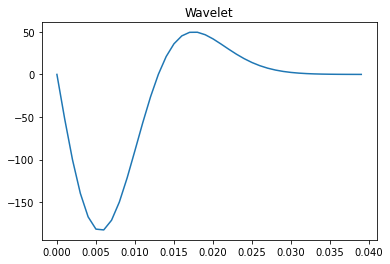

In [26]:
# draw wavelat
plt.plot(np.arange(0, 0.04, 0.001), source_array)
plt.title('Wavelet')
plt.show()

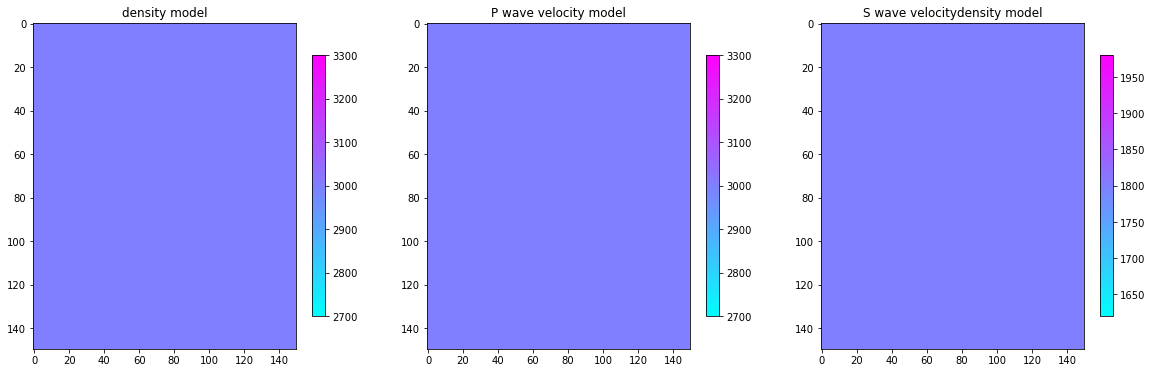

In [16]:
# draw model
test.DrawModel()

In [7]:
test.o24FM(wavelet=source_array, wavalet_position=source_position, wavalet_direction='x')

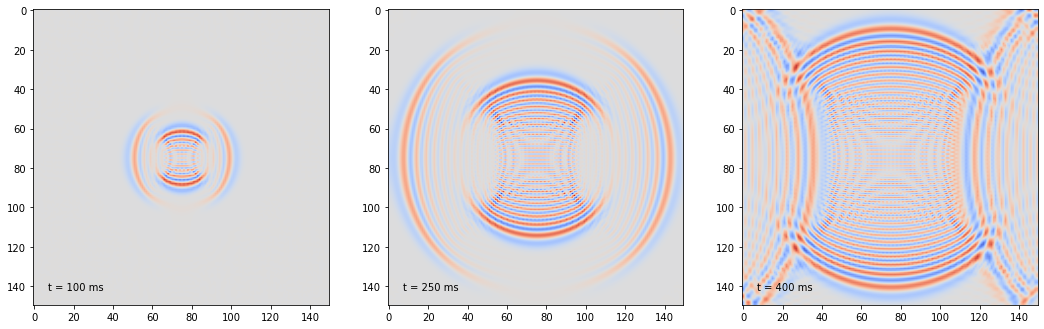

In [8]:
test.DrawXWaveField([100,250, 400])

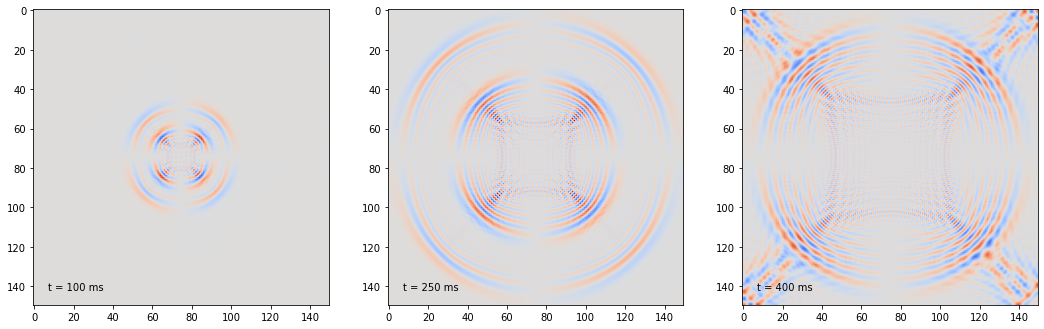

In [9]:
test.DrawZWaveField([100,250, 400])

In [10]:
test_2 = FirstOrderForward(pmodel, vpmodel, vsmodel, tmax, xmax, zmax, nt, nx, nz)
test.o4xFM(wavelet=source_array, wavalet_position=source_position, wavalet_direction='x')

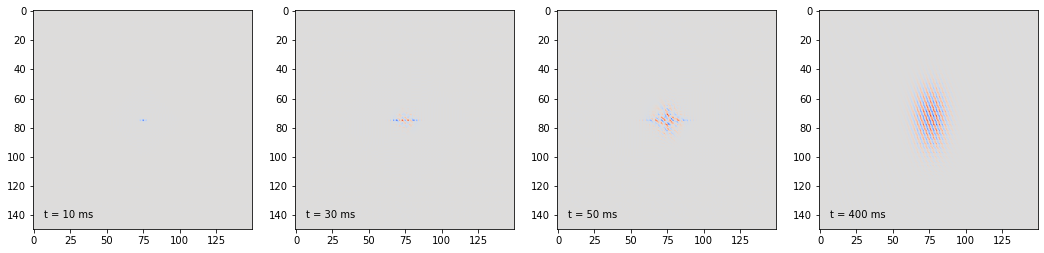

In [11]:
test.DrawXWaveField([10, 30, 50, 400])

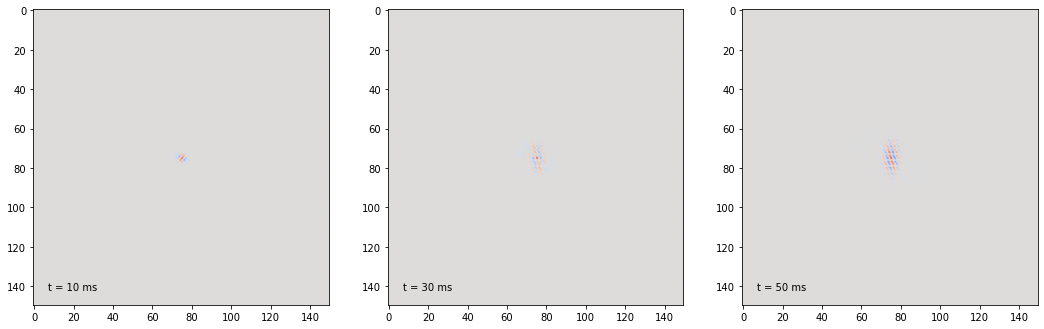

In [12]:
test.DrawZWaveField([10, 30, 50])

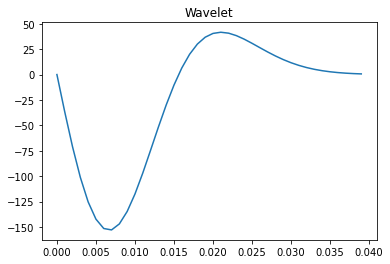

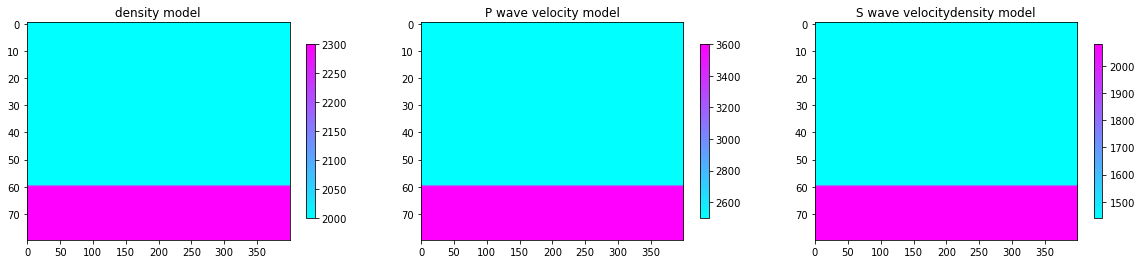

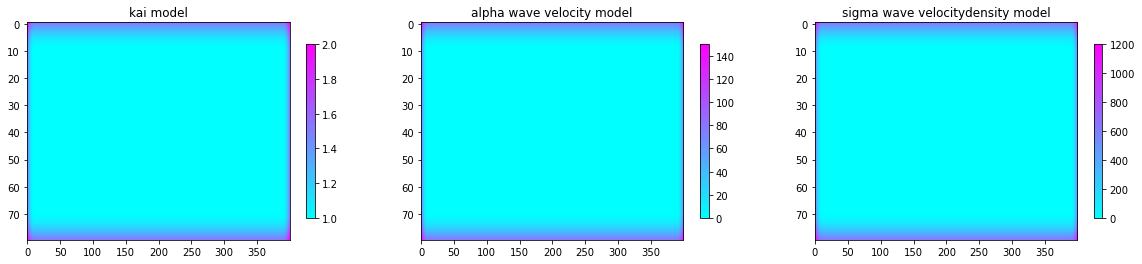

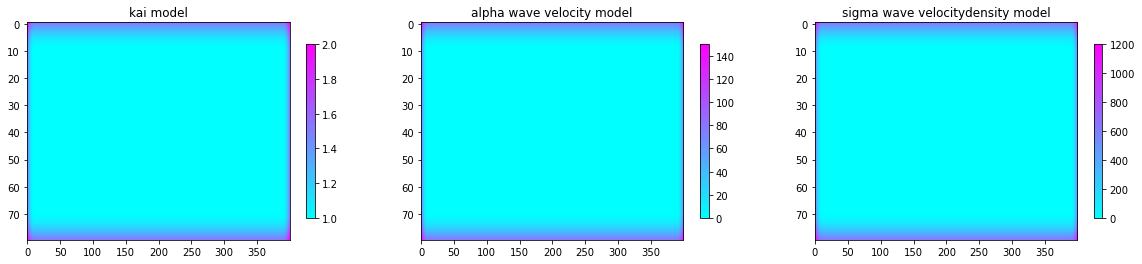

In [10]:
f_m = 25
source_array = np.zeros(40)
for tk , t in enumerate(np.arange(0, 0.04, 0.001)):
    #print(t,tk)
    source_array[tk] = \
            ((-4 * pi**2 * f_m**2 * t) + (2 * pi**2 * f_m**2 * t**2 - 1) * (pi**2 * f_m**2 * 2 * t)) * exp(-pi**2 * f_m**2 * t**2)

# draw wavelat
plt.plot(np.arange(0, 0.04, 0.001), source_array)
plt.title('Wavelet')
plt.show()

nx = 400
nz = 80
nt = 1900
dx = dz =7.5
dt = 0.6 / 1000
x_max = nx * dx 
z_max = nz * dz
t_max = nt * dt

pmodel = np.ones((nx,nz), dtype=float)
vsmodel = np.ones((nx,nz), dtype=float)
vpmodel = np.ones((nx,nz), dtype=float)

pmodel[:, 0:60] = 2000
vpmodel[:, 0:60] = 2500
vsmodel[:, 0:60] = 1440

pmodel[:, 60:] = 2300
vpmodel[:, 60:] = 3600
vsmodel[:, 60:] = 2080

pml_x = 10
pml_z = 10

kai_x, kai_z, sigma_x, sigma_z, alpha_x, alpha_z = FristOlderForward_PML.Cal_Auxiliary_Para(vsmodel, nx, nz, x_max, z_max, pml_x, pml_z)
test_3 = FristOlderForward_PML(pmodel, vpmodel, vsmodel, t_max, x_max, z_max, nt, nx, nz, kai_x, kai_z, sigma_x, sigma_z, alpha_x, alpha_z)
test_3.DrawModel()

plt.figure(figsize=(20, 4))
        
ax1 = plt.subplot(1,3,1)
plt.imshow(test_3._kai_x.T, cmap=plt.cm.cool, aspect='auto')
plt.title("kai model")
plt.colorbar(shrink=0.8)

plt.subplot(1,3,2)
plt.imshow(test_3._alpha_x.T, cmap=plt.cm.cool, aspect='auto')
plt.title("alpha wave velocity model")
plt.colorbar(shrink=0.8)

plt.subplot(1,3,3)
plt.imshow(test_3._sigma_x.T, cmap=plt.cm.cool, aspect='auto')
plt.title("sigma wave velocitydensity model")
plt.colorbar(shrink=0.8)
plt.show()

plt.figure(figsize=(20, 4))
        
ax1 = plt.subplot(1,3,1)
plt.imshow(test_3._kai_z.T, cmap=plt.cm.cool, aspect='auto')
plt.title("kai model")
plt.colorbar(shrink=0.8)

plt.subplot(1,3,2)
plt.imshow(test_3._alpha_z.T, cmap=plt.cm.cool, aspect='auto')
plt.title("alpha wave velocity model")
plt.colorbar(shrink=0.8)

plt.subplot(1,3,3)
plt.imshow(test_3._sigma_z.T, cmap=plt.cm.cool, aspect='auto')
plt.title("sigma wave velocitydensity model")
plt.colorbar(shrink=0.8)
plt.show()

# print(test_3._kai_x[12:,12:])

In [11]:
wavelet_position_pml = [11,100]  # [z,x]
test_3.o24FM(source_array, wavelet_position_pml, wavalet_direction='x')

+++++compute u
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
correct:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
after:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
+++++compute u
[[  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.         -36.63215091   0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]]
correct:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
after:
[[  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.         -36.63215091   0.           0.        ]
 [  0.           0.          

+++++compute u
[[ -13.60131356  -76.85304072 -138.66014251  -76.04168498  -17.47351086]
 [ -19.98464678 -107.99347752  -93.26614912 -108.5353297   -26.42169798]
 [  13.359386    -86.07701757  329.87147929  -87.38044235    6.96087729]
 [ -18.98927978 -108.70843079  -93.26434642 -108.53332547  -26.42157848]
 [ -14.00355223  -76.6052589  -138.66088529  -76.04252842  -17.47356351]]
correct:
[[-0.66822972  0.          0.          0.          0.        ]
 [-2.07439025  0.          0.          0.          0.        ]
 [-3.74222446  0.          0.          0.          0.        ]
 [-2.22687197  0.          0.          0.          0.        ]
 [-0.71708489  0.          0.          0.          0.        ]]
after:
[[ -12.93308384  -76.85304072 -138.66014251  -76.04168498  -17.47351086]
 [ -17.91025653 -107.99347752  -93.26614912 -108.5353297   -26.42169798]
 [  17.10161046  -86.07701757  329.87147929  -87.38044235    6.96087729]
 [ -16.76240781 -108.70843079  -93.26434642 -108.53332547  -26.42157

correct:
[[-0.22118037  0.          0.          0.          0.        ]
 [-3.08270416  0.          0.          0.          0.        ]
 [-5.65479779  0.          0.          0.          0.        ]
 [-2.0400964   0.          0.          0.          0.        ]
 [-1.61638286  0.          0.          0.          0.        ]]
after:
[[ -36.99783411  -33.32113222   54.40846632  -34.28021082  -44.18397323]
 [   6.6714383    -7.44344188  280.861564    -11.83705069  -12.43529843]
 [ -85.02312062  -38.17979238  271.85805994  -39.05085398 -116.34292804]
 [   7.28498733  -10.65544693  280.89455347  -11.72259944  -12.41499373]
 [ -34.79692403  -33.99648174   54.40495031  -34.29682333  -44.18810891]]
+++++compute u
[[-2.83239265e+01 -9.03704591e+00  8.55689082e+01 -1.08982698e+01
  -3.41649444e+01]
 [-5.78196264e-02 -5.62020635e+00  2.76100217e+02 -9.79611662e+00
  -1.95229304e+01]
 [-1.04943187e+02  1.16732548e+01  2.01059159e+02  1.01664253e+01
  -1.29538433e+02]
 [ 4.23908509e-01 -8.74261380e+0

+++++compute u
[[   8.65744555   44.71436806  106.10744809   39.64027693  -15.36269545]
 [ -84.22477921  147.82798104  -49.32958651  145.52797299 -100.98876469]
 [  19.85980201  206.97681425 -206.59946496  200.97836174   21.51467612]
 [ -95.747932    149.46055964  -49.30150227  146.09914678 -100.68635863]
 [   3.99028955   41.52933325  106.16766867   40.04262717  -15.24886207]]
correct:
[[-0.43223038  0.          0.          0.          0.        ]
 [-0.39449387  0.          0.          0.          0.        ]
 [-0.21766551  0.          0.          0.          0.        ]
 [-0.22711885  0.          0.          0.          0.        ]
 [ 0.73063066  0.          0.          0.          0.        ]]
after:
[[   9.08967592   44.71436806  106.10744809   39.64027693  -15.36269545]
 [ -83.83028534  147.82798104  -49.32958651  145.52797299 -100.98876469]
 [  20.07746751  206.97681425 -206.59946496  200.97836174   21.51467612]
 [ -95.52081315  149.46055964  -49.30150227  146.09914678 -100.68635

+++++compute u
[[ 17.60062224  96.24255243 -59.15809435  99.48142619  17.46570845]
 [142.67423327  10.24852494 -78.23721646   9.09963586 147.45890894]
 [110.22607997 -79.93085409  53.34749204 -75.52666648 102.35447746]
 [150.64496721   9.56918252 -78.25831157   9.00428068 147.8664995 ]
 [  9.80097646  97.60377327 -59.12437526 100.37881362  18.35983667]]
correct:
[[2.06969299 0.         0.         0.         0.        ]
 [1.16817734 0.         0.         0.         0.        ]
 [0.86241138 0.         0.         0.         0.        ]
 [1.93226107 0.         0.         0.         0.        ]
 [1.25587235 0.         0.         0.         0.        ]]
after:
[[ 15.53092925  96.24255243 -59.15809435  99.48142619  17.46570845]
 [141.50605593  10.24852494 -78.23721646   9.09963586 147.45890894]
 [109.36366858 -79.93085409  53.34749204 -75.52666648 102.35447746]
 [148.71270614   9.56918252 -78.25831157   9.00428068 147.8664995 ]
 [  8.54510411  97.60377327 -59.12437526 100.37881362  18.3598366

+++++compute u
[[ 112.87616982  -89.1867031    32.46580014  -88.04327012  101.55345858]
 [  70.94061296 -108.67868715  131.89967061 -102.99044058   21.89784134]
 [  33.52564111  -18.51890975   29.80012834  -24.36526851    1.58968877]
 [  69.28324114 -109.07781086  132.25539654 -102.79241296   21.87550152]
 [ 126.0981488   -88.51277438   33.01899447  -88.3930145   101.87884873]]
correct:
[[-0.26683817  0.          0.          0.          0.        ]
 [-3.61455483  0.          0.          0.          0.        ]
 [-4.05900564  0.          0.          0.          0.        ]
 [-0.19822513  0.          0.          0.          0.        ]
 [ 1.11031575  0.          0.          0.          0.        ]]
after:
[[ 113.14300799  -89.1867031    32.46580014  -88.04327012  101.55345858]
 [  74.5551678  -108.67868715  131.89967061 -102.99044058   21.89784134]
 [  37.58464674  -18.51890975   29.80012834  -24.36526851    1.58968877]
 [  69.48146627 -109.07781086  132.25539654 -102.79241296   21.87550

+++++compute u
[[-21.12430007  33.71580329   9.5852984   30.51985297 -78.17299423]
 [-55.17929406 106.03042072 -92.43132797  93.85937653 -89.26189626]
 [  1.54388905  60.75980536 -29.46806517  49.2514105  -52.74522216]
 [-60.67181949 112.83992685 -90.63728399  94.82482674 -88.7572049 ]
 [-32.36127565  37.35916596  11.77762851  31.96025718 -77.96363615]]
correct:
[[-3.25951104  0.          0.          0.          0.        ]
 [-2.6084492   0.          0.          0.          0.        ]
 [-2.74699187  0.          0.          0.          0.        ]
 [-1.00808927  0.          0.          0.          0.        ]
 [ 0.32288778  0.          0.          0.          0.        ]]
after:
[[-17.86478903  33.71580329   9.5852984   30.51985297 -78.17299423]
 [-52.57084485 106.03042072 -92.43132797  93.85937653 -89.26189626]
 [  4.29088092  60.75980536 -29.46806517  49.2514105  -52.74522216]
 [-59.66373021 112.83992685 -90.63728399  94.82482674 -88.7572049 ]
 [-32.68416343  37.35916596  11.77762851

+++++compute u
[[ -1.81245129  39.2614474  -64.55810852  41.21699594  -8.15783755]
 [144.04292502 -16.5064042   33.41882754 -22.64052163  64.51627181]
 [164.87147951  33.7288625    0.91477865   7.3445761   14.42206892]
 [146.15191921   3.59111094  43.36734908 -19.59249805  65.64508303]
 [-22.47099511  51.81485467 -57.22655742  44.69960456  -6.17352316]]
correct:
[[-1.52378139  0.          0.          0.          0.        ]
 [ 0.43745962  0.          0.          0.          0.        ]
 [ 2.18405726  0.          0.          0.          0.        ]
 [ 1.073994    0.          0.          0.          0.        ]
 [ 0.06302621  0.          0.          0.          0.        ]]
after:
[[ -0.2886699   39.2614474  -64.55810852  41.21699594  -8.15783755]
 [143.6054654  -16.5064042   33.41882754 -22.64052163  64.51627181]
 [162.68742225  33.7288625    0.91477865   7.3445761   14.42206892]
 [145.07792521   3.59111094  43.36734908 -19.59249805  65.64508303]
 [-22.53402132  51.81485467 -57.22655742

+++++compute u
[[  39.48523929 -149.897987     67.74146045  -80.66659577   73.59896036]
 [ 332.84726846   32.53832259   36.85207456  -16.53103148   -2.60522713]
 [ 569.31203778   85.31384428  137.78947704  -24.8291288    67.57366091]
 [ 206.6326261    34.50978978   60.62705831   -3.55287481    2.22746894]
 [  13.60662257 -138.18911056   87.95799736  -69.58486077   78.41931887]]
correct:
[[-5.45189841  0.          0.          0.          0.        ]
 [ 5.80198182  0.          0.          0.          0.        ]
 [13.193633    0.          0.          0.          0.        ]
 [ 2.45950443  0.          0.          0.          0.        ]
 [-5.89775208  0.          0.          0.          0.        ]]
after:
[[  44.9371377  -149.897987     67.74146045  -80.66659577   73.59896036]
 [ 327.04528664   32.53832259   36.85207456  -16.53103148   -2.60522713]
 [ 556.11840477   85.31384428  137.78947704  -24.8291288    67.57366091]
 [ 204.17312166   34.50978978   60.62705831   -3.55287481    2.22746

+++++compute u
[[-1.78884641e+03 -1.05623647e+02 -1.30119714e+02  2.16802656e+01
  -8.00022031e+01]
 [ 1.47679489e+02  4.35054167e+02  1.24685579e+02  8.25040521e+01
  -1.09933207e+00]
 [ 2.62968272e+03  6.78120142e+02  1.60865084e+02  1.43916920e+02
  -3.74002886e+01]
 [ 4.60745864e+02  1.95029795e+02  9.04949276e+01  9.53773276e+01
   1.07466950e+01]
 [-1.78292270e+03 -1.05305818e+02 -1.04452932e+02  4.68272515e+01
  -6.54117297e+01]]
correct:
[[-46.37736314   0.           0.           0.           0.        ]
 [ 16.66854283   0.           0.           0.           0.        ]
 [ 77.03451391   0.           0.           0.           0.        ]
 [  7.84842444   0.           0.           0.           0.        ]
 [-52.90780794   0.           0.           0.           0.        ]]
after:
[[-1.74246904e+03 -1.05623647e+02 -1.30119714e+02  2.16802656e+01
  -8.00022031e+01]
 [ 1.31010946e+02  4.35054167e+02  1.24685579e+02  8.25040521e+01
  -1.09933207e+00]
 [ 2.55264820e+03  6.78120142e+0

+++++compute u
[[ 5.75179336e+03 -2.04331928e+03 -3.96947021e+02 -6.92548613e+01
   1.21540910e+01]
 [-1.18583814e+04  1.60800456e+02  4.46022316e+02  2.14823844e+02
   7.63121296e+01]
 [-2.74852082e+03  3.94714801e+03  1.17063000e+03  3.34641199e+02
   1.65193459e+02]
 [ 2.25996898e+04  1.97411358e+03  3.72305239e+02  1.57799397e+02
   7.25073329e+01]
 [ 3.09384974e+03 -2.62314614e+03 -4.92847582e+02 -7.11985834e+01
   2.89654263e+01]]
correct:
[[  90.72143866    0.            0.            0.            0.        ]
 [-271.99632058    0.            0.            0.            0.        ]
 [ 114.84196056    0.            0.            0.            0.        ]
 [ 525.6414344     0.            0.            0.            0.        ]
 [ -97.02965664    0.            0.            0.            0.        ]]
after:
[[ 5.66107192e+03 -2.04331928e+03 -3.96947021e+02 -6.92548613e+01
   1.21540910e+01]
 [-1.15863851e+04  1.60800456e+02  4.46022316e+02  2.14823844e+02
   7.63121296e+01]
 [-2.86

+++++compute u
[[ 1.62005296e+05  2.73873929e+04  1.04173081e+03 -4.63790365e+02
  -9.57734201e+01]
 [ 3.60886782e+04 -1.12673252e+03  1.07845837e+03  5.46167918e+02
   3.09031151e+02]
 [-2.66596084e+05 -2.97092635e+04  1.14829590e+03  1.49050640e+03
   5.46993708e+02]
 [-7.62367840e+04  1.82176883e+04  5.09285103e+03  1.07928066e+03
   3.39390156e+02]
 [ 2.66267350e+05  3.17724004e+04  8.27295268e+02 -6.30553002e+02
  -1.42972775e+02]]
correct:
[[ 4591.14191715     0.             0.             0.
      0.        ]
 [ -304.82515532     0.             0.             0.
      0.        ]
 [-6740.70254641     0.             0.             0.
      0.        ]
 [  -59.36936099     0.             0.             0.
      0.        ]
 [ 6539.9998919      0.             0.             0.
      0.        ]]
after:
[[ 1.57414154e+05  2.73873929e+04  1.04173081e+03 -4.63790365e+02
  -9.57734201e+01]
 [ 3.63935033e+04 -1.12673252e+03  1.07845837e+03  5.46167918e+02
   3.09031151e+02]
 [-2.5985538

+++++compute u
[[-1.45450321e+06  4.68279735e+04  5.47357809e+04  1.16405589e+04
   1.25617857e+03]
 [ 1.93160473e+05 -8.11772814e+03  7.94899998e+02  2.91426159e+03
   1.16726429e+03]
 [ 1.72408941e+06 -1.20286207e+05 -6.57917080e+04 -1.06219289e+04
  -1.46826012e+02]
 [-1.10268723e+06 -2.11833398e+05 -1.95343606e+04  1.94672500e+03
   1.48935087e+03]
 [-1.82261859e+06  1.00569838e+05  6.60008803e+04  1.34082739e+04
   1.47709051e+03]]
correct:
[[-34153.10618463      0.              0.              0.
       0.        ]
 [ 15501.55937993      0.              0.              0.
       0.        ]
 [ 30937.49171077      0.              0.              0.
       0.        ]
 [-36078.44259946      0.              0.              0.
       0.        ]
 [-29885.71774663      0.              0.              0.
       0.        ]]
after:
[[-1.42035010e+06  4.68279735e+04  5.47357809e+04  1.16405589e+04
   1.25617857e+03]
 [ 1.77658914e+05 -8.11772814e+03  7.94899998e+02  2.91426159e+03
   1.1

+++++compute u
[[ 1.55816650e+06 -1.44016332e+06 -2.26307013e+05  1.37789141e+04
   1.36113509e+04]
 [-2.53471244e+06 -2.55036381e+05 -1.27064502e+05 -2.71329977e+04
  -1.46559972e+03]
 [ 9.70160546e+05  1.68762963e+06  1.94079336e+05 -2.42892902e+04
  -1.32262685e+04]
 [ 7.88816245e+06 -6.84590390e+03 -1.67857105e+05 -4.66916825e+04
  -7.11482456e+03]
 [-2.21639562e+06 -1.93752523e+06 -2.76067056e+05  8.56341954e+03
   1.35578229e+04]]
correct:
[[  -3912.59934214       0.               0.               0.
        0.        ]
 [ -70201.93586052       0.               0.               0.
        0.        ]
 [  95982.87633365       0.               0.               0.
        0.        ]
 [ 157389.39767134       0.               0.               0.
        0.        ]
 [-131714.48809109       0.               0.               0.
        0.        ]]
after:
[[ 1.56207910e+06 -1.44016332e+06 -2.26307013e+05  1.37789141e+04
   1.36113509e+04]
 [-2.46451050e+06 -2.55036381e+05 -1.27064502e+

+++++compute u
[[ 2.82735936e+07  4.77383622e+06 -5.77236573e+05 -3.42753914e+05
  -5.64531977e+04]
 [ 9.32089759e+06  1.88429654e+06  3.03504384e+05 -8.29402419e+04
  -4.63512598e+04]
 [-4.41615350e+07 -4.85911102e+06  5.42134904e+05  2.69960902e+05
   3.29575957e+04]
 [-4.90979718e+06  4.30016638e+06  7.96768183e+05  4.56161698e+04
  -2.50515874e+04]
 [ 5.17111536e+07  5.19344273e+06 -6.66486220e+05 -3.82284877e+05
  -7.31725290e+04]]
correct:
[[  883641.17190574        0.                0.                0.
         0.        ]
 [ -119263.78620901        0.                0.                0.
         0.        ]
 [-1153507.52776577        0.                0.                0.
         0.        ]
 [  329031.01432314        0.                0.                0.
         0.        ]
 [ 1233030.03184788        0.                0.                0.
         0.        ]]
after:
[[ 2.73899525e+07  4.77383622e+06 -5.77236573e+05 -3.42753914e+05
  -5.64531977e+04]
 [ 9.44016137e+06  1.8

+++++compute u
[[-1.60478050e+08  1.05816394e+07  6.87253469e+06  9.18990678e+05
  -1.05975348e+05]
 [-5.51928264e+06 -1.10156709e+06  2.59611172e+06  1.01913626e+06
   1.46303064e+05]
 [ 1.81947292e+08 -1.32931872e+07 -6.74004830e+06 -9.76623121e+05
  -1.68844679e+03]
 [-1.18534140e+08 -1.37215214e+07 -3.23486660e+05  3.85593280e+05
   1.27403657e+05]
 [-1.68328265e+08  1.82112736e+07  8.29581108e+06  1.32242264e+06
  -8.77331061e+03]]
correct:
[[-3926420.58452409        0.                0.                0.
         0.        ]
 [ 2242527.98256433        0.                0.                0.
         0.        ]
 [ 3066074.64772186        0.                0.                0.
         0.        ]
 [-4657337.6884823         0.                0.                0.
         0.        ]
 [-2126342.61626666        0.                0.                0.
         0.        ]]
after:
[[-1.56551629e+08  1.05816394e+07  6.87253469e+06  9.18990678e+05
  -1.05975348e+05]
 [-7.76181063e+06 -1.1

+++++compute u
[[ 1.77348466e+08 -1.25228689e+08 -1.34267412e+07  3.03551227e+06
   1.35253388e+06]
 [ 4.48636240e+06 -5.19119615e+07 -2.15077680e+07 -2.59672778e+06
   3.98272860e+05]
 [-4.18612466e+07  1.48939362e+08  1.97269803e+07 -6.62553693e+05
  -7.85908675e+05]
 [ 3.80268253e+08 -8.73218305e+06 -4.53558563e+06 -1.42083639e+06
  -2.90737912e+05]
 [-1.35555005e+08 -1.62460399e+08 -2.19629771e+07  1.08492110e+06
   1.23604030e+06]]
correct:
[[ -1005456.78215444         0.                 0.
          0.                 0.        ]
 [ -4592082.38038543         0.                 0.
          0.                 0.        ]
 [  8928754.85385418         0.                 0.
          0.                 0.        ]
 [  9143684.74502528         0.                 0.
          0.                 0.        ]
 [-13581309.83613635         0.                 0.
          0.                 0.        ]]
after:
[[ 1.78353923e+08 -1.25228689e+08 -1.34267412e+07  3.03551227e+06
   1.35253388e+0

+++++compute u
[[ 8.26540586e+07  2.10012103e+08 -7.47205279e+07 -2.60434705e+07
  -2.87159573e+06]
 [-6.14881663e+08  4.97972891e+08  6.62243562e+07 -1.13554841e+07
  -5.57357167e+06]
 [-3.23150529e+08 -3.55654149e+08  3.46516078e+07  2.17077215e+07
   4.19578277e+06]
 [ 4.78869040e+08 -8.28251198e+07 -1.85507522e+07  3.28251250e+06
   1.27525161e+06]
 [ 5.25897955e+08  3.72702450e+08 -2.94268579e+07 -2.44169550e+07
  -5.36540673e+06]]
correct:
[[ 44529838.74097186         0.                 0.
          0.                 0.        ]
 [-41206425.77941136         0.                 0.
          0.                 0.        ]
 [-47925568.34247671         0.                 0.
          0.                 0.        ]
 [ 50870304.123155           0.                 0.
          0.                 0.        ]
 [ 42009379.99745219         0.                 0.
          0.                 0.        ]]
after:
[[ 3.81242199e+07  2.10012103e+08 -7.47205279e+07 -2.60434705e+07
  -2.87159573e+0

+++++compute u
[[ 2.44530073e+10 -1.26765393e+09  8.72874195e+06 -1.73524420e+06
  -1.47452783e+07]
 [-1.18842448e+10 -4.44601764e+09 -4.44844540e+07  1.37766478e+08
   2.62331839e+07]
 [-2.54802603e+10  2.94103342e+09  1.55830752e+08 -3.64245823e+07
  -2.92268543e+06]
 [ 2.16675196e+10  3.91003056e+09  1.47920128e+08 -6.74699168e+07
  -1.32546700e+07]
 [ 2.23979251e+10 -3.71669122e+09 -2.26280986e+08  5.27574507e+07
   7.98945001e+06]]
correct:
[[ 2.49075348e+08  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-6.50044090e+06  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-3.26205033e+08  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.95792108e+08  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 3.20736550e+08  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 2.42039319e+10 -1.26765393e+09  8.72874195e+06 -1.73524420e+06
  -1.47452783e+07]
 [-1.18777443e+10 -4.44601764e+0

+++++compute u
[[ 3.75162037e+10  5.00704654e+10  3.51125785e+09 -3.06236704e+07
  -1.97271387e+07]
 [ 3.19035297e+11  1.99254975e+10 -2.51553994e+09 -7.67815187e+08
  -3.51444951e+07]
 [-1.48311027e+11 -6.37645937e+10 -3.17149234e+09  4.27768104e+08
   7.68167239e+07]
 [-3.82839468e+11 -5.21001682e+09  4.41992695e+09  8.58079466e+08
   4.76919084e+07]
 [ 2.28519578e+11  6.66586507e+10  2.54448216e+09 -6.43358762e+08
  -1.01687799e+08]]
correct:
[[ 3.35829208e+09  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 4.53251656e+09  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-5.35353966e+09  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-5.48128847e+09  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 6.48842666e+09  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 3.41579116e+10  5.00704654e+10  3.51125785e+09 -3.06236704e+07
  -1.97271387e+07]
 [ 3.14502781e+11  1.99254975e+1

+++++compute u
[[-3.49468725e+12 -5.83459403e+11  1.50101230e+10  1.27008505e+10
   1.71013362e+09]
 [-3.02426037e+12 -4.11800452e+10  3.62345052e+10  7.14698004e+09
   2.69514879e+08]
 [ 5.09344570e+12  6.59119292e+11 -2.79455706e+10 -1.64553566e+10
  -2.00288392e+09]
 [ 2.66083990e+12 -2.63821020e+11 -6.52615418e+10 -5.93606756e+09
   4.21109423e+08]
 [-5.79703957e+12 -6.23645627e+11  3.98335766e+10  1.82958574e+10
   2.09184596e+09]]
correct:
[[-1.01105458e+11  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-3.15464758e+10  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.27100320e+11  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.83337586e+10  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.32639003e+11  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-3.39358180e+12 -5.83459403e+11  1.50101230e+10  1.27008505e+10
   1.71013362e+09]
 [-2.99271389e+12 -4.11800452e+1

+++++compute u
[[ 5.05958151e+13  2.49702058e+12 -8.60336264e+11 -1.78855704e+11
  -9.96203220e+09]
 [ 1.42672149e+13 -1.14449239e+12 -4.53902190e+11 -6.62783784e+10
  -4.59298239e+08]
 [-6.24508085e+13 -2.26486315e+12  1.06538949e+12  2.13093279e+11
   1.13865616e+10]
 [-3.53879069e+11  3.96214372e+12  4.73511030e+11 -3.75724340e+09
  -1.30852905e+10]
 [ 6.40802215e+13  1.55375399e+12 -1.16735150e+12 -2.21547016e+11
  -1.04089135e+10]]
correct:
[[ 1.23000968e+12  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-4.42406499e+10  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.34873702e+12  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 3.61724432e+11  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.27315070e+12  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 4.93658054e+13  2.49702058e+12 -8.60336264e+11 -1.78855704e+11
  -9.96203220e+09]
 [ 1.43114556e+13 -1.14449239e+1

+++++compute u
[[-4.05451639e+14  1.42668138e+13  1.07688297e+13  1.17714515e+12
  -8.21705497e+10]
 [ 1.52114057e+13  1.75276448e+13  3.93351603e+12  3.61080192e+11
  -5.18061572e+10]
 [ 4.43370925e+14 -2.23516229e+13 -1.26792953e+13 -1.38400428e+12
   9.16317506e+10]
 [-1.67124187e+14 -2.98774057e+13 -1.18834872e+12  5.39171918e+11
   1.49732526e+11]
 [-4.15889253e+14  2.83186240e+13  1.31272665e+13  1.36512490e+12
  -1.14836554e+11]]
correct:
[[-8.62302763e+12  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.48416245e+12  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 8.21372293e+12  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-5.52573224e+12  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-6.84678183e+12  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-3.96828611e+14  1.42668138e+13  1.07688297e+13  1.17714515e+12
  -8.21705497e+10]
 [ 1.27272432e+13  1.75276448e+1

+++++compute u
[[ 1.94006580e+15 -3.10087364e+14 -7.74892725e+13 -2.04554445e+12
   1.94069364e+12]
 [-8.17529367e+14 -1.36287690e+14 -2.12665946e+13  1.67571191e+11
   8.95914658e+11]
 [-1.77002665e+15  3.85113336e+14  8.83520217e+13  2.41368001e+12
  -2.22413839e+12]
 [ 1.75780728e+15  1.20240539e+14 -1.34206642e+13 -6.36620891e+12
  -9.93361074e+11]
 [ 1.40874289e+15 -4.11674647e+14 -8.77599223e+13 -1.64252951e+12
   2.47516350e+12]]
correct:
[[ 3.31790019e+13  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.15678156e+13  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.34184645e+13  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 3.84351015e+13  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.28807279e+13  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 1.90688680e+15 -3.10087364e+14 -7.74892725e+13 -2.04554445e+12
   1.94069364e+12]
 [-7.95961552e+14 -1.36287690e+1

+++++compute u
[[-3.50237433e+15  2.54305344e+15  3.38773949e+14 -3.75367334e+13
  -1.81702525e+13]
 [ 6.78804291e+15  5.69071965e+14  3.91332886e+13 -2.21000491e+13
  -7.92843200e+12]
 [ 6.59320288e+14 -2.91042512e+15 -3.63917239e+14  4.42028835e+13
   2.11798893e+13]
 [-9.83332188e+15  4.62092288e+13  1.95924458e+14  4.35000656e+13
   3.09708732e+12]
 [ 1.47220474e+15  2.91177242e+15  3.36042927e+14 -5.20898667e+13
  -2.28441383e+13]]
correct:
[[-5.96746538e+12  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 8.52318067e+13  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-6.18092152e+13  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.32371524e+14  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.04237276e+14  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-3.49640686e+15  2.54305344e+15  3.38773949e+14 -3.75367334e+13
  -1.81702525e+13]
 [ 6.70281111e+15  5.69071965e+1

+++++compute u
[[-2.23243048e+16 -1.19451078e+16 -6.04366936e+14  4.32936207e+14
   1.05928277e+14]
 [-2.40927411e+16  7.91027205e+14  4.43628837e+14  1.97403371e+14
   3.94425086e+13]
 [ 3.71794601e+16  1.20926855e+16  4.21408049e+14 -5.09072609e+14
  -1.24076236e+14]
 [ 2.15297577e+16 -4.62568438e+15 -1.36868960e+15 -1.72902898e+14
   1.36155339e+13]
 [-4.06778733e+16 -1.10677326e+16 -1.66505486e+14  5.55771326e+14
   1.29436676e+14]]
correct:
[[-6.09968672e+14  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.41422997e+14  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 7.91661765e+14  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.79964324e+14  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-7.90129759e+14  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-2.17143361e+16 -1.19451078e+16 -6.04366936e+14  4.32936207e+14
   1.05928277e+14]
 [-2.42341641e+16  7.91027205e+1

+++++compute u
[[ 1.19742059e+17  1.15474442e+16 -2.18003812e+15 -2.29824674e+15
  -3.77553144e+14]
 [-1.48347144e+17 -3.82422826e+16 -4.05819194e+15 -5.73501793e+14
  -3.02572248e+13]
 [-9.42262041e+16  5.09802361e+15  4.42276005e+15  2.59852129e+15
   4.15479461e+14]
 [ 2.23447215e+17  3.69600024e+16  4.96706028e+15 -6.63744973e+13
  -2.65031010e+14]
 [ 1.97594073e+16 -1.45609028e+16 -5.68045735e+15 -2.69663408e+15
  -3.92535262e+14]]
correct:
[[-8.80561475e+14  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-5.33702180e+15  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.24396682e+15  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 5.64639527e+15  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-3.59324605e+15  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 1.20622621e+17  1.15474442e+16 -2.18003812e+15 -2.29824674e+15
  -3.77553144e+14]
 [-1.43010122e+17 -3.82422826e+1

+++++compute u
[[ 2.18368585e+18  4.41151199e+17 -5.26543389e+15  9.79176606e+14
   2.68470593e+14]
 [ 3.82164850e+18  3.93812872e+17 -4.97428875e+15 -7.42959183e+15
  -1.35427616e+15]
 [-3.63596093e+18 -6.41262334e+17 -1.50871962e+15  1.26927044e+15
   2.34579355e+14]
 [-3.79501585e+18 -1.00764442e+17  1.89552229e+16  8.19963231e+15
   1.94103145e+15]
 [ 4.79144499e+18  6.84273629e+17  5.39291658e+14 -2.78155283e+15
  -7.01836191e+14]]
correct:
[[ 1.03221437e+17  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 5.64507994e+16  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.28933405e+17  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-4.06736225e+16  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.39882353e+17  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 2.08046441e+18  4.41151199e+17 -5.26543389e+15  9.79176606e+14
   2.68470593e+14]
 [ 3.76519770e+18  3.93812872e+1

+++++compute u
[[-5.49316323e+19 -5.96260388e+18  6.58306112e+17  1.38530232e+17
   6.61704290e+15]
 [-4.61922435e+19 -2.40167476e+18  5.19296364e+17  1.41837161e+17
   1.28211105e+16]
 [ 7.49272800e+19  7.47758584e+18 -7.76906860e+17 -1.93569737e+17
  -1.37301097e+16]
 [ 3.57728944e+19 -1.77649705e+18 -5.80483344e+17 -8.29686105e+16
  -5.34686267e+15]
 [-8.62641190e+19 -7.32056480e+18  8.84091155e+17  2.17969504e+17
   1.70879664e+16]]
correct:
[[-1.74760958e+18  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-4.44756390e+17  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.01333234e+18  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 9.60730517e+16  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.04977919e+18  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-5.31840228e+19 -5.96260388e+18  6.58306112e+17  1.38530232e+17
   6.61704290e+15]
 [-4.57474871e+19 -2.40167476e+1

+++++compute u
[[ 7.74794783e+20  4.87525654e+19 -1.25122390e+19 -2.12217821e+18
  -2.52448282e+16]
 [ 4.13875963e+20  3.59882983e+18 -8.08053899e+18 -1.47992080e+18
  -4.10062004e+16]
 [-9.75086073e+20 -5.58545118e+19  1.50315962e+19  2.76227580e+18
   7.50986040e+16]
 [-2.26873173e+20  3.87527018e+19  6.87544635e+18  4.31563438e+17
  -7.79851432e+16]
 [ 1.05974259e+21  4.94448643e+19 -1.65362916e+19 -2.97388759e+18
  -8.11866270e+16]]
correct:
[[ 2.11443985e+19  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.48323002e+18  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.32651761e+19  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.35232228e+18  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.28239006e+19  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 7.53650385e+20  4.87525654e+19 -1.25122390e+19 -2.12217821e+18
  -2.52448282e+16]
 [ 4.11392733e+20  3.59882983e+1

+++++compute u
[[-8.48948242e+21 -2.23137235e+20  1.66516071e+20  2.20888908e+19
  -7.78413050e+17]
 [-2.83438746e+21  1.33991061e+20  8.76755211e+19  1.16158779e+19
  -5.43235643e+17]
 [ 1.00965310e+22  2.16339289e+20 -1.97229222e+20 -2.76776624e+19
   6.34308427e+17]
 [ 5.21098830e+20 -4.80021289e+20 -5.67254402e+19  9.56910957e+17
   1.62376561e+18]
 [-1.05271895e+22 -1.26464292e+20  2.11318138e+20  2.87993020e+19
  -8.24191681e+17]]
correct:
[[-2.10740788e+20  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.70217516e+18  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.22984623e+20  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-5.08539195e+19  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.11605490e+20  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-8.27874163e+21 -2.23137235e+20  1.66516071e+20  2.20888908e+19
  -7.78413050e+17]
 [-2.83168529e+21  1.33991061e+2

+++++compute u
[[ 7.69987814e+22 -7.39364319e+20 -1.78773244e+21 -1.76299189e+20
   1.95944370e+19]
 [ 1.34412688e+22 -2.21508152e+21 -7.66853658e+20 -6.95453808e+19
   1.22017685e+19]
 [-8.72661668e+22  1.32148313e+21  2.07703315e+21  2.15312146e+20
  -2.13262788e+19]
 [ 9.46560609e+21  4.46435110e+21  3.23574293e+20 -5.27440038e+19
  -1.87335895e+19]
 [ 8.77311571e+22 -2.20455511e+21 -2.17367899e+21 -2.15895574e+20
   2.46363529e+19]]
correct:
[[ 1.78017654e+21  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.41224516e+20  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.81125777e+21  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 6.38463005e+20  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.65940354e+21  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 7.52186048e+22 -7.39364319e+20 -1.78773244e+21 -1.76299189e+20
   1.95944370e+19]
 [ 1.35824933e+22 -2.21508152e+2

+++++compute u
[[-5.91630342e+23  2.87057152e+22  1.60570841e+22  1.03025442e+21
  -2.82662773e+20]
 [-2.41733045e+22  2.21194225e+22  5.60529689e+21  2.64434654e+20
  -1.49416648e+20]
 [ 6.41956684e+23 -3.60768548e+22 -1.82925136e+22 -1.24050931e+21
   3.19087810e+20]
 [-1.65631029e+23 -3.28427015e+22 -7.97089188e+20  7.30129603e+20
   1.61291428e+20]
 [-6.24046407e+23  4.27197673e+22  1.87374354e+22  1.17543543e+21
  -3.53885739e+20]]
correct:
[[-1.29159547e+22  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.00040701e+21  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.26358595e+22  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-5.96660874e+21  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.11491418e+22  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-5.78714388e+23  2.87057152e+22  1.60570841e+22  1.03025442e+21
  -2.82662773e+20]
 [-2.61737115e+22  2.21194225e+2

+++++compute u
[[ 3.97877049e+24 -3.60710076e+23 -1.23353198e+23 -3.32386621e+21
   3.07256834e+21]
 [-2.17773145e+23 -1.62658423e+23 -3.49756440e+22  1.28273872e+20
   1.38897577e+21]
 [-4.17289490e+24  4.20403944e+23  1.37849356e+23  4.09312270e+21
  -3.47923849e+21]
 [ 1.58735750e+24  1.92426414e+23 -7.62224427e+21 -6.94262484e+21
  -1.07808563e+21]
 [ 3.95630656e+24 -4.58907527e+23 -1.38464183e+23 -3.22590272e+21
   3.75473641e+21]]
correct:
[[ 8.39859123e+22  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.56315232e+22  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-7.97059512e+22  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 4.41141339e+22  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 6.81603389e+22  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 3.89478458e+24 -3.60710076e+23 -1.23353198e+23 -3.32386621e+21
   3.07256834e+21]
 [-2.02141622e+23 -1.62658423e+2

+++++compute u
[[-2.56498875e+25  3.15022046e+24  8.43428829e+23 -9.81671084e+21
  -2.71978858e+22]
 [ 1.28435301e+24  8.80178366e+23  2.02206715e+23 -1.01225069e+22
  -1.04472549e+22]
 [ 2.68244740e+25 -3.47041160e+24 -9.26721522e+23  8.20864507e+21
   3.05270266e+22]
 [-1.05866060e+25 -9.14604601e+23  1.20961445e+23  5.08398545e+22
   5.36976275e+21]
 [-2.55820277e+25  3.64036783e+24  9.16927233e+23 -1.51823807e+22
  -3.22181876e+22]]
correct:
[[-5.57542493e+23  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 6.46281065e+22  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 5.31779760e+23  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.67842938e+23  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-4.57489705e+23  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-2.50923450e+25  3.15022046e+24  8.43428829e+23 -9.81671084e+21
  -2.71978858e+22]
 [ 1.21972490e+24  8.80178366e+2

+++++compute u
[[ 1.91031269e+26 -2.11406283e+25 -5.64978545e+24  2.10854832e+23
   2.05318891e+23]
 [ 2.30689595e+25 -2.99403278e+24 -1.40156062e+24  4.42248474e+22
   6.51012180e+22]
 [-2.10006938e+26  2.17602880e+25  6.16576604e+24 -1.91778352e+23
  -2.26079085e+23]
 [ 4.52037642e+25  4.52358561e+24 -8.37792575e+23 -2.90341849e+23
  -1.72477835e+22]
 [ 2.10947803e+26 -2.24664394e+25 -6.09813465e+24  2.27495743e+23
   2.33848905e+23]]
correct:
[[ 4.63087423e+24  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.75807978e+23  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-4.64472380e+24  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.46299070e+24  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 4.22043952e+24  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 1.86400395e+26 -2.11406283e+25 -5.64978545e+24  2.10854832e+23
   2.05318891e+23]
 [ 2.28931516e+25 -2.99403278e+2

+++++compute u
[[-1.85412694e+27  1.08832018e+26  4.36584396e+25 -9.94527437e+23
  -1.39921506e+24]
 [-5.87751305e+26  2.06885966e+24  1.44900327e+25  7.45411806e+23
  -3.57679590e+23]
 [ 2.15734661e+27 -9.98856892e+25 -4.82808027e+25  4.37313418e+23
   1.49268091e+24]
 [-1.80831898e+25 -4.44530073e+25  1.33967729e+24  1.26391957e+24
   3.54012948e+22]
 [-2.27269139e+27  1.06904059e+26  4.88772852e+25 -4.78437456e+23
  -1.51946221e+24]]
correct:
[[-4.90365389e+25  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-6.03720959e+24  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 5.12931765e+25  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-9.48315908e+24  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-4.87159803e+25  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-1.80509040e+27  1.08832018e+26  4.36584396e+25 -9.94527437e+23
  -1.39921506e+24]
 [-5.81714095e+26  2.06885966e+2

+++++compute u
[[ 2.06803405e+28 -4.11189211e+26 -4.22549086e+26 -9.45052354e+24
   9.55607519e+24]
 [ 7.84528895e+27 -1.60287352e+25 -1.79006389e+26 -1.78209235e+25
   2.22618845e+24]
 [-2.44961406e+28  2.90103931e+26  4.77491818e+26  1.88490000e+25
  -9.81732400e+24]
 [-1.63298822e+27  6.66662046e+26  4.93681758e+25 -4.84488525e+24
  -7.27638971e+23]
 [ 2.61198560e+28 -4.10378073e+26 -4.96691419e+26 -2.02919157e+25
   9.98696851e+24]]
correct:
[[ 5.51704322e+26  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 6.33433729e+25  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-5.83534952e+26  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 9.54108074e+25  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 5.61628680e+26  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 2.01286362e+28 -4.11189211e+26 -4.22549086e+26 -9.45052354e+24
   9.55607519e+24]
 [ 7.78194558e+27 -1.60287352e+2

+++++compute u
[[-2.26459600e+29  1.62253402e+27  4.59005468e+27  2.57216692e+26
  -7.58358432e+25]
 [-7.87643349e+28  1.71333610e+27  2.09001226e+27  2.25161659e+26
  -2.20219823e+25]
 [ 2.66027319e+29 -9.29127896e+26 -5.24635934e+27 -3.71194017e+26
   7.67966353e+25]
 [ 1.32421967e+28 -9.05118035e+27 -8.31181349e+26  4.42086585e+25
   1.88953034e+25]
 [-2.81277018e+29  2.67808274e+27  5.51782061e+27  3.89461502e+26
  -8.01063291e+25]]
correct:
[[-5.85014893e+27  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-4.18034130e+26  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 6.15339021e+27  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.19286799e+27  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-5.89929603e+27  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-2.20609451e+29  1.62253402e+27  4.59005468e+27  2.57216692e+26
  -7.58358432e+25]
 [-7.83463007e+28  1.71333610e+2

+++++compute u
[[ 2.29148127e+30 -2.49532756e+28 -4.91597690e+28 -3.31771755e+27
   7.39946458e+26]
 [ 6.47939043e+29 -3.60225885e+28 -2.17109904e+28 -2.11929353e+27
   2.84974974e+26]
 [-2.64430985e+30  2.62877137e+28  5.62447112e+28  4.42991707e+27
  -7.67320895e+26]
 [ 1.56115071e+28  1.03005521e+29  8.51226103e+27 -8.03894839e+26
  -2.98429281e+26]
 [ 2.75167532e+30 -4.69298364e+28 -5.90601717e+28 -4.54610761e+27
   8.23623459e+26]]
correct:
[[ 5.67452059e+28  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.30912248e+27  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-5.89646752e+28  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.43080778e+28  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 5.58681442e+28  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 2.23473607e+30 -2.49532756e+28 -4.91597690e+28 -3.31771755e+27
   7.39946458e+26]
 [ 6.46629920e+29 -3.60225885e+2

+++++compute u
[[-2.12670203e+31  5.04244673e+29  4.91459545e+29  3.14270879e+28
  -8.01585550e+27]
 [-4.49156841e+30  4.91759086e+29  2.01481044e+29  1.59613181e+28
  -3.53609955e+27]
 [ 2.40547810e+31 -5.88312588e+29 -5.59875903e+29 -4.06316944e+28
   8.58607687e+27]
 [-1.81717076e+30 -1.00613055e+30 -6.48852883e+28  1.23193261e+28
   3.52496309e+27]
 [-2.45900133e+31  7.94959192e+29  5.83647067e+29  4.07140699e+28
  -9.31266469e+27]]
correct:
[[-5.05865579e+29  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.02910583e+28  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 5.18043832e+29  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.53566295e+29  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-4.83410689e+29  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-2.07611547e+31  5.04244673e+29  4.91459545e+29  3.14270879e+28
  -8.01585550e+27]
 [-4.50185947e+30  4.91759086e+2

+++++compute u
[[ 1.83068122e+32 -7.60969663e+30 -4.54275164e+30 -2.35025011e+29
   8.60067039e+28]
 [ 2.67332805e+31 -5.29771791e+30 -1.70305350e+30 -9.63722965e+28
   3.87571645e+28]
 [-2.03272540e+32  8.82334509e+30  5.14241664e+30  3.01697663e+29
  -9.40950836e+28]
 [ 2.96357996e+31  8.67045795e+30  3.64135053e+29 -1.50032720e+29
  -3.41992970e+28]
 [ 2.04361610e+32 -1.06366828e+31 -5.31239860e+30 -2.93103337e+29
   1.01736569e+29]]
correct:
[[ 4.21263681e+30  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.21561604e+29  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-4.25466904e+30  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.47211639e+30  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 3.90855147e+30  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 1.78855485e+32 -7.60969663e+30 -4.54275164e+30 -2.35025011e+29
   8.60067039e+28]
 [ 2.69548421e+31 -5.29771791e+3

+++++compute u
[[-1.49548504e+33  9.14467679e+31  3.91831146e+31  1.36015384e+30
  -8.67589301e+29]
 [-1.47942596e+32  4.86873723e+31  1.35039473e+31  4.43629162e+29
  -3.76762214e+29]
 [ 1.63884830e+33 -1.03870503e+32 -4.40820662e+31 -1.79924193e+30
   9.58109606e+29]
 [-3.34169991e+32 -6.77849050e+31 -1.17100697e+30  1.52872862e+30
   2.85306871e+29]
 [-1.62668223e+33  1.18225858e+32  4.51458236e+31  1.66329597e+30
  -1.02696198e+30]]
correct:
[[-3.36908413e+31  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.19983196e+30  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 3.37166782e+31  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.28122646e+31  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-3.05757011e+31  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-1.46179420e+33  9.14467679e+31  3.91831146e+31  1.36015384e+30
  -8.67589301e+29]
 [-1.50142428e+32  4.86873723e+3

+++++compute u
[[ 1.20480763e+34 -9.38129512e+32 -3.22370706e+32 -5.21081406e+30
   8.14045016e+30]
 [ 1.00586688e+33 -4.01474196e+32 -1.05285435e+32 -1.41117185e+30
   3.32179222e+30]
 [-1.31556451e+34  1.04182769e+33  3.61311429e+32  8.08283812e+30
  -9.00207558e+30]
 [ 3.07922355e+33  5.01388173e+32 -2.85578659e+30 -1.35662816e+31
  -2.11512120e+30]
 [ 1.29859644e+34 -1.14918327e+33 -3.67654534e+32 -6.69258504e+30
   9.55311105e+30]]
correct:
[[ 2.70819859e+32  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.36653010e+31  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.70806771e+32  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.04547397e+32  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.43919267e+32  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 1.17772564e+34 -9.38129512e+32 -3.22370706e+32 -5.21081406e+30
   8.14045016e+30]
 [ 1.01953218e+33 -4.01474196e+3

+++++compute u
[[-1.00668778e+35  8.62630215e+33  2.62374890e+33  1.34333680e+30
  -7.17818926e+31]
 [-1.07113256e+34  3.12250178e+33  8.59650137e+32  5.30072584e+30
  -2.74181588e+31]
 [ 1.10708731e+35 -9.36402813e+33 -2.94227335e+33 -2.33864732e+31
   7.90991798e+31]
 [-2.48621866e+34 -3.77283606e+33  6.80887033e+31  1.08663520e+32
   1.46087781e+31]
 [-1.09749530e+35  1.01881493e+34  2.98720878e+33  1.22427527e+31
  -8.31885874e+31]]
correct:
[[-2.31004139e+33  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 3.16415343e+31  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.32532687e+33  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-8.42768093e+32  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.09830487e+33  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-9.83587361e+34  8.62630215e+33  2.62374890e+33  1.34333680e+30
  -7.17818926e+31]
 [-1.07429671e+34  3.12250178e+3

+++++compute u
[[ 9.02808130e+35 -7.37727828e+34 -2.20977271e+34  1.49985887e+32
   6.09442013e+32]
 [ 1.36815483e+35 -2.42981972e+34 -7.68233553e+33 -1.09480570e+32
   2.21367936e+32]
 [-1.00465736e+36  7.83816655e+34  2.48873132e+34  6.81102164e+31
  -6.67354292e+32]
 [ 1.85579068e+35  3.15198955e+34 -3.47112535e+32 -8.24064819e+32
  -1.03147022e+32]
 [ 1.00763169e+36 -8.54933515e+34 -2.53434541e+34  6.66138282e+30
   6.97631459e+32]]
correct:
[[ 2.13984414e+34  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 4.23868168e+32  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.17029656e+34  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 7.10608614e+33  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.97618272e+34  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 8.81409688e+35 -7.37727828e+34 -2.20977271e+34  1.49985887e+32
   6.09442013e+32]
 [ 1.36391615e+35 -2.42981972e+3

+++++compute u
[[-8.58398534e+36  6.05277475e+35  1.98139890e+35 -6.54760136e+32
  -5.14899257e+33]
 [-1.61736576e+36  2.00942365e+35  7.39869522e+34  2.20375922e+33
  -1.83830479e+33]
 [ 9.62902488e+36 -6.33156554e+35 -2.24095744e+35 -1.79333425e+33
   5.59854553e+33]
 [-1.36540677e+36 -3.00191217e+35 -2.71534616e+33  6.35274460e+33
   8.44596762e+32]
 [-9.77415538e+36  7.02594805e+35  2.29689974e+35  1.34316242e+33
  -5.84547164e+33]]
correct:
[[-2.08260133e+35  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-6.30941622e+33  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.11986267e+35  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-6.40802051e+34  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.95215164e+35  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-8.37572520e+36  6.05277475e+35  1.98139890e+35 -6.54760136e+32
  -5.14899257e+33]
 [-1.61105634e+36  2.00942365e+3

+++++compute u
[[ 8.27626794e+37 -4.92533261e+36 -1.86983837e+36 -1.29110800e+34
   4.45994539e+34]
 [ 1.66428370e+37 -1.82741982e+36 -7.26576723e+35 -3.09826758e+34
   1.62306568e+34]
 [-9.29614756e+37  5.13999534e+36  2.11654806e+36  3.95771205e+34
  -4.82291885e+34]
 [ 1.07818448e+37  3.05606052e+36  8.11180326e+34 -5.35553502e+34
  -8.30947332e+33]
 [ 9.50148623e+37 -5.84791736e+36 -2.18282392e+36 -3.67104450e+34
   5.05543098e+34]]
correct:
[[ 2.01535240e+36  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 4.13920807e+34  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.05224079e+36  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 6.02075325e+35  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.90684638e+36  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 8.07473270e+37 -4.92533261e+36 -1.86983837e+36 -1.29110800e+34
   4.45994539e+34]
 [ 1.66014449e+37 -1.82741982e+3

+++++compute u
[[-7.78923058e+38  4.15019360e+37  1.78773435e+37  3.06615828e+35
  -4.00681448e+35]
 [-1.49691153e+38  1.80208455e+37  6.94993933e+36  3.35471474e+35
  -1.51694494e+35]
 [ 8.71958410e+38 -4.39572140e+37 -2.01960924e+37 -5.70303254e+35
   4.32584051e+35]
 [-9.81441636e+37 -3.07271132e+37 -1.07116481e+36  5.02379495e+35
   8.88023499e+34]
 [-8.91380197e+38  5.09747320e+37  2.08960180e+37  5.45528118e+35
  -4.56420344e+35]]
correct:
[[-1.87171045e+37  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-4.69340998e+34  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.90457485e+37  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-5.67570754e+36  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.77644166e+37  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-7.60205954e+38  4.15019360e+37  1.78773435e+37  3.06615828e+35
  -4.00681448e+35]
 [-1.49644219e+38  1.80208455e+3

+++++compute u
[[ 7.05366666e+39 -3.77122453e+38 -1.67532910e+38 -3.85104063e+36
   3.69936436e+36]
 [ 1.19826903e+39 -1.83801963e+38 -6.35836350e+37 -2.92890746e+36
   1.45614963e+36]
 [-7.85158048e+39  4.09016269e+38  1.88818076e+38  6.19160108e+36
  -4.00520066e+36]
 [ 1.01690278e+39  2.92701106e+38  1.01701405e+37 -4.99425761e+36
  -9.27711965e+35]
 [ 7.98036653e+39 -4.74993399e+38 -1.95338537e+38 -5.90227482e+36
   4.24906123e+36]]
correct:
[[ 1.65761055e+38  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.41990084e+36  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.68437775e+38  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 5.26756676e+37  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.56711121e+38  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 6.88790561e+39 -3.77122453e+38 -1.67532910e+38 -3.85104063e+36
   3.69936436e+36]
 [ 1.20068893e+39 -1.83801963e+3

+++++compute u
[[-6.17938570e+40  3.70599185e+39  1.51821283e+39  3.44003420e+37
  -3.44910768e+37]
 [-8.76512034e+39  1.85093432e+39  5.58251154e+38  2.06576423e+37
  -1.39384220e+37]
 [ 6.83441263e+40 -4.08795147e+39 -1.70921315e+39 -5.33027000e+37
   3.75622477e+37]
 [-1.10311000e+40 -2.62170843e+39 -7.38211971e+37  4.96370027e+37
   9.03520538e+36]
 [-6.88057124e+40  4.67934057e+39  1.76354962e+39  4.96891166e+37
  -3.99361345e+37]]
correct:
[[-1.41941784e+39  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 3.69607317e+37  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.43861210e+39  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-4.80534115e+38  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.32753661e+39  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-6.03744392e+40  3.70599185e+39  1.51821283e+39  3.44003420e+37
  -3.44910768e+37]
 [-8.80208108e+39  1.85093432e+3

+++++compute u
[[ 5.31949560e+41 -3.77948882e+40 -1.33513224e+40 -2.16908849e+38
   3.20348304e+38]
 [ 6.13133487e+40 -1.79282571e+40 -4.77708434e+39 -1.11914003e+38
   1.30830025e+38]
 [-5.84890676e+41  4.18528225e+40  1.50368392e+40  3.60129765e+38
  -3.51131435e+38]
 [ 1.16455785e+41  2.23516562e+40  3.81072909e+38 -4.77449021e+38
  -8.13640962e+37]
 [ 5.82862779e+41 -4.69872191e+40 -1.54546777e+40 -3.17940590e+38
   3.72901327e+38]]
correct:
[[ 1.20160488e+40  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-3.60377439e+38  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.21356998e+40  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 4.32350396e+39  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.10779795e+40  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 5.19933512e+41 -3.77948882e+40 -1.33513224e+40 -2.16908849e+38
   3.20348304e+38]
 [ 6.16737261e+40 -1.79282571e+4

+++++compute u
[[-4.58084080e+42  3.81832046e+41  1.15430378e+41  6.33034674e+38
  -2.94456430e+39]
 [-4.44612240e+41  1.66379624e+41  4.06780412e+40  3.72098005e+38
  -1.19838487e+39]
 [ 5.01801120e+42 -4.20845449e+41 -1.30197846e+41 -1.70218829e+39
   3.24341529e+39]
 [-1.16093268e+42 -1.85620067e+41 -7.72670389e+38  4.40492797e+39
   6.85636946e+38]
 [-4.96133920e+42  4.64787737e+41  1.33319472e+41  1.25682574e+39
  -3.43346443e+39]]
correct:
[[-1.02701863e+41  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.67672045e+39  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.03453076e+41  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-3.85164022e+40  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-9.35431989e+40  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-4.47813893e+42  3.81832046e+41  1.15430378e+41  6.33034674e+38
  -2.94456430e+39]
 [-4.47288961e+41  1.66379624e+4

+++++compute u
[[ 4.00939141e+43 -3.73345282e+42 -9.97117197e+41  6.45981640e+39
   2.67565933e+40]
 [ 3.68138338e+42 -1.49692262e+42 -3.51936754e+41  5.47057322e+38
   1.07559725e+40]
 [-4.39032682e+43  4.08288535e+42  1.12732584e+42  1.91522205e+39
  -2.95450636e+40]
 [ 1.09503140e+43  1.54498292e+42 -1.04046002e+40 -3.91838479e+40
  -5.54713557e+39]
 [ 4.32386603e+43 -4.46130284e+42 -1.15153932e+42  2.36322337e+39
   3.11574472e+40]]
correct:
[[ 9.00884143e+41  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.39610741e+40  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-9.07264598e+41  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 3.42713919e+41  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 8.15590601e+41  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 3.91930300e+43 -3.73345282e+42 -9.97117197e+41  6.45981640e+39
   2.67565933e+40]
 [ 3.69534445e+42 -1.49692262e+4

+++++compute u
[[-3.60557344e+44  3.52595161e+43  8.73885488e+42 -1.40764738e+41
  -2.41103354e+41]
 [-3.55516345e+43  1.32737356e+43  3.13884028e+42 -1.86471929e+40
  -9.55836286e+40]
 [ 3.95688149e+44 -3.82377268e+43 -9.90796779e+42  6.82620857e+40
   2.66307676e+41]
 [-9.93634796e+43 -1.32519447e+43  1.62055204e+41  3.40993742e+41
   4.47056464e+40]
 [-3.89847417e+44  4.15948884e+43  1.01138327e+43 -1.06659812e+41
  -2.79954110e+41]]
correct:
[[-8.18881918e+42  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.67680037e+40  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 8.25410093e+42  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-3.08810090e+42  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-7.40636588e+42  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-3.52368525e+44  3.52595161e+43  8.73885488e+42 -1.40764738e+41
  -2.41103354e+41]
 [-3.55784025e+43  1.32737356e+4

+++++compute u
[[ 3.33025764e+45 -3.23337088e+44 -7.85014218e+43  1.64305205e+42
   2.16794557e+42]
 [ 3.67592511e+44 -1.17248418e+44 -2.88643080e+43  1.22643557e+41
   8.51400624e+41]
 [-3.66264880e+45  3.47835157e+44  8.91800991e+43 -9.48618737e+41
  -2.39162732e+42]
 [ 8.81350885e+44  1.19058852e+44 -1.36620181e+42 -2.96269943e+42
  -3.73414028e+41]
 [ 3.62319131e+45 -3.78892070e+44 -9.11177640e+43  1.28302104e+42
   2.50993252e+42]]
correct:
[[ 7.67732480e+43  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.10827088e+41  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-7.73323106e+43  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.83699698e+43  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 6.95406110e+43  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 3.25348439e+45 -3.23337088e+44 -7.85014218e+43  1.64305205e+42
   2.16794557e+42]
 [ 3.67381684e+44 -1.17248418e+4

+++++compute u
[[-3.11032139e+46  2.88740567e+45  7.22116008e+44 -1.48351401e+43
  -1.95720153e+43]
 [-3.68835852e+45  1.03539739e+45  2.69229711e+44  2.37447865e+41
  -7.65787175e+42]
 [ 3.42046216e+46 -3.08712316e+45 -8.19787886e+44  7.86275536e+42
   2.15412777e+43]
 [-7.70584044e+45 -1.11321358e+45  7.48649576e+42  2.61811632e+43
   3.31063592e+42]
 [-3.40397338e+46  3.38197711e+45  8.39258211e+44 -1.07871810e+43
  -2.26089360e+43]]
correct:
[[-7.25162861e+44  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.36497974e+42  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 7.28536539e+44  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.62513203e+44  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-6.59092545e+44  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-3.03780510e+46  2.88740567e+45  7.22116008e+44 -1.48351401e+43
  -1.95720153e+43]
 [-3.68972350e+45  1.03539739e+4

+++++compute u
[[ 2.86810644e+47 -2.51863975e+46 -6.70457364e+45  1.11184220e+44
   1.77639122e+44]
 [ 3.40063351e+46 -9.19107490e+45 -2.48736331e+45 -1.53831455e+43
   6.94389790e+43]
 [-3.14688677e+47  2.68937252e+46  7.58369302e+45 -4.26416593e+43
  -1.94936396e+44]
 [ 6.69104304e+46  1.05424971e+46 -1.34250678e+43 -2.36852045e+44
  -3.09353179e+43]
 [ 3.14789588e+47 -2.96682441e+46 -7.78085743e+45  6.86625800e+43
   2.04914022e+44]]
correct:
[[ 6.68944341e+45  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-9.52979635e+43  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-6.70602131e+45  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.39010776e+45  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 6.11515302e+45  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 2.80121200e+47 -2.51863975e+46 -6.70457364e+45  1.11184220e+44
   1.77639122e+44]
 [ 3.41016331e+46 -9.19107490e+4

+++++compute u
[[-2.56581393e+48  2.17673488e+47  6.15466166e+46 -7.24002111e+44
  -1.61288922e+45]
 [-2.83239199e+47  8.30770623e+46  2.23770309e+46  1.97068662e+44
  -6.30278795e+44]
 [ 2.80695688e+48 -2.33818222e+47 -6.93021910e+46  9.56120390e+43
   1.76558734e+45]
 [-5.87883098e+47 -9.80378829e+46 -2.37930473e+44  2.17529285e+45
   2.95364418e+44]
 [-2.81140707e+48  2.59019105e+47  7.12104134e+46 -3.30231786e+44
  -1.85985241e+45]]
correct:
[[-5.90824827e+46  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.59666112e+45  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 5.92629050e+46  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.11199183e+46  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-5.43592191e+46  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-2.50673144e+48  2.17673488e+47  6.15466166e+46 -7.24002111e+44
  -1.61288922e+45]
 [-2.84835860e+47  8.30770623e+4

+++++compute u
[[ 2.22592485e+49 -1.91997192e+48 -5.50598800e+47  4.92092281e+45
   1.45529698e+46]
 [ 2.14950866e+48 -7.72963700e+47 -1.95725373e+47 -1.28129368e+45
   5.69919506e+45]
 [-2.42971160e+49  2.08582034e+48  6.18528283e+47  3.43676831e+44
  -1.59249710e+46]
 [ 5.36745452e+48  8.78953477e+47  2.47287325e+45 -1.99970982e+46
  -2.78534389e+45]
 [ 2.42250875e+49 -2.30656905e+48 -6.35605258e+47  1.80113047e+45
   1.68019970e+46]]
correct:
[[ 5.01451486e+47  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.65873687e+46  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-5.04607211e+47  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.82816935e+47  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 4.62536056e+47  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 2.17577970e+49 -1.91997192e+48 -5.50598800e+47  4.92092281e+45
   1.45529698e+46]
 [ 2.16609603e+48 -7.72963700e+4

+++++compute u
[[-1.90610408e+50  1.77593150e+49  4.80113769e+48 -5.03815206e+46
  -1.30277343e+47]
 [-1.53489043e+49  7.35901434e+48  1.68785522e+48 -2.43985393e+45
  -5.14257251e+46]
 [ 2.07784306e+50 -1.94791586e+49 -5.40297182e+48  9.69208622e+45
   1.42950327e+47]
 [-5.14135476e+49 -7.60554813e+48  8.65594009e+45  1.82417756e+47
   2.53738785e+46]
 [-2.05181928e+50  2.13873430e+49  5.54343728e+48 -2.98099762e+46
  -1.50878284e+47]]
correct:
[[-4.20314450e+48  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.23561811e+47  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 4.24248687e+48  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.59333028e+48  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-3.85293965e+48  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-1.86407263e+50  1.77593150e+49  4.80113769e+48 -5.03815206e+46
  -1.30277343e+47]
 [-1.54724661e+49  7.35901434e+4

+++++compute u
[[ 1.65205517e+51 -1.71765915e+50 -4.14117770e+49  7.21619192e+47
   1.16370059e+48]
 [ 1.09091440e+50 -7.02132467e+49 -1.46482752e+49  1.95766429e+47
   4.65543755e+47]
 [-1.79873967e+51  1.88816233e+50  4.68473252e+49 -4.18716376e+47
  -1.28347295e+48]
 [ 5.05346703e+50  6.46725101e+49 -6.03513219e+47 -1.65181035e+48
  -2.21973281e+47]
 [ 1.75732391e+51 -2.05562439e+50 -4.79380949e+49  6.13227058e+47
   1.35336141e+48]]
correct:
[[ 3.60359683e+49  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-7.20986156e+47  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-3.63607649e+49  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.43027540e+49  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 3.25596969e+49  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 1.61601920e+51 -1.71765915e+50 -4.14117770e+49  7.21619192e+47
   1.16370059e+48]
 [ 1.09812426e+50 -7.02132467e+4

+++++compute u
[[-1.47082683e+52  1.68424109e+51  3.60489022e+50 -1.01306355e+49
  -1.04628412e+49]
 [-8.26220165e+50  6.58969726e+50  1.29702351e+50 -3.23870154e+48
  -4.24070876e+48]
 [ 1.59901090e+52 -1.84406652e+51 -4.10172860e+50  7.80206222e+48
   1.16002512e+49]
 [-4.92764797e+51 -5.53734000e+50  1.08259755e+49  1.49211339e+49
   1.88275404e+48]
 [-1.55124339e+52  1.99488558e+51  4.18653463e+50 -9.70641244e+48
  -1.22106296e+49]]
correct:
[[-3.21347609e+50  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 4.04591518e+48  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 3.23128612e+50  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.32002401e+50  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.86118584e+50  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-1.43869207e+52  1.68424109e+51  3.60489022e+50 -1.01306355e+49
  -1.04628412e+49]
 [-8.30266080e+50  6.58969726e+5

+++++compute u
[[ 1.34073343e+53 -1.62504149e+52 -3.20587332e+51  1.23868645e+50
   9.51111689e+49]
 [ 6.98771580e+51 -6.05215284e+51 -1.17196126e+51  3.80695310e+49
   3.87890764e+49]
 [-1.45580383e+53  1.76892423e+52  3.66067599e+51 -1.04334428e+50
  -1.05777929e+50]
 [ 4.67455201e+52  4.85190366e+51 -1.36459675e+50 -1.34945122e+50
  -1.58137899e+49]
 [ 1.40955526e+53 -1.90706036e+52 -3.73082610e+51  1.22717269e+50
   1.11148826e+50]]
correct:
[[ 2.95229173e+51  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-3.03148210e+49  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.95885463e+51  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.23033693e+51  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.60872861e+51  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 1.31121051e+53 -1.62504149e+52 -3.20587332e+51  1.23868645e+50
   9.51111689e+49]
 [ 7.01803062e+51 -6.05215284e+5

+++++compute u
[[-1.23665531e+54  1.52480566e+53  2.90915000e+52 -1.32692024e+51
  -8.71836698e+50]
 [-6.54831661e+52  5.46792066e+52  1.07215678e+52 -3.74968909e+50
  -3.54735537e+50]
 [ 1.34220208e+54 -1.65142476e+53 -3.32427346e+52  1.14815550e+51
   9.69984429e+50]
 [-4.31103954e+53 -4.35841467e+52  1.42017424e+51  1.22236717e+51
   1.34684920e+50]
 [-1.30149054e+54  1.77877473e+53  3.38691534e+52 -1.32078628e+51
  -1.01799106e+51]]
correct:
[[-2.74691451e+52  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 3.07741515e+50  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.74829297e+52  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.14331633e+52  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.42483052e+52  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-1.20918616e+54  1.52480566e+53  2.90915000e+52 -1.32692024e+51
  -8.71836698e+50]
 [-6.57909077e+52  5.46792066e+5

+++++compute u
[[ 1.14264726e+55 -1.39404706e+54 -2.67090488e+53  1.28443742e+52
   8.00926309e+51]
 [ 6.39274575e+53 -4.88737398e+53 -9.84367660e+52  3.32625903e+51
   3.23405329e+51]
 [-1.23968770e+55  1.50367512e+54  3.04803052e+53 -1.11241090e+52
  -8.89756049e+51]
 [ 3.89312825e+54  3.98680756e+53 -1.31823654e+52 -1.10845047e+52
  -1.18044204e+51]
 [ 1.20609519e+55 -1.62157017e+54 -3.10679019e+53  1.27092911e+52
   9.33300028e+51]]
correct:
[[ 2.55915542e+53  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-3.75799284e+51  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.55609701e+53  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.05551824e+53  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.26232957e+53  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 1.11705571e+55 -1.39404706e+54 -2.67090488e+53  1.28443742e+52
   8.00926309e+51]
 [ 6.43032568e+53 -4.88737398e+5

+++++compute u
[[-1.04780532e+56  1.24719137e+55  2.45848705e+54 -1.15721634e+53
  -7.33616931e+52]
 [-5.98566417e+54  4.32932143e+54  8.98620674e+53 -2.78204580e+52
  -2.93468737e+52]
 [ 1.13496776e+56 -1.34116671e+55 -2.79722407e+54  9.90066430e+52
   8.13010093e+52]
 [-3.45810133e+55 -3.67909279e+54  1.14681690e+53  1.00630956e+53
   1.06471732e+52]
 [-1.10907435e+56  1.45025061e+55  2.85359630e+54 -1.13406004e+53
  -8.52906388e+52]]
correct:
[[-2.36005602e+54  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 5.29322679e+52  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.35036479e+54  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-9.62907738e+53  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.09119377e+54  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-1.02420476e+56  1.24719137e+55  2.45848705e+54 -1.15721634e+53
  -7.33616931e+52]
 [-6.03859644e+54  4.32932143e+5

+++++compute u
[[ 9.41901891e+56 -1.09532189e+56 -2.24667072e+55  9.94020240e+53
   6.67591958e+53]
 [ 4.98430338e+55 -3.81669007e+55 -8.06735632e+54  2.30088922e+53
   2.64511571e+53]
 [-1.01716514e+57  1.17732415e+56  2.54485737e+55 -8.36947274e+53
  -7.37812877e+53]
 [ 3.03098183e+56  3.38105757e+55 -9.66981968e+53 -9.13593666e+53
  -9.77533855e+52]
 [ 9.97795090e+56 -1.27663646e+56 -2.59903527e+55  9.66845616e+53
   7.74515933e+53]]
correct:
[[ 2.11599733e+55  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-7.25448259e+53  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.10200678e+55  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 8.57337363e+54  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.88338029e+55  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 9.20741917e+56 -1.09532189e+56 -2.24667072e+55  9.94020240e+53
   6.67591958e+53]
 [ 5.05684821e+55 -3.81669007e+5

+++++compute u
[[-8.21369575e+57  9.53386604e+56  2.01515246e+56 -8.38289072e+54
  -6.01496749e+54]
 [-3.44795692e+56  3.39771102e+56  7.06427203e+55 -2.02775216e+54
  -2.36336194e+54]
 [ 8.84214575e+57 -1.02932601e+57 -2.27276704e+56  7.02029904e+54
   6.63286495e+54]
 [-2.65593889e+57 -3.04443036e+56  8.19670069e+54  8.26192863e+54
   8.99479931e+53]
 [-8.67468408e+57  1.11683188e+57  2.32327011e+56 -8.18038542e+54
  -6.96876316e+54]]
correct:
[[-1.81580617e+56  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 8.22361664e+54  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.80547556e+56  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-7.39092686e+55  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.62630513e+56  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-8.03211513e+57  9.53386604e+56  2.01515246e+56 -8.38289072e+54
  -6.01496749e+54]
 [-3.53019309e+56  3.39771102e+5

+++++compute u
[[ 6.97012136e+58 -8.42040261e+57 -1.76008323e+57  7.30599437e+55
   5.35447199e+55]
 [ 1.80555445e+57 -3.11151360e+57 -6.05494479e+56  2.04560850e+55
   2.09748461e+55]
 [-7.49194382e+58  9.17154627e+57  1.98286141e+57 -6.25636548e+55
  -5.90315827e+55]
 [ 2.38818611e+58  2.65529906e+57 -7.41615796e+55 -7.41337388e+55
  -8.16418476e+54]
 [ 7.29954232e+58 -9.91934478e+57 -2.02672673e+57  7.28714172e+55
   6.20566151e+55]]
correct:
[[ 1.49834557e+57  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-7.09273346e+55  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.49811835e+57  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 6.25297549e+56  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.34590952e+57  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 6.82028680e+58 -8.42040261e+57 -1.76008323e+57  7.30599437e+55
   5.35447199e+55]
 [ 1.87648178e+57 -3.11151360e+5

+++++compute u
[[-5.89656569e+59  7.74850212e+58  1.50389526e+58 -6.97265071e+56
  -4.72479324e+56]
 [-5.38537906e+57  2.93945439e+58  5.18041727e+57 -2.30967189e+56
  -1.86495117e+56]
 [ 6.34143144e+59 -8.50504153e+58 -1.70208102e+58  6.26288366e+56
   5.22498882e+56]
 [-2.24597402e+59 -2.25266351e+58  7.52768525e+56  6.60938185e+56
   7.22045792e+55]
 [-6.09454355e+59  9.14375916e+58  1.73672499e+58 -7.19387681e+56
  -5.49176771e+56]]
correct:
[[-1.23362781e+58  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 4.37462976e+56  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.24142442e+58  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-5.39559325e+57  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.09873725e+58  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-5.77320291e+59  7.74850212e+58  1.50389526e+58 -6.97265071e+56
  -4.72479324e+56]
 [-5.82284203e+57  2.93945439e+5

+++++compute u
[[ 5.14616477e+60 -7.44478006e+59 -1.28392022e+59  7.30758184e+57
   4.17747225e+57]
 [-1.44280443e+58 -2.80682386e+59 -4.54016313e+58  2.64242497e+57
   1.67957016e+57]
 [-5.53932781e+60  8.17978357e+59  1.46681830e+59 -6.86039550e+57
  -4.64710491e+57]
 [ 2.18237234e+60  1.90376634e+59 -8.31150392e+57 -5.90406754e+57
  -6.20286172e+56]
 [ 5.24968320e+60 -8.74680565e+59 -1.49217350e+59  7.73363863e+57
   4.87941046e+57]]
correct:
[[ 1.06766672e+59  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.81678590e+57  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.07514868e+59  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 4.90871430e+58  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 9.31291768e+58  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 5.03939810e+60 -7.44478006e+59 -1.28392022e+59  7.30758184e+57
   4.17747225e+57]
 [-1.26112584e+58 -2.80682386e+5

+++++compute u
[[-4.70120214e+61  7.25628022e+60  1.12519560e+60 -7.88397675e+58
  -3.74973070e+58]
 [ 3.60622053e+59  2.63881740e+60  4.11902295e+59 -2.83813603e+58
  -1.53848858e+58]
 [ 5.05606625e+61 -7.93127155e+60 -1.29674148e+60  7.56774049e+58
   4.19600771e+58]
 [-2.11631805e+61 -1.65249809e+60  9.16360419e+58  5.33486616e+58
   5.23094486e+57]
 [-4.76251483e+61  8.45899551e+60  1.31552711e+60 -8.41304123e+58
  -4.39961288e+58]]
correct:
[[-9.88443276e+59  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 8.85118686e+57  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 9.88886344e+59  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-4.67207110e+59  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-8.44951514e+59  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-4.60235781e+61  7.25628022e+60  1.12519560e+60 -7.88397675e+58
  -3.74973070e+58]
 [ 3.51770866e+59  2.63881740e+6

+++++compute u
[[ 4.40927690e+62 -6.93677577e+61 -1.02288476e+61  8.19196166e+59
   3.43395412e+59]
 [-3.57720005e+60 -2.41283736e+61 -3.81407640e+60  2.79487806e+59
   1.42304692e+59]
 [-4.73095844e+62  7.53156286e+61  1.18202194e+61 -7.89968696e+59
  -3.85308364e+59]
 [ 1.99320662e+62  1.49057997e+61 -9.48840215e+59 -4.88479520e+59
  -4.42814325e+58]
 [ 4.46791771e+62 -8.03128804e+61 -1.19784930e+61  8.71796481e+59
   4.03560341e+59]]
correct:
[[ 9.43958099e+60  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.40366813e+59  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-9.37522393e+60  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 4.47024562e+60  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 8.01942617e+60  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 4.31488109e+62 -6.93677577e+61 -1.02288476e+61  8.19196166e+59
   3.43395412e+59]
 [-3.43683324e+60 -2.41283736e+6

+++++compute u
[[-4.11815294e+63  6.40622440e+62  9.50202914e+61 -7.96669534e+60
  -3.18272378e+60]
 [ 3.14099956e+61  2.15710346e+62  3.52314639e+61 -2.55648738e+60
  -1.31250565e+60]
 [ 4.40910541e+63 -6.92415300e+62 -1.09456385e+62  7.65766519e+60
   3.56695258e+60]
 [-1.81444634e+63 -1.37550756e+62  9.09411703e+60  4.49706556e+60
   3.84509202e+59]
 [-4.18806639e+63  7.39012285e+62  1.10970656e+62 -8.42892782e+60
  -3.73416021e+60]]
correct:
[[-8.91338124e+61  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.29297071e+60  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 8.81847489e+61  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-4.17028601e+61  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-7.59661799e+61  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-4.02901912e+63  6.40622440e+62  9.50202914e+61 -7.96669534e+60
  -3.18272378e+60]
 [ 2.91170249e+61  2.15710346e+6

+++++compute u
[[ 3.76765672e+64 -5.74457186e+63 -8.81018885e+62  7.28976622e+61
   2.94384140e+61]
 [-3.01584741e+62 -1.90908943e+63 -3.20190554e+62  2.24508944e+61
   1.19702394e+61]
 [-4.02827421e+64  6.19861404e+63  1.00962474e+63 -6.97445559e+61
  -3.28852315e+61]
 [ 1.61512850e+64  1.26858729e+63 -8.22074281e+61 -4.12134026e+61
  -3.44241261e+60]
 [ 3.84350165e+64 -6.62381780e+63 -1.02458142e+63  7.67810218e+61
   3.44267403e+61]]
correct:
[[ 8.15329476e+62  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.90097614e+61  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-8.07288885e+62  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 3.78065311e+62  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 7.01701511e+62  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 3.68612377e+64 -5.74457186e+63 -8.81018885e+62  7.28976622e+61
   2.94384140e+61]
 [-2.72574979e+62 -1.90908943e+6

+++++compute u
[[-3.37177823e+65  5.07043325e+64  8.03917411e+63 -6.42610503e+62
  -2.69089316e+62]
 [ 3.72973536e+63  1.68695602e+64  2.85802997e+63 -1.95656241e+62
  -1.07753572e+62]
 [ 3.59886522e+65 -5.47052731e+64 -9.17212256e+63  6.12862519e+62
   2.99630119e+62]
 [-1.42474996e+65 -1.15486592e+64  7.24124500e+62  3.74165706e+62
   3.13671357e+61]
 [-3.44195706e+65  5.85282115e+64  9.31405427e+63 -6.75999296e+62
  -3.13752832e+62]]
correct:
[[-7.29585770e+63  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 3.08949516e+62  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 7.20034451e+63  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-3.35296665e+63  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-6.27301836e+63  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-3.29881965e+65  5.07043325e+64  8.03917411e+63 -6.42610503e+62
  -2.69089316e+62]
 [ 3.42078584e+63  1.68695602e+6

+++++compute u
[[ 2.95398247e+66 -4.45235966e+65 -7.19386025e+64  5.60397567e+63
   2.42504148e+63]
 [-5.86122807e+64 -1.49317346e+65 -2.50515204e+64  1.73646885e+63
   9.60284233e+62]
 [-3.14305774e+66  4.80981703e+65  8.17962843e+64 -5.34839236e+63
  -2.69457489e+63]
 [ 1.25455658e+66  1.03459695e+65 -6.37571796e+63 -3.36576638e+63
  -2.85602476e+62]
 [ 3.00758278e+66 -5.14984700e+65 -8.31060242e+64  5.91118752e+63
   2.82248107e+63]]
correct:
[[ 6.30388736e+64  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-3.15867507e+63  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-6.22206930e+64  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.92691955e+64  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 5.46002127e+64  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 2.89094360e+66 -4.45235966e+65 -7.19386025e+64  5.60397567e+63
   2.42504148e+63]
 [-5.54536056e+64 -1.49317346e+6

+++++compute u
[[-2.52536525e+67  3.91911651e+66  6.30672108e+65 -4.93856311e+64
  -2.15893348e+64]
 [ 9.39376766e+65  1.33467768e+66  2.15270000e+65 -1.60072044e+64
  -8.50310269e+63]
 [ 2.67650434e+67 -4.25104748e+66 -7.15644146e+65  4.74674411e+64
   2.39658293e+64]
 [-1.11096107e+67 -9.08502120e+65  5.71134345e+64  3.01012680e+64
   2.57338621e+63]
 [-2.55100185e+67  4.54511146e+66  7.27155541e+65 -5.24820527e+64
  -2.51124594e+64]]
correct:
[[-5.31415408e+65  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.85654137e+64  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 5.24491590e+65  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.53796630e+65  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-4.63162780e+65  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-2.47222371e+67  3.91911651e+66  6.30672108e+65 -4.93856311e+64
  -2.15893348e+64]
 [ 9.10811352e+65  1.33467768e+6

+++++compute u
[[ 2.11402068e+68 -3.50463260e+67 -5.40639605e+66  4.48140261e+65
   1.90422632e+65]
 [-1.30562463e+67 -1.22493775e+67 -1.82820535e+66  1.54198552e+65
   7.49873997e+64]
 [-2.23718027e+68  3.82642983e+67  6.14230850e+66 -4.37870521e+65
  -2.11674563e+65]
 [ 1.00772233e+68  7.77166832e+66 -5.24512284e+65 -2.67141332e+65
  -2.26585121e+64]
 [ 2.10678465e+68 -4.07727067e+67 -6.23434881e+66  4.83069620e+65
   2.21866751e+65]]
correct:
[[ 4.26344733e+66  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-3.62979626e+65  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-4.26222822e+66  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.20327980e+66  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 3.77949316e+66  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 2.07138621e+68 -3.50463260e+67 -5.40639605e+66  4.48140261e+65
   1.90422632e+65]
 [-1.26932667e+67 -1.22493775e+6

+++++compute u
[[-1.77694363e+69  3.24519281e+68  4.55522782e+67 -4.27013314e+66
  -1.67382022e+66]
 [ 1.52633868e+68  1.15313476e+68  1.55296774e+67 -1.57891218e+66
  -6.68587141e+65]
 [ 1.88163486e+69 -3.56608979e+68 -5.21977068e+67  4.25487281e+66
   1.86782379e+66]
 [-9.44778700e+68 -6.43791748e+67  5.16458840e+66  2.38541737e+66
   1.97317570e+65]
 [-1.73883071e+69  3.78068991e+68  5.28654255e+67 -4.65783693e+66
  -1.95522902e+66]]
correct:
[[-3.49911631e+67  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.04103454e+66  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 3.36990083e+67  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.79762767e+67  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.82495797e+67  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-1.74195247e+69  3.24519281e+68  4.55522782e+67 -4.27013314e+66
  -1.67382022e+66]
 [ 1.51592834e+68  1.15313476e+6

+++++compute u
[[ 1.56338866e+70 -3.11024309e+69 -3.86927777e+68  4.25633796e+67
   1.47866209e+67]
 [-1.48112907e+69 -1.09621362e+69 -1.37400571e+68  1.60981911e+67
   6.01199699e+66]
 [-1.66081538e+70  3.41646827e+69  4.48479126e+68 -4.32175658e+67
  -1.66398603e+67]
 [ 9.08373773e+69  5.45304603e+68 -5.03466108e+67 -2.10269711e+67
  -1.60756654e+66]
 [ 1.49935159e+70 -3.61628376e+69 -4.52629714e+68  4.70433226e+67
   1.74157249e+67]]
correct:
[[ 2.96828195e+68  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-3.65221837e+67  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-3.04268762e+68  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.89574068e+68  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.62226895e+68  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 1.53370584e+70 -3.11024309e+69 -3.86927777e+68  4.25633796e+67
   1.47866209e+67]
 [-1.44460688e+69 -1.09621362e+6

+++++compute u
[[-1.47189052e+71  2.99650149e+70  3.40782680e+69 -4.32847488e+68
  -1.33636052e+68]
 [ 1.38728331e+70  1.03989107e+70  1.28167188e+69 -1.58587905e+68
  -5.53998854e+67]
 [ 1.56145047e+71 -3.27046491e+70 -3.99217979e+69  4.40001854e+68
   1.50993020e+68]
 [-8.77059189e+70 -4.80479169e+69  5.26299011e+68  1.95005055e+68
   1.41117331e+67]
 [-1.40766184e+71  3.45822854e+70  4.01361896e+69 -4.76285514e+68
  -1.57566734e+68]]
correct:
[[-3.07802430e+69  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.00820682e+68  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.85913905e+69  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.09515425e+69  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.53079888e+69  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-1.44111028e+71  2.99650149e+70  3.40782680e+69 -4.32847488e+68
  -1.33636052e+68]
 [ 1.36720125e+70  1.03989107e+7

+++++compute u
[[ 1.40260455e+72 -2.87691158e+71 -3.19590327e+70  4.23989556e+69
   1.22888807e+69]
 [-1.26101818e+71 -9.57557236e+70 -1.22383622e+70  1.46834351e+69
   5.13605686e+68]
 [-1.49352872e+72  3.11728574e+71  3.75646397e+70 -4.24817971e+69
  -1.38550215e+69]
 [ 8.31909031e+71  4.72096876e+70 -4.89813651e+69 -1.74208175e+69
  -1.08089450e+68]
 [ 1.36070597e+72 -3.27767866e+71 -3.75036491e+70  4.63206496e+69
   1.45251357e+69]]
correct:
[[ 3.37334549e+70  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 9.53191464e+68  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-3.38194081e+70  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.02483263e+70  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.51224068e+70  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 1.36887109e+72 -2.87691158e+71 -3.19590327e+70  4.23989556e+69
   1.22888807e+69]
 [-1.27055009e+71 -9.57557236e+7

+++++compute u
[[-1.34523606e+73  2.61296322e+72  3.05832788e+71 -4.01898882e+70
  -1.15905591e+70]
 [ 1.20380095e+72  8.15957024e+71  1.09214126e+71 -1.40243645e+70
  -4.86947209e+69]
 [ 1.39986261e+73 -2.82723279e+72 -3.54812404e+71  4.02169960e+70
   1.30618367e+70]
 [-7.43668883e+72 -3.98996800e+71  5.10962394e+70  1.72827805e+70
   1.13235763e+69]
 [-1.28063659e+73  2.94014885e+72  3.53785364e+71 -4.31827887e+70
  -1.35324978e+70]]
correct:
[[-1.66151480e+71  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.46289335e+71  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.92364360e+71  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.24411191e+71  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.83752100e+71  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-1.32862091e+73  2.61296322e+72  3.05832788e+71 -4.01898882e+70
  -1.15905591e+70]
 [ 1.05751161e+72  8.15957024e+7

+++++compute u
[[ 1.22142486e+74 -2.26569755e+73 -2.79292349e+72  3.66610080e+71
   1.08703294e+71]
 [-8.40124785e+72 -7.71636290e+72 -1.05020159e+72  1.10515192e+71
   4.24232162e+70]
 [-1.24754164e+74  2.45890681e+73  3.25723957e+72 -3.59484347e+71
  -1.21165881e+71]
 [ 6.16972773e+73  4.29291567e+72 -3.93189139e+71 -1.50713155e+71
  -8.64348873e+69]
 [ 1.14249377e+74 -2.67283346e+73 -3.25291500e+72  3.95209783e+71
   1.26784391e+71]]
correct:
[[ 3.87420310e+72  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-3.47689454e+72  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.56157279e+72  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.56522559e+72  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.28188736e+72  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 1.18268283e+74 -2.26569755e+73 -2.79292349e+72  3.66610080e+71
   1.08703294e+71]
 [-4.92435331e+72 -7.71636290e+7

+++++compute u
[[-1.00822514e+75  2.01122204e+74  2.35156952e+73 -3.40486621e+72
  -9.93834740e+71]
 [ 1.20891947e+74  6.80591460e+73  8.89092190e+72 -1.02070979e+72
  -3.86992791e+71]
 [ 1.16910517e+75 -2.09181446e+74 -2.80271892e+73  3.20609057e+72
   1.09273621e+72]
 [-5.28259783e+74 -3.83768904e+73  3.86789926e+72  1.47437226e+72
   9.79926372e+70]
 [-1.00013710e+75  2.40075756e+74  2.84804604e+73 -3.39119790e+72
  -1.11508474e+72]]
correct:
[[ 1.04558240e+72  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-9.89880691e+72  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-3.64327138e+72  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-7.89054529e+72  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-3.08621061e+73  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-1.00927072e+75  2.01122204e+74  2.35156952e+73 -3.40486621e+72
  -9.93834740e+71]
 [ 1.30790754e+74  6.80591460e+7

+++++compute u
[[ 9.29854588e+75 -1.75451987e+75 -2.41230779e+74  2.43966494e+73
   7.88078753e+72]
 [-1.68655128e+74 -3.38419044e+74 -4.15332704e+73  1.32182550e+73
   3.63822251e+72]
 [-8.89195814e+75  1.79420216e+75  2.62101657e+74 -2.61363998e+73
  -9.28853787e+72]
 [ 5.87186916e+75  4.14306856e+74 -3.61644689e+73 -1.44964962e+73
  -7.75616845e+71]
 [ 9.10756445e+75 -1.76997085e+75 -2.55996928e+74  2.99135889e+73
   1.01303887e+73]]
correct:
[[ 2.18087058e+74  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-5.89652827e+74  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.00461781e+74  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.62543556e+73  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 3.54038758e+74  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 9.08045882e+75 -1.75451987e+75 -2.41230779e+74  2.43966494e+73
   7.88078753e+72]
 [ 4.20997699e+74 -3.38419044e+7

+++++compute u
[[-7.61377035e+76  1.57331396e+76  1.82242949e+75 -2.92607969e+74
  -8.50278700e+73]
 [ 1.54697614e+76  3.64645123e+75  8.59355568e+74  1.31518579e+73
  -1.48858785e+73]
 [ 5.66514752e+76 -1.80612724e+76 -2.04676332e+75  2.75094519e+74
   8.91977009e+73]
 [-4.29000924e+76 -8.51303949e+74  6.34701145e+74  1.37720091e+74
   7.32482534e+72]
 [-5.82887700e+76  2.50270494e+76  2.45368287e+75 -3.23380734e+74
  -1.00451582e+74]]
correct:
[[ 1.59042637e+75  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-3.65322288e+75  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.10180373e+76  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-9.94658171e+73  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.13559717e+76  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-7.77281299e+76  1.57331396e+76  1.82242949e+75 -2.92607969e+74
  -8.50278700e+73]
 [ 1.91229843e+76  3.64645123e+7

+++++compute u
[[ 4.94297303e+77 -2.28134141e+77 -2.15642070e+76  2.58055587e+75
   7.31793318e+74]
 [-3.37619927e+77 -3.20321538e+76 -5.59188116e+75  5.58900530e+74
   2.99001033e+74]
 [-5.27105486e+77  2.64781170e+77  2.53712561e+76 -1.59306013e+75
  -6.04070189e+74]
 [ 2.67631133e+77  6.82723516e+74  4.15645869e+75  3.22560348e+74
   7.94912420e+73]
 [ 2.49440395e+77 -2.00647785e+77 -1.90789872e+76  2.51621053e+75
   7.01092571e+74]]
correct:
[[-7.86852620e+76  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-8.53677700e+75  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 7.56306895e+76  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.34645318e+77  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.03113202e+77  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 5.72982564e+77 -2.28134141e+77 -2.15642070e+76  2.58055587e+75
   7.31793318e+74]
 [-3.29083150e+77 -3.20321538e+7

+++++compute u
[[-1.21773386e+79  8.77682908e+77  7.58901959e+76 -4.01075354e+76
  -7.65815368e+75]
 [-6.22305860e+77 -1.21023478e+78 -2.54532038e+76 -7.98393183e+75
  -1.75529554e+75]
 [ 8.06944603e+78 -2.04647065e+78 -1.28346313e+77  5.12594735e+76
   1.13196244e+76]
 [-2.53492777e+78 -3.01974338e+76  8.14960873e+76  2.43812616e+76
   3.67218726e+75]
 [-8.40459111e+78  8.06743937e+77  2.74060118e+76 -4.57924025e+76
  -9.96577945e+75]]
correct:
[[ 2.02983093e+78  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 6.52111824e+77  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.54652953e+78  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.21226642e+78  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.51533410e+76  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-1.42071696e+79  8.77682908e+77  7.58901959e+76 -4.01075354e+76
  -7.65815368e+75]
 [-1.27441768e+78 -1.21023478e+7

+++++compute u
[[ 2.21928077e+79 -1.88962302e+79 -2.72144168e+78  9.01621624e+76
   5.09983132e+76]
 [ 3.86247902e+79  5.63819216e+78  3.05499481e+74 -1.34117282e+77
  -3.12034576e+75]
 [ 2.94223494e+79  8.49342443e+78 -1.82510082e+78 -5.75244806e+77
  -7.07571855e+76]
 [ 1.10039067e+79 -6.39639931e+78 -8.17639325e+77  3.11235237e+76
   3.33607935e+76]
 [ 8.90168729e+79 -2.87674143e+79 -1.99062848e+78  2.22239870e+77
   4.37091528e+76]]
correct:
[[ 4.17920099e+79  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-5.10524938e+79  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-4.32081681e+79  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.53348511e+79  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.39952418e+79  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-1.95992022e+79 -1.88962302e+79 -2.72144168e+78  9.01621624e+76
   5.09983132e+76]
 [ 8.96772840e+79  5.63819216e+7

+++++compute u
[[-5.76005019e+80  9.63440421e+79 -1.54672425e+79 -7.24549999e+78
  -1.16000021e+78]
 [ 2.00251899e+79  1.49310392e+79  1.12161679e+79  2.45151876e+78
   1.34539016e+77]
 [ 1.25642425e+81  1.76621308e+80  4.91093619e+79  3.03727153e+78
  -2.86219720e+77]
 [ 1.44084142e+80 -1.92572225e+80 -8.35393068e+77 -1.18005381e+78
  -3.70462513e+77]
 [-6.28565034e+80 -1.54652551e+80 -3.29335862e+79 -4.54782682e+78
  -4.18166793e+77]]
correct:
[[ 7.32330802e+80  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 5.47080110e+80  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-8.09735062e+80  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 4.21339298e+80  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 4.11324227e+80  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-1.30833582e+81  9.63440421e+79 -1.54672425e+79 -7.24549999e+78
  -1.16000021e+78]
 [-5.27054920e+80  1.49310392e+7

+++++compute u
[[ 7.75719520e+80 -3.90333529e+80 -3.11784703e+80  8.34689271e+78
  -1.47947439e+77]
 [ 1.92130413e+82  1.54091346e+80  1.72696709e+80  7.34387097e+79
   1.01484533e+79]
 [-2.43949290e+82  3.66361043e+80  5.57494656e+80  1.53599724e+80
   2.63460181e+79]
 [-1.62152385e+82 -4.55482219e+81  2.60737243e+79  5.79088300e+78
   1.52450796e+78]
 [-1.98088740e+82 -5.97346994e+81 -5.99570540e+80 -5.64351067e+79
  -1.02565479e+79]]
correct:
[[ 1.11181849e+82  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.79786347e+81  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.03446039e+82  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.60351572e+81  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-7.79343736e+80  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-1.03424653e+82 -3.90333529e+80 -3.11784703e+80  8.34689271e+78
  -1.47947439e+77]
 [ 1.74151778e+82  1.54091346e+8

+++++compute u
[[-2.43090931e+83  1.36290907e+83  4.51204211e+81 -5.20569720e+80
  -1.10080170e+80]
 [ 8.40703450e+82  1.87262841e+82  2.28662467e+81  1.03946797e+81
   2.24598370e+80]
 [ 2.23592481e+83  6.59537820e+81 -1.50924077e+81  4.82997319e+80
   2.69283745e+80]
 [ 2.18260946e+82  8.97466344e+81 -3.44194574e+81 -4.62444436e+80
   1.13942622e+80]
 [-3.29625962e+83 -6.01120348e+82 -1.12760352e+82 -1.01110714e+81
  -8.66556766e+79]]
correct:
[[ 2.65919102e+83  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-4.00165353e+82  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 5.32886883e+82  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-4.58599760e+82  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.68288384e+82  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-5.09010033e+83  1.36290907e+83  4.51204211e+81 -5.20569720e+80
  -1.10080170e+80]
 [ 1.24086880e+83  1.87262841e+8

+++++compute u
[[ 2.39735027e+84 -2.71236967e+83  5.38655090e+82 -8.50867278e+80
  -5.57131365e+80]
 [ 5.58041661e+84  4.39041382e+83 -2.88881455e+81 -1.41817602e+82
  -1.73659301e+81]
 [-6.69858444e+83  1.17267282e+84 -4.11549166e+82 -6.10331101e+81
  -1.89897297e+80]
 [-6.80368653e+83  3.02362524e+82  2.46018895e+82  1.00491461e+82
   9.93242899e+80]
 [ 4.03325371e+84 -5.41236259e+83 -3.11531520e+82 -1.13271925e+82
  -1.86617440e+81]]
correct:
[[-2.25958694e+84  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-7.83034060e+84  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 4.03744758e+84  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.83755801e+84  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.13093755e+84  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 4.65693721e+84 -2.71236967e+83  5.38655090e+82 -8.50867278e+80
  -5.57131365e+80]
 [ 1.34107572e+85  4.39041382e+8

+++++compute u
[[-9.02728342e+85  2.51828226e+85  3.87561508e+84  1.69364035e+83
  -1.98863880e+82]
 [ 3.32889378e+85 -8.12055604e+84 -6.91460351e+83 -1.31383547e+83
  -3.72236586e+82]
 [ 5.74445375e+85  1.16145576e+84 -7.15658449e+83 -1.39416948e+83
  -4.59350664e+82]
 [ 3.35105022e+83  2.51926338e+83 -1.12647329e+84 -3.56434022e+83
  -3.35489361e+82]
 [ 4.94915454e+85  7.50375482e+84  2.34013095e+84  3.62076815e+83
   5.46578255e+82]]
correct:
[[ 1.25996319e+85  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 7.32745315e+85  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.03331139e+85  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.10143800e+85  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-8.70313424e+85  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-1.02872466e+86  2.51828226e+85  3.87561508e+84  1.69364035e+83
  -1.98863880e+82]
 [-3.99855937e+85 -8.12055604e+8

+++++compute u
[[ 3.02527398e+87 -1.03887515e+86 -1.36699107e+84  3.34600713e+84
   8.88164518e+83]
 [ 2.25556795e+86  6.88918822e+85 -1.33545095e+85 -7.07516518e+84
  -1.16445295e+84]
 [-1.30193948e+87 -4.93940067e+86 -6.24191425e+85 -9.04768028e+84
  -1.34971187e+84]
 [ 4.38134310e+87 -1.86938619e+85 -3.17534894e+84  4.34077994e+84
   9.50246906e+82]
 [-1.89538005e+86 -1.66301856e+86  2.62297208e+85  7.23888815e+84
   1.33769039e+84]]
correct:
[[ 3.07409710e+86  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.26435867e+87  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-4.92945315e+86  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.92069332e+85  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 3.85001963e+86  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 2.71786427e+87 -1.03887515e+86 -1.36699107e+84  3.34600713e+84
   8.88164518e+83]
 [ 1.48991547e+87  6.88918822e+8

+++++compute u
[[-6.30609328e+87  2.53272329e+87  3.94476278e+86  9.17935272e+85
   8.44034976e+84]
 [ 1.39281169e+88  5.05607138e+87  9.19647332e+86  6.89502720e+85
  -3.42974903e+84]
 [-5.16976455e+88 -4.55344022e+87 -7.70024183e+86 -1.73749744e+86
  -3.02464389e+85]
 [ 1.57351381e+87 -3.73107725e+87 -5.50532884e+86 -6.67444858e+85
  -5.58106755e+84]
 [-1.21149614e+88  2.98354873e+87  4.32168518e+86  5.65520126e+85
   1.25040405e+85]]
correct:
[[-2.11190610e+88  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.27163197e+88  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.92162923e+87  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.31581435e+88  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 7.78290582e+87  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 1.48129677e+88  2.53272329e+87  3.94476278e+86  9.17935272e+85
   8.44034976e+84]
 [ 2.66444366e+88  5.05607138e+8

+++++compute u
[[-5.22614011e+89  3.99517201e+88  2.14180210e+87 -1.23786052e+86
   1.05092533e+86]
 [-4.73384509e+89 -1.08077049e+89 -1.37421226e+88  1.06224511e+86
   2.80625906e+86]
 [ 9.13433244e+89 -4.02951069e+88  5.57618901e+86  5.31469142e+86
  -1.49782264e+84]
 [-4.94590591e+89  6.79658574e+87 -2.30613980e+87 -1.88024588e+87
  -3.55684458e+86]
 [-1.02109792e+90 -1.13619703e+89 -5.11669925e+87  1.08437555e+87
   2.19434274e+86]]
correct:
[[ 1.06530908e+89  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.68138724e+89  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.63332967e+89  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-6.83155371e+88  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.26285575e+89  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-6.29144919e+89  3.99517201e+88  2.14180210e+87 -1.23786052e+86
   1.05092533e+86]
 [-6.41523234e+89 -1.08077049e+8

+++++compute u
[[ 1.17414609e+90  8.28907608e+89 -7.83142746e+88 -1.72596697e+88
  -4.09605421e+87]
 [ 1.23888756e+91  2.01151320e+90 -1.39868725e+87 -1.98481136e+88
  -4.99018784e+87]
 [-1.04126032e+91 -3.30219855e+89 -1.50344909e+89 -2.11597685e+88
  -1.04618242e+86]
 [ 8.03490589e+90 -6.46889936e+89  1.22103193e+89  1.66407806e+88
   1.31220360e+87]
 [ 5.59566028e+90  7.34446512e+89 -1.58299750e+89 -2.58680925e+88
  -2.78718077e+87]]
correct:
[[-2.82276363e+90  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.56775661e+90  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.64469115e+90  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.68392227e+90  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-6.83316015e+90  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 3.99690971e+90  8.28907608e+89 -7.83142746e+88 -1.72596697e+88
  -4.09605421e+87]
 [ 1.49566322e+91  2.01151320e+9

+++++compute u
[[-5.37050251e+91  2.14896660e+91  6.30693405e+90  7.77334549e+89
   3.44252254e+88]
 [ 8.72223501e+90  1.85245640e+91  3.49885250e+90  5.96509716e+89
   2.74709106e+88]
 [-5.17167271e+91  4.98727031e+89 -1.27432751e+90 -2.11003882e+89
  -4.72867677e+88]
 [-2.42159059e+91 -1.13486120e+91 -6.84510168e+89 -7.20591800e+88
   1.85464443e+88]
 [ 2.44278114e+92  2.62020464e+90 -1.76221933e+89 -1.05412048e+88
   1.62024396e+88]]
correct:
[[-3.93056659e+91  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.02778557e+92  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 9.16522145e+91  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.18754769e+92  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-7.31761511e+91  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-1.43993592e+91  2.14896660e+91  6.30693405e+90  7.77334549e+89
   3.44252254e+88]
 [-9.40563221e+91  1.85245640e+9

+++++compute u
[[ 2.10764715e+93  2.52462050e+92  8.10937705e+91  1.22155598e+91
   2.06157884e+90]
 [-7.66745445e+92  1.62064590e+92  1.74404510e+91  4.65640141e+90
   1.01462926e+90]
 [-3.72364778e+93 -1.67980328e+91  2.37575555e+91  9.05231986e+90
   1.01748854e+90]
 [ 1.64836013e+93  7.97621941e+91 -4.72143420e+91 -7.19676112e+90
  -6.89644532e+89]
 [ 3.09054272e+93  1.40655558e+92 -3.66783590e+91 -1.06908102e+91
  -7.90923470e+89]]
correct:
[[-3.59788994e+93  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 6.46449036e+92  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.05672145e+93  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.42494014e+93  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.30178239e+93  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 5.70553708e+93  2.52462050e+92  8.10937705e+91  1.22155598e+91
   2.06157884e+90]
 [-1.41319448e+93  1.62064590e+9

+++++compute u
[[-2.81325750e+94  2.23237402e+92  6.00452917e+92  3.45219193e+91
   1.52414469e+91]
 [-8.91400408e+93 -5.30287186e+93 -7.90259753e+92 -1.18002907e+92
  -1.36889900e+90]
 [ 1.68897342e+94  6.41144215e+93  4.28142367e+92  4.38201069e+91
   7.65582076e+90]
 [ 1.10332796e+94 -3.86934382e+93  4.07638406e+92  1.30346509e+92
   2.19504911e+90]
 [ 3.42368857e+94 -1.20119272e+93 -1.62104805e+92 -1.65343089e+92
  -4.37637665e+91]]
correct:
[[ 7.54940483e+93  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 3.80169673e+94  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 8.40918389e+93  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.15981254e+94  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-5.84674326e+93  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[-3.56819798e+94  2.23237402e+92  6.00452917e+92  3.45219193e+91
   1.52414469e+91]
 [-4.69309714e+94 -5.30287186e+9

+++++compute u
[[-3.61859706e+93 -1.08968918e+95 -7.69217982e+93  9.73148022e+92
   1.43162368e+92]
 [ 7.81673640e+95  1.21316989e+94  4.09483263e+93 -3.40206297e+93
  -6.03158391e+92]
 [-5.55509949e+95  1.16699673e+95  1.63880198e+94  2.93345655e+93
   3.46042261e+92]
 [-4.78686377e+95 -8.88012915e+93 -1.44533543e+94 -1.00529758e+93
   6.77781441e+91]
 [ 4.28093534e+95  1.28133594e+94  4.34262341e+93  5.70347031e+92
  -4.58686193e+91]]
correct:
[[-1.56183333e+95  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.72415022e+95  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 9.08262846e+94  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.41850171e+95  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.25400895e+95  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 1.52564736e+95 -1.08968918e+95 -7.69217982e+93  9.73148022e+92
   1.43162368e+92]
 [ 5.09258618e+95  1.21316989e+9

+++++compute u
[[ 2.63852323e+96 -2.04645838e+96 -3.27218379e+95 -2.53093982e+94
  -3.13527082e+93]
 [-1.10024199e+97  2.49026990e+95  8.08258106e+94  6.68868136e+94
   1.07894384e+94]
 [-3.04890060e+95 -3.40183958e+96 -4.21789236e+93 -3.21115025e+92
  -2.43033505e+91]
 [-6.67205819e+96  1.66496355e+95  1.73739546e+95 -1.64236318e+94
  -5.21264899e+93]
 [-1.74066715e+96 -4.23398999e+96 -5.72533254e+95 -3.81099114e+94
  -1.07251356e+93]]
correct:
[[-2.74609985e+96  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 3.11801419e+96  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 3.93671485e+96  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-8.12695764e+96  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-8.70284386e+96  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 5.38462308e+96 -2.04645838e+96 -3.27218379e+95 -2.53093982e+94
  -3.13527082e+93]
 [-1.41204341e+97  2.49026990e+9

+++++compute u
[[-1.35319993e+98  3.82191198e+97  4.53739259e+96 -1.70391302e+95
  -6.63064960e+94]
 [ 3.52440955e+98 -3.12503385e+97 -6.70927807e+96 -1.94278925e+95
   7.78047337e+94]
 [ 3.40780124e+98  2.52562562e+97 -4.30245916e+96 -4.73024436e+95
   1.39829538e+94]
 [-9.32000669e+95 -5.07623557e+97 -3.20646606e+96  3.45399451e+94
   2.20057659e+94]
 [-2.01005218e+98  1.85991266e+97 -5.31961958e+96 -2.08935138e+96
  -3.55971307e+95]]
correct:
[[-1.39814435e+98  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-7.60842042e+97  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 8.08757659e+97  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 3.78623897e+97  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.28582085e+98  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 4.49444228e+96  3.82191198e+97  4.53739259e+96 -1.70391302e+95
  -6.63064960e+94]
 [ 4.28525159e+98 -3.12503385e+9

+++++compute u
[[ 1.77308542e+99  7.90099795e+97  9.34110797e+96  8.08953117e+96
   1.74607272e+96]
 [ 8.27639791e+99  3.13337452e+98 -1.63265621e+97 -1.01628446e+97
  -2.72760253e+96]
 [-9.70866549e+98 -3.03228975e+97 -4.31715041e+97 -4.37342072e+96
  -1.05096728e+96]
 [-2.90067493e+99  2.55784231e+98  1.13966689e+97 -1.66222762e+97
  -3.06448278e+96]
 [-6.78349677e+99 -2.69763393e+98  3.22838101e+97 -2.55623807e+96
  -2.06809068e+96]]
correct:
[[-4.27441790e+98  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.03697429e+99  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-2.44958702e+99  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.83281694e+98  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 4.61813461e+99  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
after:
[[ 2.20052721e+099  7.90099795e+097  9.34110797e+096  8.08953117e+096
   1.74607272e+096]
 [ 9.31337220e+099  3.13337

+++++compute u
[[-2.84085964e+100  5.34541026e+098 -4.41863431e+098 -3.45181390e+096
   7.26479025e+096]
 [-1.43259236e+100  1.02352360e+100  1.74130393e+099  8.49418909e+097
  -8.16463171e+096]
 [-1.69203173e+100  1.97273152e+099  1.07213896e+099  7.60889155e+097
  -2.17978620e+097]
 [-8.18460757e+099 -1.81135481e+099 -1.16594044e+099 -1.40825978e+098
  -1.14497203e+097]
 [-3.17538035e+099 -9.12119235e+099  5.12120647e+098  2.14216636e+098
   2.26599370e+097]]
correct:
[[-5.86710651e+099  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 5.09252774e+100  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.08504524e+100  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-7.99282294e+100  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 9.91206858e+099  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-2.25414899e+100  5.34541026e+098 -4.41863431e+098 -3.45181390e+0

+++++compute u
[[-5.20647406e+101  1.00093973e+100  4.10706979e+099 -5.51602197e+098
  -1.20312581e+098]
 [-3.07571893e+101 -2.88622142e+100  3.47282672e+099  1.48219056e+099
   2.20808234e+098]
 [ 4.32255669e+101  9.11652553e+100  6.16922203e+099  5.58868239e+098
   9.29086515e+097]
 [ 4.91861012e+101 -1.17871352e+100 -3.90946762e+099 -3.36976038e+098
  -1.41871946e+098]
 [ 7.87044572e+100 -1.53318645e+100 -3.07470972e+099  6.33053865e+098
   2.17756203e+098]]
correct:
[[ 2.37618558e+101  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-7.13053422e+100  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-5.01224440e+101  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 5.23384081e+101  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 9.71234534e+101  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-7.58265964e+101  1.00093973e+100  4.10706979e+099 -5.51602197e+0

+++++compute u
[[-3.80823312e+102  3.97125735e+101 -2.69386653e+099  1.08609843e+099
   7.52537090e+097]
 [ 1.69222540e+102 -2.51247126e+101 -1.27224214e+101 -1.37136397e+100
  -8.51476252e+097]
 [ 6.48529072e+101  5.39722933e+101  1.52686767e+101  1.82217059e+100
   1.54603356e+099]
 [-5.42492909e+102 -6.02006644e+101 -5.31163633e+100 -9.75051963e+099
  -6.01917691e+098]
 [-4.25495540e+102  8.13119498e+101  6.30202554e+100 -3.29977894e+098
   1.61671485e+098]]
correct:
[[-4.00279003e+101  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.19377978e+101  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.66091717e+102  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.77175540e+102  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.13363294e+102  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-3.40795412e+102  3.97125735e+101 -2.69386653e+099  1.08609843e+0

+++++compute u
[[-1.71977784e+102 -1.04979850e+103 -5.91804748e+101 -6.72765333e+100
  -7.61141488e+099]
 [ 3.66321900e+103  1.99575187e+102  3.96166265e+101 -3.06484659e+100
  -1.87761075e+100]
 [-1.71374285e+102  7.00100475e+102  1.28949244e+102  1.93403071e+101
   2.42032451e+100]
 [-7.54260138e+102 -3.57303685e+102 -7.17603502e+101 -8.17911893e+100
  -9.47414660e+099]
 [-6.76031632e+103 -1.08675995e+103 -5.35793108e+100  6.40072264e+100
   4.66644066e+099]]
correct:
[[ 4.69164856e+102  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.90512800e+103  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.86296214e+103  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.70782323e+102  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.72970012e+103  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-6.41142640e+102 -1.04979850e+103 -5.91804748e+101 -6.72765333e+1

+++++compute u
[[ 2.13432459e+104 -6.80682227e+103 -1.52317317e+103 -1.95845998e+102
  -1.85680453e+101]
 [ 6.60636761e+103 -7.31304017e+103 -2.13358898e+102  4.19067805e+101
   9.20198821e+100]
 [ 1.04180500e+104  5.15094690e+103  7.84948746e+102  1.55732747e+102
   2.41385232e+101]
 [ 1.79564335e+104 -5.35101226e+103 -3.37060589e+102  1.65639795e+101
  -1.55439412e+100]
 [ 3.97165695e+104 -6.25284295e+103 -1.58058881e+103 -1.97643642e+102
  -1.17473313e+101]]
correct:
[[ 2.22672743e+104  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.35629576e+104  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.16105896e+104  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.48809144e+104  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.49832071e+104  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-9.24028369e+102 -6.80682227e+103 -1.52317317e+103 -1.95845998e+1

+++++compute u
[[ 9.60115573e+104  1.54963507e+104  1.22455692e+103 -5.93291659e+102
  -2.08717448e+102]
 [-2.48226461e+105 -2.56133932e+104 -5.47680602e+103 -5.62764814e+102
  -2.96925045e+101]
 [ 1.91746555e+105  3.10680082e+104 -1.95965702e+103  1.93375465e+102
   1.55464709e+102]
 [ 6.32792069e+104 -2.73098370e+104 -6.31548616e+103 -1.13371996e+103
  -5.78790426e+101]
 [-1.23624085e+105  4.31411704e+104  3.41721046e+103 -6.48755990e+102
  -2.47004295e+102]]
correct:
[[-8.58081644e+103  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.02973189e+104  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.57828649e+105  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-8.03770207e+104  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.19913993e+105  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 1.04592374e+105  1.54963507e+104  1.22455692e+103 -5.93291659e+1

+++++compute u
[[-1.76713546e+106 -7.44167911e+104  3.75055093e+104  7.74162033e+103
   7.24192130e+102]
 [-3.62153439e+106 -1.82666505e+105  2.01523467e+103 -2.63493144e+103
  -6.94776381e+102]
 [ 2.43130328e+105  2.39103964e+105  8.60584855e+103 -5.58441387e+103
  -1.11122335e+103]
 [ 3.66955491e+106  4.38819487e+105 -5.14851093e+104 -1.03803311e+104
  -1.60629447e+103]
 [-1.02084565e+106  1.22546035e+105  3.48857355e+104  8.06694064e+103
   5.84475048e+102]]
correct:
[[ 2.69490299e+105  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.75963361e+106  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 4.39445074e+104  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.54268362e+104  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.49203019e+104  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-2.03662576e+106 -7.44167911e+104  3.75055093e+104  7.74162033e+1

+++++compute u
[[ 5.64165389e+106 -8.40195564e+105  1.00695767e+105  4.18338544e+104
   1.06748078e+104]
 [ 3.53307948e+106  2.59442641e+106  4.00098317e+105  5.13637143e+104
   4.01172291e+103]
 [-2.14393773e+107 -5.43191043e+106 -9.13950558e+105 -9.32085276e+104
  -1.09900682e+104]
 [ 1.58717646e+107  3.21175465e+106  6.44635785e+105  1.56283660e+104
  -1.01786331e+104]
 [ 2.96218108e+107  2.40966146e+106  2.14666716e+105  8.53371939e+103
   3.81751516e+103]]
correct:
[[ 1.41176924e+107  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.46534932e+106  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-5.06945534e+106  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-6.90113766e+106  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.61765289e+106  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-8.47603853e+106 -8.40195564e+105  1.00695767e+105  4.18338544e+1

+++++compute u
[[-7.52256349e+107 -8.47089199e+106 -1.11162593e+106 -2.50417543e+103
   2.91761966e+104]
 [ 1.64868584e+107  1.08614281e+107  1.38809896e+106  5.74072144e+105
   9.23975698e+104]
 [ 3.04589077e+107 -1.47886636e+107 -4.04415269e+106 -1.10486678e+106
  -1.81343629e+105]
 [-1.18226258e+108  1.61457530e+106  7.14904852e+104  2.16491085e+105
   3.94817274e+104]
 [-1.18449771e+108  3.23847913e+107  4.34413160e+106  4.89401865e+105
   3.73904770e+104]]
correct:
[[ 3.10992843e+107  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.16398121e+108  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.45487831e+107  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.41893900e+108  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.28507289e+108  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-1.06324919e+108 -8.47089199e+106 -1.11162593e+106 -2.50417543e+1

+++++compute u
[[-1.08128971e+108  2.29767126e+107  1.10907929e+107  1.38159885e+106
   6.75747516e+104]
 [-8.74489959e+108 -8.66591769e+107  2.31052822e+107  1.07268735e+106
   1.33299263e+105]
 [-2.15067414e+108 -9.88024552e+107 -1.40344952e+107 -3.04499190e+106
  -8.33838282e+105]
 [ 4.09412791e+108 -4.68342137e+108 -4.61271870e+107 -4.39112763e+106
  -3.98439941e+105]
 [-1.67433551e+109  6.82746342e+107  2.56489075e+107  4.97841324e+106
   8.23460045e+105]]
correct:
[[-1.54827608e+108  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.03560216e+108  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-9.25711123e+108  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 6.57332758e+108  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.73155539e+109  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 4.66986362e+107  2.29767126e+107  1.10907929e+107  1.38159885e+1

+++++compute u
[[-3.69752756e+109  3.98859946e+108  1.43687820e+108  2.51384935e+107
   3.35708121e+106]
 [ 1.26893721e+110  2.71666847e+109  1.02594638e+108  2.17673029e+107
   3.41877639e+106]
 [-2.14064932e+108 -2.34495717e+109 -4.37535597e+108 -2.65235105e+107
  -2.79101865e+106]
 [-2.58032636e+109 -3.18611722e+108 -1.88333239e+108 -5.63569454e+107
  -8.92886822e+106]
 [-1.63819792e+109  1.17282902e+109  5.31507516e+108  5.13276704e+107
   3.38553772e+106]]
correct:
[[ 3.73580581e+109  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-6.09414267e+109  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-8.42860814e+109  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.52435958e+109  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-7.37861808e+109  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-7.43333337e+109  3.98859946e+108  1.43687820e+108  2.51384935e+1

+++++compute u
[[ 2.82798979e+110 -4.12892510e+109  8.61257211e+108  1.75056685e+108
   2.65101681e+107]
 [ 2.09465498e+110  4.54299821e+108  2.65298335e+109  4.07489999e+108
   3.79060284e+107]
 [ 6.52789605e+110  1.16982614e+109 -1.97890298e+109 -7.03616363e+108
  -8.72387652e+107]
 [ 1.43410637e+110  1.40921836e+110  1.32790271e+109  8.79509536e+107
  -1.83619772e+107]
 [ 2.52138771e+110  2.30072382e+109  2.34076172e+108  5.09412617e+108
   8.45193943e+107]]
correct:
[[-2.42790136e+110  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.00311243e+110  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.32459040e+110  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.44106155e+110  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 8.18299836e+110  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 5.25589116e+110 -4.12892510e+109  8.61257211e+108  1.75056685e+1

+++++compute u
[[-4.27448762e+111 -2.92512816e+110 -3.76514612e+109  1.68068665e+109
   3.48499873e+108]
 [ 4.17835320e+111  6.37163655e+110  4.28905087e+109  1.14409710e+109
   3.62358799e+108]
 [ 2.86718072e+111 -7.28061884e+110 -3.35212146e+109 -1.37474769e+108
  -4.18914527e+108]
 [ 1.82131806e+111  1.37285525e+111  4.02748047e+110  4.47148327e+109
   3.68336818e+108]
 [ 3.47910714e+111 -5.01903493e+110 -2.32707225e+110 -2.65016631e+109
   9.90334472e+107]]
correct:
[[-3.91194777e+111  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.32291939e+111  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 5.36048116e+111  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.78699027e+111  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 8.24595328e+110  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-3.62539857e+110 -2.92512816e+110 -3.76514612e+109  1.68068665e+1

+++++compute u
[[-2.42462157e+112  6.64508039e+111 -7.88571477e+109 -9.18228346e+109
   1.81556329e+108]
 [ 5.67148231e+112  4.59999408e+111 -1.74854069e+110  3.93282113e+109
   1.30993993e+109]
 [-3.48924484e+112 -1.86763802e+111 -1.20178467e+111 -1.32838948e+110
   5.59860294e+108]
 [-3.81025460e+112 -8.97667729e+111  5.50428415e+110  3.91087382e+110
   7.01794816e+109]
 [ 4.00934495e+112  8.56070558e+111  3.72818557e+110 -2.11345669e+110
  -5.18230583e+109]]
correct:
[[ 7.55019271e+111  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 6.03912913e+111  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.73070226e+112  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-7.55391941e+112  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.25009074e+112  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-3.17964084e+112  6.64508039e+111 -7.88571477e+109 -9.18228346e+1

+++++compute u
[[ 1.11816388e+114 -1.01219323e+112 -3.48445795e+111  9.29417466e+109
   1.42659872e+109]
 [-2.91892186e+113  1.48574924e+113  9.63533011e+111 -4.11604050e+110
  -1.12402666e+110]
 [ 3.75039378e+113 -1.92303616e+111  1.14041061e+112  5.30970200e+110
  -7.18492853e+109]
 [ 7.78504554e+112 -9.67093256e+112 -1.56259711e+112 -1.54795454e+111
   8.32383866e+109]
 [ 4.43557886e+113  1.45128646e+112 -3.09095865e+111 -4.74405719e+110
  -1.35102155e+110]]
correct:
[[ 1.43958875e+113  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.88548726e+113  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.05409246e+113  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.23541842e+113  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 5.42298887e+113  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 9.74205003e+113 -1.01219323e+112 -3.48445795e+111  9.29417466e+1

+++++compute u
[[ 5.06492912e+114 -3.35350262e+113 -8.67185748e+112 -1.64906688e+112
  -1.32556397e+111]
 [-2.16057416e+113  3.40928109e+113  2.04394572e+113  2.66830031e+112
   1.67994951e+111]
 [-2.61058284e+114  3.98118885e+113  2.65964799e+112  9.08456276e+111
   1.43559503e+111]
 [ 7.05746258e+114 -5.74898962e+113 -2.67504764e+113 -3.41281197e+112
  -3.88670582e+111]
 [ 7.75192047e+114  1.31970361e+114  1.72855730e+113  9.57579039e+111
  -1.11699265e+111]]
correct:
[[ 1.96984463e+114  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.62728745e+114  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.84968292e+113  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-5.68449266e+114  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-6.99305832e+113  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 3.09508449e+114 -3.35350262e+113 -8.67185748e+112 -1.64906688e+1

+++++compute u
[[ 1.48244707e+115  2.24246320e+113 -3.21502044e+113 -7.60061071e+112
  -1.97599285e+112]
 [ 8.01766340e+115  5.80487783e+114 -2.21055079e+113  1.11087153e+113
   3.12565428e+112]
 [-2.75519072e+114 -2.91110098e+114  2.58463702e+113  5.63299120e+112
   7.82616807e+111]
 [-3.80422442e+115  1.05980669e+114  5.90356187e+112 -2.04905429e+113
  -4.52224254e+112]
 [ 1.90249961e+115  8.15015840e+114  1.77614683e+114  2.32591245e+113
   2.42860375e+112]]
correct:
[[-2.33370397e+115  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.74920721e+115  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.15365617e+115  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 6.29692779e+114  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 4.46284029e+115  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 3.81615104e+115  2.24246320e+113 -3.21502044e+113 -7.60061071e+1

+++++compute u
[[-2.38851960e+116  4.65306423e+115 -3.30604031e+114 -9.00922288e+113
  -1.01790668e+113]
 [-2.58480855e+116  4.23111924e+115  3.52301698e+114 -7.78936546e+113
  -7.75753356e+112]
 [ 1.75308836e+116  2.37739650e+115  8.14758170e+113  1.77805035e+113
   3.40267297e+112]
 [ 2.58506976e+116  1.43466712e+115  7.13327070e+114  1.35172382e+114
   5.57938071e+112]
 [ 2.94113615e+116 -3.24890554e+115  4.81117079e+114  1.99482342e+114
   3.28477326e+113]]
correct:
[[ 1.43177329e+116  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-5.09957594e+115  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.66418664e+116  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.57453257e+115  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.67161202e+116  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-3.82029289e+116  4.65306423e+115 -3.30604031e+114 -9.00922288e+1

+++++compute u
[[-1.14763801e+117 -1.96740372e+116  1.74206320e+115 -2.40406320e+114
  -1.28767675e+114]
 [ 3.26901499e+117  4.91280490e+116 -4.51964054e+114 -2.63858602e+114
  -9.06895596e+113]
 [-1.21432856e+117 -1.53948420e+115 -1.96269456e+115 -2.36063583e+114
   1.65391456e+113]
 [ 1.54244569e+117 -1.58106065e+116  8.80710001e+115  1.96486681e+115
   2.94356570e+114]
 [ 1.66734651e+117 -5.76258668e+116  1.15807660e+115  8.37127086e+114
   2.13518845e+114]]
correct:
[[ 2.59119664e+116  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.49645775e+117  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.36694666e+117  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.00670310e+117  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.52721739e+117  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-1.40675767e+117 -1.96740372e+116  1.74206320e+115 -2.40406320e+1

+++++compute u
[[ 2.19636735e+118  3.08681069e+117 -2.91913051e+116 -2.48404606e+115
  -5.31038610e+114]
 [-6.71072596e+116  2.65912694e+117  5.82232856e+116  1.94295432e+115
  -6.65287194e+114]
 [ 2.46271589e+117 -5.10523455e+117 -4.16686540e+116 -3.50009580e+115
  -3.00952604e+114]
 [ 2.31857958e+118 -5.19430075e+117 -5.31188170e+116  4.45106274e+115
   2.41828047e+115]
 [-4.25409107e+117  6.43920055e+117  2.82169751e+116  5.36882093e+115
   1.46844387e+115]]
correct:
[[-1.39918507e+118  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 5.03107746e+117  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-6.86509503e+117  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.39078220e+118  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-7.58831312e+117  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 3.59555242e+118  3.08681069e+117 -2.91913051e+116 -2.48404606e+1

+++++compute u
[[ 6.69204595e+118  1.36727744e+118 -5.87697058e+116 -4.52162394e+116
  -8.16306039e+115]
 [-2.47401102e+119 -4.95951943e+118 -3.79473566e+117 -1.88783568e+116
   5.76953499e+114]
 [ 1.02825672e+119  1.18091916e+118 -1.70389015e+117 -4.53353037e+116
  -5.82234761e+115]
 [ 2.32268539e+119  3.31568977e+118 -1.40778432e+117 -6.77906639e+116
  -4.57829965e+115]
 [-1.04823558e+119 -1.56484346e+118  8.95576658e+115  5.26659537e+116
   1.19302383e+116]]
correct:
[[-7.71357882e+117  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 8.71129583e+118  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 6.67752381e+118  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.64922351e+119  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.00397907e+118  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 7.46340383e+118  1.36727744e+118 -5.87697058e+116 -4.52162394e+1

+++++compute u
[[ 1.86486885e+120  6.49748466e+119  4.15349105e+118 -9.10303071e+116
  -7.50246618e+116]
 [-1.43202637e+120 -1.44695174e+119 -8.43501780e+118 -1.21495372e+118
  -1.29977805e+117]
 [-8.25253839e+119 -4.51624053e+118 -9.70958242e+117 -2.03173277e+117
  -5.05354714e+116]
 [-7.73662713e+119 -9.31706650e+118  2.51714354e+118  2.50012573e+117
  -2.56157653e+116]
 [ 6.85193107e+118 -1.51649103e+119  9.61109456e+117 -2.02217937e+116
   6.37328688e+115]]
correct:
[[-2.06754089e+119  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.17842526e+120  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.17623141e+120  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.04953137e+119  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.06630143e+119  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 2.07162293e+120  6.49748466e+119  4.15349105e+118 -9.10303071e+1

+++++compute u
[[ 3.98985316e+119  8.52608268e+119  1.41841648e+119  6.73598231e+117
  -2.97395366e+117]
 [ 1.38613010e+121 -1.50487324e+120 -1.97570269e+119 -7.85979689e+118
  -1.85123239e+118]
 [-1.34447293e+121  1.23745628e+120  2.73533091e+119  1.01505352e+118
  -3.76446429e+117]
 [-1.28192139e+120  2.02917888e+120 -2.26314503e+119 -2.03668526e+118
   2.01831497e+117]
 [ 2.41746260e+121 -1.22247297e+119 -2.39632899e+119 -3.03748173e+117
   2.90446741e+117]]
correct:
[[-2.86096915e+120  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.77093943e+120  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 7.75035597e+120  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-6.47535821e+120  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.38330700e+120  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 3.25995446e+120  8.52608268e+119  1.41841648e+119  6.73598231e+1

+++++compute u
[[-1.49986521e+121  5.54754090e+120  3.25899696e+120  2.18795188e+119
  -2.26149481e+118]
 [-4.20554586e+120  1.75469800e+121  1.54865455e+120 -8.52711489e+118
  -5.56653846e+118]
 [ 8.45834894e+121 -2.38751484e+121 -7.56781463e+117  2.02523832e+119
   2.00593703e+118]
 [-5.05846002e+121 -1.98123582e+121 -4.04378502e+117  5.36584291e+118
  -2.77948133e+118]
 [ 1.49252483e+122  3.43161506e+121  1.60313399e+120 -1.64379714e+119
  -2.15643162e+118]]
correct:
[[-4.25759514e+121  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.27694154e+121  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.57798180e+121  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.28062253e+122  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.08882305e+122  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 2.75772993e+121  5.54754090e+120  3.25899696e+120  2.18795188e+1

+++++compute u
[[-1.28598111e+123 -1.52968702e+122  7.91068215e+120  4.14735755e+120
   5.08551002e+119]
 [ 2.19843304e+121  2.00164050e+121 -2.33675092e+120  2.94176883e+120
   3.59435373e+119]
 [ 3.55555208e+122 -2.29153675e+122 -1.20461105e+121 -5.07638045e+118
   1.15539799e+119]
 [ 7.86399948e+122  9.72150598e+121  4.69745759e+120 -2.39495989e+120
  -1.76564474e+119]
 [ 3.90786367e+121  3.24413116e+121  5.20208163e+120  1.42331299e+120
   2.79306470e+118]]
correct:
[[-8.52900944e+122  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.34322782e+122  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.18136800e+123  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.01496312e+122  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.87791391e+122  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-4.33080168e+122 -1.52968702e+122  7.91068215e+120  4.14735755e+1

+++++compute u
[[ 1.26754698e+124 -2.41304109e+123 -4.79849175e+122 -3.38151199e+121
   1.49868177e+120]
 [-5.23176248e+123 -8.26767885e+122  1.43319315e+121 -9.09615680e+120
   8.96016408e+119]
 [-1.79985349e+123  1.06129739e+123  2.70062304e+122  2.56842776e+121
   1.77479123e+120]
 [ 8.88199811e+123 -1.61951922e+122  1.33677993e+122  3.83209093e+121
   2.12370654e+120]
 [ 4.15962394e+123  6.26683337e+122 -1.85387790e+122 -3.95573204e+121
  -3.22674318e+120]]
correct:
[[-1.38806371e+123  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.88244401e+123  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.81901755e+123  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.18955446e+123  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.76282093e+123  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 1.40635335e+124 -2.41304109e+123 -4.79849175e+122 -3.38151199e+1

+++++compute u
[[ 4.50378141e+124  3.82342876e+123 -1.58962208e+123 -4.92754522e+122
  -7.30938648e+121]
 [-1.13393604e+124 -6.88691574e+123 -2.04213549e+123 -2.12285148e+122
  -1.23231646e+121]
 [ 4.06139911e+124  7.62484654e+123  2.31903237e+123  5.50997151e+122
   8.21921911e+121]
 [-8.76756276e+123 -4.16073056e+123  8.34754687e+122  1.83608258e+122
   3.99860734e+121]
 [ 8.64049745e+124  1.56101888e+124  1.63984830e+123  1.05744282e+121
  -4.15335471e+121]]
correct:
[[-3.73806838e+124  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-5.00563098e+123  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 4.56578753e+124  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 7.81863581e+124  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-7.13010055e+124  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 8.24184979e+124  3.82342876e+123 -1.58962208e+123 -4.92754522e+1

+++++compute u
[[ 6.60774603e+125 -6.53908649e+123  2.57337928e+123 -5.50960425e+122
  -3.73139701e+122]
 [ 7.06038752e+125 -3.91874583e+124 -8.88072538e+123 -1.10981965e+123
  -2.64250473e+122]
 [ 1.44341367e+125 -1.30263290e+124  5.60701795e+123  2.25542267e+123
   5.86294566e+122]
 [ 2.10564382e+125  3.03944700e+124  1.32274904e+124  1.95576566e+123
   3.82179687e+122]
 [-3.38794694e+125  1.28266897e+125  1.31426203e+124  1.59442367e+123
   2.04845199e+122]]
correct:
[[-2.74456673e+125  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.16859150e+125  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 9.31647623e+124  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.85254086e+125  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.62719613e+125  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 9.35231276e+125 -6.53908649e+123  2.57337928e+123 -5.50960425e+1

+++++compute u
[[ 3.78913999e+126 -1.24582752e+126 -1.11826434e+125 -5.45710681e+123
  -3.30325217e+122]
 [ 2.57060936e+126 -3.42605539e+125  4.33561327e+124 -4.57247604e+123
  -7.83982217e+122]
 [-2.03929491e+126 -3.95331043e+125 -1.68081159e+125 -1.19337412e+124
   1.13018293e+123]
 [ 1.46635408e+126  6.56225425e+125  1.68798456e+125  3.01866081e+124
   4.55189229e+123]
 [ 5.63918147e+126 -6.97440656e+125  1.45244599e+125  2.56904335e+124
   2.50137929e+123]]
correct:
[[ 1.88498122e+126  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.74850214e+125  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.41511467e+126  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.62455134e+126  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.98186393e+126  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 1.90415876e+126 -1.24582752e+126 -1.11826434e+125 -5.45710681e+1

+++++compute u
[[ 1.75415842e+127 -2.45343457e+125 -9.35452197e+125 -1.34709771e+125
  -8.80247465e+123]
 [-7.77514659e+125  9.34933143e+125  1.11599066e+125  4.03515708e+124
   3.38682449e+123]
 [ 5.22066739e+127  7.37558737e+126 -9.29166892e+124 -1.96162654e+125
  -2.90383922e+124]
 [ 3.40830629e+127 -3.84134068e+126  8.86095023e+125  2.95870211e+125
   4.74519242e+124]
 [-8.39625430e+126 -3.47696418e+126 -4.33701944e+125  1.15706851e+125
   3.49303103e+124]]
correct:
[[-2.07683828e+126  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-9.90379595e+126  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.99109932e+126  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.67569727e+127  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.00416618e+127  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 1.96184224e+127 -2.45343457e+125 -9.35452197e+125 -1.34709771e+1

+++++compute u
[[ 3.74321087e+128  5.78421110e+127  3.44585490e+126 -2.40331467e+125
  -1.10228319e+125]
 [ 6.95736657e+128  6.64005063e+126 -7.05728185e+125  2.64866580e+124
  -8.40816407e+123]
 [ 1.84140472e+128  3.26279613e+127  7.34004798e+126  1.20962916e+126
   3.32897597e+124]
 [-6.23967956e+128  1.23415238e+127 -2.23487085e+126  2.35133734e+125
   2.61622721e+125]
 [-5.08347473e+128 -5.68853974e+127 -5.33229590e+126 -7.25561034e+125
   4.24422464e+124]]
correct:
[[-3.81212046e+128  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.16482405e+127  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.33205134e+128  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.23821018e+128  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.26966516e+127  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 7.55533133e+128  5.78421110e+127  3.44585490e+126 -2.40331467e+1

+++++compute u
[[ 8.95025650e+128  9.78863541e+128  1.16861827e+128  1.00656951e+127
   5.85747916e+125]
 [-1.20672897e+129  7.41169943e+128  9.42687416e+127  3.52910419e+126
   2.44275327e+125]
 [-9.90804135e+128  2.35746801e+128 -4.49475256e+127 -4.17516346e+126
   8.46123355e+125]
 [ 3.06947890e+129  4.12475167e+127 -4.69744817e+127 -5.63068009e+126
  -3.72902264e+125]
 [ 2.63493288e+129 -1.22684831e+129 -5.80379031e+127 -3.73102676e+126
  -7.31083864e+125]]
correct:
[[ 1.07636188e+127  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-8.10739353e+128  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.86927714e+128  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.23338936e+129  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.13695771e+129  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 8.84262031e+128  9.78863541e+128  1.16861827e+128  1.00656951e+1

+++++compute u
[[-1.23104778e+130  5.44684158e+129  6.56465608e+128  1.07087152e+128
   1.63948197e+127]
 [ 1.36141090e+130 -1.03955976e+129  9.95371192e+127  9.74907878e+127
   1.36018918e+127]
 [-2.24611411e+129  2.84158430e+129  5.28855031e+128  4.51548147e+126
  -1.03460798e+127]
 [-1.75936561e+130  1.63978872e+129  4.98308348e+128 -2.01261884e+127
  -1.07713354e+127]
 [ 1.89669209e+130 -1.22534897e+129 -1.22304341e+128 -1.82604259e+127
  -2.53223030e+125]]
correct:
[[-3.13859813e+129  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-6.40081457e+129  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.90572858e+129  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.51322821e+130  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-9.99709955e+129  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-9.17187966e+129  5.44684158e+129  6.56465608e+128  1.07087152e+1

+++++compute u
[[ 1.93005269e+131 -1.24854779e+130  3.39857634e+128  3.43094441e+128
   6.58869656e+127]
 [-1.02151041e+131 -3.08232560e+130  1.75943589e+129  2.10942761e+128
   4.84140854e+127]
 [-1.42859497e+131  2.28446674e+130  5.13018788e+128  3.68778184e+128
   7.29949687e+127]
 [-2.10398160e+131  3.27407017e+130  5.18891577e+129  1.01791417e+129
   9.52288204e+127]
 [-3.41816610e+130  1.95040007e+129  7.63735161e+128  3.14445044e+128
   6.85219848e+127]]
correct:
[[ 2.38234027e+131  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.97885534e+130  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-8.81815691e+130  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.31277581e+130  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.93233889e+131  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-4.52287584e+130 -1.24854779e+130  3.39857634e+128  3.43094441e+1

+++++compute u
[[-9.55778002e+131 -1.97039090e+130 -5.72648565e+129 -1.25207194e+129
   8.81876318e+126]
 [-3.32843356e+131  1.75257172e+131 -1.73182382e+130 -2.43801015e+129
   2.37343295e+128]
 [-9.50895548e+131  2.13185073e+131 -4.26749771e+129 -7.68479165e+128
   2.72235626e+128]
 [-1.13513065e+132 -4.45670255e+130  4.45545976e+130  1.16820316e+130
   1.77542408e+129]
 [-1.75635830e+132 -3.21150969e+131  2.50851593e+129  3.28509941e+129
   5.67081001e+128]]
correct:
[[ 1.39064918e+131  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.62358736e+132  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.99721178e+132  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.06973606e+131  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.56130398e+132  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-1.09484292e+132 -1.97039090e+130 -5.72648565e+129 -1.25207194e+1

+++++compute u
[[-5.63726350e+132 -2.49667991e+132 -5.99271073e+130  1.33485112e+130
   1.04564307e+129]
 [ 1.04735697e+133  2.28870658e+132  3.95131746e+131  4.74429290e+130
   2.20503735e+128]
 [ 9.81657207e+132  1.31297137e+132  1.31975089e+131  1.03164649e+130
   4.24631556e+128]
 [-2.20915031e+133 -2.43192119e+132 -3.33638031e+131 -2.70311928e+130
   8.08147010e+129]
 [-2.93193233e+133 -2.51162097e+132 -2.00362613e+131 -1.22268473e+130
   3.33447650e+129]]
correct:
[[-1.33830131e+133  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.28117573e+132  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.45079570e+132  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.00639112e+133  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-6.12280417e+132  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 7.74574957e+132 -2.49667991e+132 -5.99271073e+130  1.33485112e+1

+++++compute u
[[-3.08074453e+133  1.82089879e+133  1.84819146e+132  2.53498165e+131
   3.41449433e+130]
 [-1.35112580e+134 -5.32614409e+132  8.74506553e+131  2.95728776e+131
   7.54278916e+130]
 [-4.52359631e+133  2.63384056e+132 -3.26886125e+132 -4.01118432e+131
  -1.17010136e+130]
 [ 9.31665247e+133 -2.21584567e+133 -2.25705970e+132 -3.35055698e+131
  -6.21030693e+130]
 [-8.68105705e+133 -2.66061614e+133  7.83585795e+131  1.89553733e+131
   1.02055647e+130]]
correct:
[[-3.14411019e+133  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 6.03151101e+133  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.17757211e+134  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 4.38619139e+133  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.59667448e+134  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 6.33656609e+131  1.82089879e+133  1.84819146e+132  2.53498165e+1

+++++compute u
[[-6.57529744e+134  1.92347743e+133 -9.70841384e+132  3.21608406e+131
   4.47993965e+131]
 [-1.18121737e+135 -1.40198041e+134 -6.31046484e+132 -2.22151995e+132
  -7.93457237e+130]
 [ 6.40698790e+134 -8.71011900e+133 -1.60910447e+133 -5.48650990e+132
  -9.64097068e+131]
 [-4.26563639e+133 -2.39325920e+133 -1.34514617e+133 -1.78053071e+132
  -3.37752956e+131]
 [-9.02341996e+134 -2.85845010e+134  5.72382235e+132  4.58075707e+132
   7.09805150e+131]]
correct:
[[ 1.96414034e+134  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.89938510e+134  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.77786880e+134  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.91740390e+134  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 5.05034138e+134  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-8.53943778e+134  1.92347743e+133 -9.70841384e+132  3.21608406e+1

+++++compute u
[[-1.05656728e+136  1.05500963e+135  1.80211842e+134  2.25719787e+132
  -3.44390995e+132]
 [-1.81650622e+135 -1.37085641e+135  7.61617340e+133  3.34727561e+133
  -1.58451306e+132]
 [ 3.95606359e+135 -1.53453675e+135 -3.83554453e+134 -4.51120434e+133
  -8.25774178e+132]
 [-9.96131897e+135 -1.43693577e+135 -3.05371023e+133 -2.00230515e+133
  -2.63673109e+132]
 [ 6.45415022e+135  1.74285003e+135 -6.42691903e+133 -5.62996851e+132
   7.04260446e+132]]
correct:
[[-3.07811508e+135  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.51978438e+135  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 5.69193548e+135  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 4.61392202e+135  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-5.28032268e+135  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-7.48755776e+135  1.05500963e+135  1.80211842e+134  2.25719787e+1

+++++compute u
[[ 1.99797784e+137 -8.38778895e+135 -1.10303194e+135 -3.19817135e+133
   4.52648513e+132]
 [ 5.72533716e+135  1.39576447e+136  2.66863018e+135  3.20126688e+134
   4.87399097e+133]
 [-1.07844351e+137 -6.53085791e+135 -2.09491741e+135 -4.47568827e+134
  -6.37469972e+133]
 [ 5.63760292e+135 -8.03611542e+135 -3.04058232e+135 -3.56083659e+134
  -3.20484011e+133]
 [ 2.09009843e+137 -9.19532009e+135 -4.90999083e+134  2.73875580e+134
   3.57679718e+133]]
correct:
[[-4.33528188e+136  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-8.42420387e+136  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-7.00715646e+136  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 5.01795384e+136  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.09943098e+136  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 2.43150603e+137 -8.38778895e+135 -1.10303194e+135 -3.19817135e+1

+++++compute u
[[ 5.91643203e+137  2.39035421e+136 -2.70177457e+136 -4.29134977e+135
  -4.55686223e+134]
 [-1.45082971e+137  1.24954588e+136 -3.80029531e+135  1.75292912e+135
   4.65892075e+134]
 [ 3.03350349e+137 -8.81182085e+136  2.42805433e+136  1.27796175e+135
  -2.86938294e+134]
 [ 1.18134606e+138 -1.44908224e+137 -7.03727093e+135 -2.26014809e+135
  -5.38535672e+134]
 [ 6.57091370e+137  2.18681450e+136 -2.54503564e+136 -4.66217665e+135
  -9.39702911e+133]]
correct:
[[-3.06412057e+137  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-6.54198209e+137  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 9.73604863e+135  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-6.57174442e+136  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.47830727e+137  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 8.98055259e+137  2.39035421e+136 -2.70177457e+136 -4.29134977e+1

+++++compute u
[[ 7.95431648e+138  1.86749166e+138 -1.09577415e+137 -4.17899754e+136
  -7.63991570e+135]
 [ 9.16256474e+138 -3.30015642e+137 -3.21826649e+136 -1.07059315e+136
  -1.58479416e+135]
 [-3.43806387e+138 -2.14306614e+138  2.87243785e+136  3.93398058e+136
   5.98340419e+135]
 [ 5.85505073e+138 -1.79282367e+138 -2.90392168e+137 -2.77488930e+136
  -2.63862482e+135]
 [ 2.80196007e+138  3.65259416e+138  1.67646537e+137 -1.34849732e+136
  -5.59908608e+135]]
correct:
[[ 2.85713424e+138  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.27260693e+138  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-6.04330491e+138  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 7.37393058e+137  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 5.39247769e+138  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 5.09718224e+138  1.86749166e+138 -1.09577415e+137 -4.17899754e+1

+++++compute u
[[ 8.86222768e+139  1.30712388e+139  9.84631646e+137 -1.95361753e+136
  -3.41979177e+136]
 [ 6.62844406e+139 -1.44240603e+138 -1.37591800e+138 -2.60840109e+137
  -2.66825896e+136]
 [-3.84778635e+139  7.44374073e+138  4.39195898e+137  8.88682008e+136
   3.09742807e+136]
 [ 5.99288252e+139  5.91945100e+138 -1.83101386e+138 -3.82007244e+137
  -4.50108826e+136]
 [ 8.50612304e+139  7.13871371e+138  2.89498248e+138  4.02037088e+137
   2.02385161e+136]]
correct:
[[-6.39700155e+139  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.27890660e+139  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.34982418e+138  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.14225572e+139  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-7.96034419e+139  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 1.52592292e+140  1.30712388e+139  9.84631646e+137 -1.95361753e+1

+++++compute u
[[-2.22592029e+140  7.53123440e+139 -4.23515658e+138 -1.43462519e+138
  -1.14314762e+137]
 [ 3.52881509e+140 -1.86727566e+139 -1.79213854e+139 -2.42825714e+138
  -3.66640194e+137]
 [ 6.96264390e+140  7.63387963e+139  1.78113010e+139  2.22233786e+138
   1.35327050e+137]
 [ 3.42075405e+140  6.58451692e+139  2.32830884e+139  1.49286591e+138
  -1.72511182e+137]
 [ 8.84613110e+139 -4.91550408e+139 -1.93250131e+139 -1.18998897e+138
   2.26485929e+137]]
correct:
[[ 7.93388882e+139  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.06321749e+140  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.22820215e+140  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 4.65527836e+140  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.08760538e+140  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-3.01930917e+140  7.53123440e+139 -4.23515658e+138 -1.43462519e+1

+++++compute u
[[ 4.37488205e+141 -5.87823532e+140  4.99736324e+138 -7.51665189e+138
  -3.58705923e+138]
 [-1.93314716e+141  6.55460808e+140 -8.54248912e+138 -2.38742906e+139
  -4.44895616e+138]
 [-6.88365339e+141  5.76829035e+140  2.47901563e+139  1.02468752e+139
   2.99977890e+138]
 [ 3.12408863e+141 -8.77051983e+139  5.90450729e+139  2.48602405e+139
   4.47850363e+138]
 [ 5.21157501e+141 -5.39555322e+140 -1.13126515e+140 -2.76047233e+139
  -4.47986227e+138]]
correct:
[[-4.58212851e+140  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.54831920e+141  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.55119743e+141  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.55654009e+141  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.23547670e+141  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 4.83309490e+141 -5.87823532e+140  4.99736324e+138 -7.51665189e+1

+++++compute u
[[ 7.17790128e+142 -2.42427926e+141 -2.89985552e+140 -1.73121973e+139
  -7.35032749e+138]
 [-2.75611098e+140  5.27240398e+141 -5.13766904e+140 -1.24676628e+140
  -2.43024435e+139]
 [-1.05741672e+143 -6.41473521e+140  3.54066204e+140 -8.79390864e+138
  -3.87773704e+138]
 [ 1.57299347e+142  3.91169017e+140  2.43474776e+140  9.73956261e+139
   1.74331507e+139]
 [ 6.69600213e+142 -2.93776704e+140 -5.96463430e+140 -1.66102284e+140
  -3.26302799e+139]]
correct:
[[-2.95667570e+142  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.61900699e+141  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.16589529e+142  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.56812660e+142  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.05750310e+142  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 1.01345770e+143 -2.42427926e+141 -2.89985552e+140 -1.73121973e+1

+++++compute u
[[ 3.79094927e+143  2.03202298e+142 -1.06622598e+142 -1.48020596e+141
  -1.08775333e+140]
 [-4.66784975e+143 -8.10584468e+141  8.99040429e+141  5.94988293e+140
  -1.33886247e+140]
 [-4.54633070e+143  1.19516505e+142  9.94487020e+141  1.12823402e+141
   4.01757720e+139]
 [-1.78584896e+143  9.99699124e+141 -2.16974095e+141 -3.72739775e+140
   7.07669933e+138]
 [ 1.55211047e+143 -3.28589975e+142 -7.05263240e+141 -1.08480687e+141
  -1.93143068e+140]]
correct:
[[-5.25681218e+143  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.90994482e+142  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.27840560e+143  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.64070543e+143  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.41031544e+143  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 9.04776145e+143  2.03202298e+142 -1.06622598e+142 -1.48020596e+1

+++++compute u
[[ 2.78447308e+144 -4.32933503e+142 -4.06409545e+142 -1.39152377e+142
  -2.68954677e+141]
 [-3.74933524e+144  6.64636572e+142  6.82278171e+141  5.26814143e+141
   1.13508670e+141]
 [-1.66738926e+144 -1.65095556e+143 -3.57814866e+142  7.50335769e+141
   2.00847914e+141]
 [ 4.65715930e+143  6.11464696e+143  3.39591358e+142 -5.73184464e+140
  -5.75365088e+140]
 [ 3.48588576e+144  1.33479300e+143 -8.72642746e+141 -4.74908542e+141
  -1.35032795e+141]]
correct:
[[ 1.50999759e+144  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.65082705e+143  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 6.14410516e+143  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.92933931e+144  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.25885225e+143  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 1.27447548e+144 -4.32933503e+142 -4.06409545e+142 -1.39152377e+1

+++++compute u
[[-2.47941206e+145 -9.96858223e+143 -1.64919335e+143 -7.59664654e+142
  -1.62291570e+142]
 [-2.32359846e+145  3.25737619e+143 -1.77398936e+143 -3.50107469e+142
  -3.86783998e+140]
 [ 2.63822300e+145 -6.19621582e+143 -4.00259559e+143 -6.46964252e+142
  -2.38024362e+141]
 [-1.14533473e+145  7.13158677e+144  1.05889822e+144  1.08550561e+143
   6.58091979e+141]
 [ 1.01929183e+145  4.15195525e+144  2.67495750e+143 -1.61813151e+141
  -2.51544206e+141]]
correct:
[[ 4.27531864e+145  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.40468021e+145  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.89999713e+145  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.69471780e+145  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.62598549e+145  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-6.75473070e+145 -9.96858223e+143 -1.64919335e+143 -7.59664654e+1

+++++compute u
[[-1.37412966e+146 -4.86174719e+145  3.72384847e+143  4.25993100e+143
  -2.19814435e+142]
 [-1.84906835e+144  1.35980223e+145  3.49289543e+144  1.84234440e+143
  -5.85853099e+142]
 [ 1.51333866e+146 -1.97331901e+145 -2.07796874e+144 -5.38705482e+143
  -8.51787674e+142]
 [-2.89714552e+146  5.63178485e+145  5.47042855e+144  9.11216226e+143
   1.53996759e+143]
 [-1.48523758e+146  2.68948844e+145  4.55171816e+144  6.23747341e+143
   4.65061743e+142]]
correct:
[[ 1.19298142e+146  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-7.07832058e+145  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-8.87344675e+145  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-9.13552520e+145  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 7.27355712e+145  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-2.56711109e+146 -4.86174719e+145  3.72384847e+143  4.25993100e+1

+++++compute u
[[-1.79631714e+147  8.46164544e+144 -3.06814600e+145 -2.75462416e+144
   3.67065640e+143]
 [-7.15950504e+146 -1.60611991e+146 -1.58762530e+145  2.21060979e+144
   5.83050186e+143]
 [ 9.09313341e+146 -2.43864807e+146 -9.67910550e+144 -8.87850518e+143
  -3.41475798e+143]
 [ 1.83534415e+147 -1.96440836e+146 -9.05832585e+144  1.46217316e+144
   5.46123686e+143]
 [-1.27503804e+147  3.57327488e+146  2.92790775e+145  2.61911132e+144
   6.39915654e+143]]
correct:
[[-1.00285898e+147  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 8.01619393e+146  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-7.81336472e+145  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.03754803e+145  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.18519461e+147  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-7.93458159e+146  8.46164544e+144 -3.06814600e+145 -2.75462416e+1

+++++compute u
[[ 4.93249235e+147  3.11172883e+147 -1.16178254e+146 -4.40610483e+145
  -5.74185923e+144]
 [-7.36759228e+147 -2.39299161e+147 -2.58147961e+146 -5.18133884e+145
  -4.03686924e+144]
 [-1.79023322e+148 -5.38475426e+147 -1.63194583e+146 -1.57434196e+144
   2.18916855e+143]
 [-4.16226189e+147  2.53274337e+147  1.57977211e+146 -9.81277493e+144
  -3.22886111e+144]
 [ 3.55659304e+147 -2.56472793e+146  2.78548681e+146  6.10597772e+145
   5.95996646e+144]]
correct:
[[-1.05729059e+148  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.04121483e+148  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.03836868e+147  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.68208657e+147  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.05964073e+148  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 1.55053982e+148  3.11172883e+147 -1.16178254e+146 -4.40610483e+1

+++++compute u
[[ 1.14386514e+149  1.18416094e+147 -5.84061464e+146 -2.54502993e+146
  -7.32035617e+145]
 [ 3.91022801e+148 -7.80932118e+147  7.67945638e+146  3.36113020e+145
  -4.84354472e+145]
 [-2.17269476e+149 -1.66881568e+148  8.89963689e+146  1.09832052e+146
   1.73985863e+144]
 [-2.08613386e+149  4.11291383e+147 -4.13698898e+146  1.49767197e+146
   3.54942677e+145]
 [ 4.78247593e+148  1.55425482e+148 -1.31022477e+147 -6.99002746e+145
   4.28638723e+145]]
correct:
[[-4.46196339e+148  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 7.42096053e+148  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.08864932e+148  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 5.79116302e+147  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 4.11522682e+148  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 1.59006148e+149  1.18416094e+147 -5.84061464e+146 -2.54502993e+1

+++++compute u
[[-6.11037715e+148  4.82642349e+148 -1.31636511e+148 -5.03347049e+147
  -7.53337036e+146]
 [ 4.33432480e+149 -3.85967058e+148 -1.32482886e+148  7.72182513e+146
   3.08283408e+146]
 [ 2.54495478e+149 -1.18542701e+149 -1.69022439e+148  2.70340208e+147
   6.50974396e+146]
 [-1.48840101e+150 -1.70406301e+149 -6.68922568e+147 -5.65913807e+146
  -4.58210434e+145]
 [-5.89376175e+149  3.90022833e+148  3.21127506e+148  1.14368710e+147
  -1.95692541e+146]]
correct:
[[ 5.15849103e+148  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-6.49317198e+149  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-6.58265411e+148  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.72028111e+149  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 4.96919156e+149  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-1.12688682e+149  4.82642349e+148 -1.31636511e+148 -5.03347049e+1

+++++compute u
[[-1.43135172e+150  1.12555748e+150  7.90929545e+148  4.93513049e+146
  -4.41848247e+147]
 [ 1.48393978e+151  7.85199348e+149 -1.61379949e+149 -3.40600983e+148
  -2.43478527e+147]
 [ 6.94407450e+150 -1.93806754e+150 -1.11061698e+149 -2.26589662e+148
   1.63078834e+146]
 [-1.07357781e+151 -2.08680546e+150 -1.78764784e+149 -1.54594971e+148
  -5.06508074e+146]
 [-7.60527316e+150  1.98132434e+150  2.02016428e+149  3.62669607e+148
   4.31280407e+147]]
correct:
[[-1.26421241e+150  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 5.02112390e+149  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.01550807e+150  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.38614676e+150  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.08043964e+151  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-1.67139317e+149  1.12555748e+150  7.90929545e+148  4.93513049e+1

+++++compute u
[[ 6.25713817e+151 -1.24419860e+151 -1.11548087e+150 -4.81384425e+148
  -1.68904384e+146]
 [-4.67737323e+151  8.24423269e+150  7.14992483e+149 -1.79485942e+149
  -5.29486087e+148]
 [ 3.52373130e+151 -1.78524823e+150 -6.46516940e+149 -1.07385732e+149
  -2.79618571e+148]
 [ 1.15818657e+152  1.07650832e+151 -9.06256092e+149 -1.32734704e+149
  -1.54135495e+148]
 [ 1.18698719e+152 -6.89497623e+150  1.22319496e+150  3.59568226e+149
   5.30429592e+148]]
correct:
[[-2.58852596e+151  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.07699927e+151  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-8.41871262e+151  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.22582354e+151  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.32467995e+151  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 8.84566412e+151 -1.24419860e+151 -1.11548087e+150 -4.81384425e+1

+++++compute u
[[ 4.92584306e+152  1.18213697e+152  1.02303096e+151 -1.47710132e+150
  -2.95156873e+149]
 [ 6.59036267e+152  7.84407749e+151  5.21121317e+150  1.85654624e+149
  -1.32430625e+149]
 [-1.17160438e+151 -9.21339289e+151 -8.62840133e+150 -2.86154371e+149
  -7.14892256e+148]
 [ 4.79681467e+152 -3.04826489e+151 -3.77890467e+150  1.93522127e+149
   1.65440632e+148]
 [ 6.99879541e+152  1.29991956e+152  1.01138363e+150 -4.78297280e+148
   2.46229419e+149]]
correct:
[[-2.44693196e+151  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.92080194e+152  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.83757027e+151  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.79146474e+152  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.26093896e+152  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 5.17053625e+152  1.18213697e+152  1.02303096e+151 -1.47710132e+1

+++++compute u
[[-7.59470578e+153  9.40527878e+152  1.87377499e+152  3.14981640e+151
   1.45204737e+150]
 [ 4.40007040e+153 -2.00031322e+152  6.50870893e+151  1.08082196e+151
   3.19839986e+149]
 [ 1.01432909e+154 -8.92696657e+152 -1.49282319e+152 -2.25933780e+151
  -1.72889533e+150]
 [ 3.48793573e+153  1.58523399e+151 -5.07640546e+151 -1.88491970e+151
  -1.46835878e+150]
 [-6.29409473e+153  1.85328897e+153  2.15923150e+152  1.46123029e+151
   4.81208912e+149]]
correct:
[[ 1.91965159e+153  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 4.78167103e+153  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 5.13506378e+152  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.93819448e+153  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.12331801e+153  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-9.51435737e+153  9.40527878e+152  1.87377499e+152  3.14981640e+1

+++++compute u
[[ 1.19907455e+153  3.12466221e+153  1.60008909e+153  2.25063412e+152
   3.74800343e+151]
 [-6.05985901e+154  3.35552535e+153  1.06268440e+152  2.17994920e+151
   1.12546712e+151]
 [ 1.95038538e+154  1.68193851e+153 -1.08243532e+153 -2.52081852e+152
  -3.80162287e+151]
 [ 8.39860993e+154  4.35755738e+153 -1.26008115e+152 -3.34803754e+151
  -1.96707204e+151]
 [ 4.86815255e+154 -2.59338251e+153  1.41950009e+153  3.04155051e+152
   3.03494641e+151]]
correct:
[[ 9.63334700e+153  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.09852937e+153  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-7.39719853e+154  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.77325080e+154  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-5.48180249e+154  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-8.43427245e+153  3.12466221e+153  1.60008909e+153  2.25063412e+1

+++++compute u
[[-1.84218245e+155  3.70369249e+154  4.19498505e+153  1.34247801e+153
   2.51905922e+152]
 [ 4.26353528e+154  8.34193832e+154  8.65915283e+153  7.73843400e+152
   3.77531957e+151]
 [ 3.50917088e+155  1.10709743e+155  1.00339775e+154  1.14385093e+152
  -2.15568157e+152]
 [ 2.76334547e+155  7.93390423e+154  1.32368630e+153 -4.27070502e+152
  -6.59509186e+151]
 [-3.58586903e+155 -1.13810225e+155 -1.69999904e+154 -8.56062730e+152
   1.78594753e+152]]
correct:
[[ 2.95958924e+155  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.28227492e+154  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.58815386e+155  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.05080156e+155  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.33942117e+155  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-4.80177169e+155  3.70369249e+154  4.19498505e+153  1.34247801e+1

+++++compute u
[[-5.84306659e+155 -6.39576326e+155 -3.08705154e+154 -7.16776415e+152
   3.90457909e+152]
 [ 3.60502657e+156  5.13782770e+155  1.52966718e+155  2.43439565e+154
   2.47194652e+153]
 [ 1.66261514e+156  7.06758713e+155  3.96719640e+154  7.59748639e+153
   1.20511049e+153]
 [-3.35221338e+156  4.28317621e+155  2.29467343e+154 -5.17321636e+153
  -1.09625823e+153]
 [-1.69675759e+156  5.50234587e+154 -1.24426897e+155 -2.64962362e+154
  -3.38167346e+153]]
correct:
[[-7.53643382e+155  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.18114753e+156  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.43954663e+156  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.39466601e+156  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.24616474e+156  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 1.69336722e+155 -6.39576326e+155 -3.08705154e+154 -7.16776415e+1

+++++compute u
[[ 1.50056501e+157 -1.59644926e+156 -1.93068634e+155 -6.09431509e+154
  -7.65787500e+153]
 [ 2.96226172e+157  1.68346352e+156  6.56186518e+154  9.84174052e+154
   2.88096796e+154]
 [ 1.75797803e+157  6.40686093e+156  4.08770904e+155  3.48748301e+154
   5.23317322e+153]
 [-1.94991865e+157 -4.80113335e+156  1.14036980e+155  4.36928522e+153
  -1.01767921e+154]
 [ 1.52365923e+157  4.06586445e+156  3.00458525e+155 -1.01620720e+155
  -3.03217666e+154]]
correct:
[[-2.80476406e+156  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.40532304e+157  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.34904173e+157  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.14675560e+157  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.12136154e+157  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 1.78104142e+157 -1.59644926e+156 -1.93068634e+155 -6.09431509e+1

+++++compute u
[[-1.05870681e+158  4.22188240e+157  7.30233157e+156  6.15610444e+155
  -5.87127961e+153]
 [-1.17957811e+158 -2.46435824e+157 -2.59232213e+155 -2.03761478e+155
  -4.00902768e+153]
 [ 4.25149821e+158  9.96889683e+156  1.14090411e+156  1.98417005e+155
   2.13229321e+154]
 [ 1.58595104e+158  4.80866022e+157  8.74490206e+155 -2.36009315e+155
  -3.61318903e+154]
 [-1.91346821e+158  7.49407006e+156  2.79884569e+156  6.51608767e+155
  -9.37477546e+153]]
correct:
[[ 1.35134220e+158  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.35373390e+158  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.89562095e+158  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 5.54615761e+157  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.62224614e+157  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-2.41004902e+158  4.22188240e+157  7.30233157e+156  6.15610444e+1

+++++compute u
[[ 2.07985531e+159 -4.47087423e+157  5.90717182e+157  1.37815843e+157
   1.49765627e+156]
 [ 2.02561666e+159  1.72416126e+158 -6.94094529e+156 -1.83782079e+155
  -1.34193696e+155]
 [-6.70072887e+158  1.79479948e+158  1.47416815e+157 -2.90435574e+156
  -4.49117005e+155]
 [-3.24997178e+159 -2.05326325e+158 -3.11442588e+156  3.14864341e+156
   2.50615098e+155]
 [-9.19307461e+158  6.40076191e+157 -2.82841053e+156 -9.32657387e+154
   3.50337158e+155]]
correct:
[[-2.65894977e+158  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-8.46721959e+158  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.14696491e+159  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.59188793e+159  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 7.03134530e+158  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 2.34575029e+159 -4.47087423e+157  5.90717182e+157  1.37815843e+1

+++++compute u
[[ 2.31807401e+159  3.64018307e+159  1.98186499e+158  4.14665410e+157
   1.37891833e+157]
 [ 2.11943491e+159  4.79424194e+158 -1.51007969e+158  5.83669387e+156
   2.52604142e+156]
 [-2.13033566e+160 -1.82538381e+159  1.01579820e+158  3.16892985e+157
  -3.97756079e+154]
 [-2.79190253e+160 -1.17802051e+159 -2.23913477e+157 -2.70215885e+157
  -2.78434331e+156]
 [ 3.71839139e+159  3.13851293e+159  2.62578296e+158 -1.97134419e+157
  -4.08861016e+156]]
correct:
[[ 6.79881006e+159  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.02124967e+160  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.37077559e+160  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.91939223e+160  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-9.11855685e+159  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-4.48073605e+159  3.64018307e+159  1.98186499e+158  4.14665410e+1

+++++compute u
[[-2.17109809e+159  2.68496158e+160  4.88702030e+159  6.65790071e+158
   6.45727605e+157]
 [ 1.42070942e+161 -2.06763189e+160 -2.68463058e+159 -6.45722622e+158
  -4.56119691e+157]
 [-1.56371713e+160 -1.60732584e+160 -1.67581180e+159 -1.48742326e+158
   1.27484328e+157]
 [-1.46343108e+161  4.77013338e+158  4.26939852e+159  5.60468806e+158
   1.75090956e+157]
 [-1.14716486e+161 -2.70304155e+159 -1.23423516e+158  3.06218111e+158
   9.57589746e+156]]
correct:
[[ 1.89613098e+160  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-5.38553926e+160  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.61617061e+161  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.57482169e+161  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.38994859e+160  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-2.11324079e+160  2.68496158e+160  4.88702030e+159  6.65790071e+1

+++++compute u
[[-5.83282100e+161 -1.54462511e+161  1.83708139e+160  4.35209349e+159
   7.58770264e+158]
 [ 5.27559674e+161 -1.58626599e+161 -6.73977904e+159 -1.42383711e+159
  -6.02819664e+158]
 [ 5.70734338e+161  7.04634674e+160 -2.82684709e+160 -3.22259110e+159
  -2.87539421e+158]
 [-6.82336457e+161 -6.32517325e+160  1.83194318e+160  7.13510970e+159
   1.20218838e+159]
 [-8.20912219e+161 -2.16991207e+161 -5.02547280e+159 -1.21460365e+159
  -1.17143089e+157]]
correct:
[[-7.58173663e+161  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-5.04947723e+161  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.20765269e+161  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.62284860e+161  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.38805871e+161  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 1.74891563e+161 -1.54462511e+161  1.83708139e+160  4.35209349e+1

+++++compute u
[[-3.75533998e+162 -2.60016703e+162 -2.80020837e+161 -9.75366889e+159
   2.94475173e+159]
 [-5.99138322e+162  2.01875343e+161 -4.38682238e+160 -7.13756911e+158
   3.56901330e+158]
 [-6.80351145e+162  1.05945009e+161  7.66693751e+159 -8.67614443e+159
  -2.72965069e+159]
 [ 1.07009847e+163  2.83524887e+162  9.94206783e+160  1.40086410e+160
   5.86306176e+159]
 [-7.49292233e+162 -2.94662066e+162 -2.20109318e+161 -2.97162065e+158
   6.73072673e+158]]
correct:
[[ 6.02812821e+162  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.25705694e+162  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.60897755e+162  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.12781103e+162  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.34290943e+162  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-9.78346819e+162 -2.60016703e+162 -2.80020837e+161 -9.75366889e+1

+++++compute u
[[-3.91823529e+163 -1.42336210e+163 -4.35533210e+162 -5.29237234e+161
  -4.65140468e+160]
 [-1.13583548e+164 -1.89308353e+163  1.12663117e+162  1.48977994e+161
   7.68605845e+159]
 [ 1.19037947e+164  6.42114434e+162  1.87678962e+161 -7.87267391e+160
  -3.60125510e+159]
 [ 1.01556047e+164  1.92115269e+163  2.15308655e+162  2.18550959e+161
   2.20861745e+160]
 [ 2.40321886e+163 -1.08386788e+163 -2.79026448e+162 -3.17261392e+161
  -1.39163131e+160]]
correct:
[[-1.91545275e+163  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.06584590e+164  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.62595824e+163  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-9.59945513e+163  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.97750040e+163  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-2.00278255e+163 -1.42336210e+163 -4.35533210e+162 -5.29237234e+1

+++++compute u
[[-2.22506910e+164 -1.17802205e+164 -2.59388474e+163 -5.15907728e+162
  -7.68779348e+161]
 [-3.13770114e+164 -1.04202478e+164 -8.40592136e+162  2.47103409e+161
   1.47331028e+161]
 [-7.41483247e+164  8.61467586e+162  1.63106300e+163  2.99587759e+162
   2.01460747e+161]
 [-9.79607863e+163  6.90895271e+163 -5.82756261e+160  6.13210249e+161
   1.53450259e+161]
 [ 5.32222763e+163 -5.58258761e+163 -1.36182400e+163 -3.09265199e+162
  -3.93848425e+161]]
correct:
[[-2.97122097e+163  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 7.23665377e+162  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-5.94286780e+164  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.41575159e+164  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 9.88988656e+164  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-1.92794700e+164 -1.17802205e+164 -2.59388474e+163 -5.15907728e+1

+++++compute u
[[ 1.09289888e+165  1.05004752e+164 -1.61762682e+163 -2.40839535e+163
  -5.60918150e+162]
 [ 4.04627879e+165 -9.37781872e+164 -9.06621814e+163 -1.41745042e+162
   2.87633774e+161]
 [-3.26701837e+165  2.63694504e+164  4.23046441e+162  1.13141824e+163
   3.59719339e+162]
 [-4.66571524e+164 -3.48240702e+163 -6.20108357e+163 -1.50212004e+163
  -1.43988964e+162]
 [ 1.08032339e+165  9.59482822e+164  7.56834987e+163 -4.97573743e+162
  -2.69475652e+162]]
correct:
[[-4.14880776e+165  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.22230730e+164  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 4.07188616e+164  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.89364214e+164  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.09123736e+165  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 5.24170664e+165  1.05004752e+164 -1.61762682e+163 -2.40839535e+1

+++++compute u
[[-2.08353758e+166  1.19864892e+165  5.31428745e+164  1.29102482e+164
   8.83115833e+161]
 [-5.11682131e+165  3.48747186e+165  6.64004621e+164  2.55596838e+163
  -4.45828380e+160]
 [-1.21075147e+167  3.14229489e+165  1.93017541e+164 -6.49600278e+163
  -3.32741481e+162]
 [-2.84664609e+166 -8.42967515e+165 -2.11025582e+165 -2.58916465e+164
  -3.03439510e+163]
 [ 6.24376757e+166  5.46967111e+165  1.35499519e+165  2.63429170e+164
   2.38453698e+163]]
correct:
[[-1.04111892e+165  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.29075544e+166  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.91675609e+166  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.44003179e+165  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-5.22312305e+166  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-1.97942569e+166  1.19864892e+165  5.31428745e+164  1.29102482e+1

+++++compute u
[[-1.08933965e+167 -4.00023926e+166  1.75846977e+165  8.09185391e+164
   1.98232397e+164]
 [-3.76432326e+167  4.36131086e+166 -2.85480884e+165  2.17987909e+164
   1.21621916e+164]
 [-1.46493997e+167  2.40939593e+166  3.80772304e+165  2.99495297e+164
  -8.35629651e+163]
 [-3.70481203e+167 -7.94662645e+166 -1.38004043e+166 -2.63089822e+165
  -4.12757849e+164]
 [-4.30637618e+167  2.56633504e+166  7.22111224e+165  8.60202919e+164
   2.54463938e+164]]
correct:
[[-2.84951989e+166  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.15014393e+167  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.94798529e+166  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.62362889e+167  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.68420242e+167  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-8.04387660e+166 -4.00023926e+166  1.75846977e+165  8.09185391e+1

+++++compute u
[[ 1.83106428e+168  3.36408598e+167 -7.20016156e+166 -7.14306551e+165
   2.01334276e+164]
 [-4.59841676e+168 -3.37416146e+167  4.15531813e+166  1.35211719e+165
  -2.49966429e+164]
 [-1.24119248e+168 -4.20456120e+167  4.37785143e+166  6.52807323e+165
   4.90325729e+164]
 [-3.46339649e+168 -3.21434016e+166 -5.81913136e+166 -1.50087727e+166
  -2.79889969e+165]
 [-5.89726002e+168 -3.93757628e+167 -6.02396981e+166 -4.59790073e+165
   4.27124799e+163]]
correct:
[[-1.93835077e+168  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.24974692e+168  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.29756581e+168  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.44905375e+168  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-8.87191029e+167  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 3.76941505e+168  3.36408598e+167 -7.20016156e+166 -7.14306551e+1

+++++compute u
[[ 9.17769543e+168  3.22344600e+166  1.15409918e+167 -3.93395551e+166
  -9.27525357e+165]
 [-3.64693637e+169  1.78880597e+168 -1.54428282e+167 -7.22582338e+163
   3.59149149e+165]
 [-1.30321643e+168 -5.44369921e+168 -6.59820524e+167  1.78826061e+166
   7.31299534e+165]
 [ 5.30797866e+169 -2.95394438e+168 -8.07535749e+166 -3.61490779e+166
  -1.29638382e+166]
 [-9.41712837e+168 -8.18591529e+168 -4.27015045e+166 -3.48858149e+166
  -1.25145359e+166]]
correct:
[[-1.78266733e+169  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.17283960e+169  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 6.43984464e+168  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.01658923e+169  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.11278649e+169  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 2.70043687e+169  3.22344600e+166  1.15409918e+167 -3.93395551e+1

+++++compute u
[[ 2.63445946e+169  7.07949130e+169  7.56533862e+168  4.58924521e+167
   1.27546362e+166]
 [ 1.58107373e+169  2.45204124e+169  1.78574734e+168  5.55557832e+166
  -1.74053926e+166]
 [ 1.91583217e+170 -6.22613539e+169 -7.42170409e+168 -8.43769157e+167
  -5.98155177e+166]
 [ 1.59922402e+170 -4.96306332e+169 -2.96217076e+168  5.96667658e+166
   1.03664229e+166]
 [-5.04042772e+169 -5.68546227e+168 -2.70616013e+168 -1.80493808e+167
  -9.61554124e+165]]
correct:
[[ 2.79697512e+169  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.73309715e+170  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.57209291e+170  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.06345796e+170  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.18192744e+170  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-1.62515659e+168  7.07949130e+169  7.56533862e+168  4.58924521e+1

+++++compute u
[[ 1.73070336e+170  2.29505268e+170  6.22874255e+169  1.25021916e+169
   1.42210370e+168]
 [-2.57537067e+170 -2.21062719e+170  4.67006664e+168  1.73901451e+167
   1.03651613e+167]
 [-9.26699556e+170 -6.04398634e+170 -4.14762285e+169 -6.49664729e+168
  -1.00629526e+168]
 [-8.68777033e+170  2.41299652e+170 -1.13603489e+169 -3.22178679e+168
  -2.38963213e+167]
 [ 3.53992385e+170 -3.03749055e+170 -1.57308820e+169  7.35219070e+167
   1.29845261e+167]]
correct:
[[-5.30386666e+170  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 4.78636895e+170  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 6.85348033e+170  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 8.20987570e+169  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.34579161e+171  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 7.03457002e+170  2.29505268e+170  6.22874255e+169  1.25021916e+1

+++++compute u
[[ 2.14768289e+172  3.62828283e+170  2.11729950e+170  4.70356585e+169
   1.09633086e+169]
 [ 1.63727370e+172 -4.67543938e+171 -4.55665622e+170 -2.78169568e+169
  -7.84996555e+167]
 [ 1.39696758e+172  2.87714088e+170 -4.71577464e+170 -6.50303972e+169
  -6.76912280e+168]
 [-4.16213837e+171  1.78070435e+171  3.72276953e+170  4.15436965e+169
   1.18274858e+168]
 [ 2.47553067e+172 -1.81139170e+171  2.10208988e+170  1.93560288e+169
   8.09659739e+167]]
correct:
[[-1.40054453e+171  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.49891386e+172  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-9.62142833e+171  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-8.71906665e+170  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.78605988e+172  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 2.28773734e+172  3.62828283e+170  2.11729950e+170  4.70356585e+1

+++++compute u
[[-2.33233755e+173 -6.16979858e+171 -8.76097249e+170  1.10854854e+170
   3.63503789e+169]
 [ 2.75647558e+170 -1.08353557e+172 -3.88214545e+171 -7.79287008e+170
  -8.77833381e+169]
 [ 3.21402171e+171 -1.65055694e+172  1.47872725e+171  6.69623103e+169
  -4.34795457e+169]
 [-4.49771626e+172  2.86413205e+172  3.37614015e+171  4.14707459e+170
   6.92171186e+169]
 [-9.99343583e+172  2.19795099e+171 -1.78727310e+171  2.95041171e+170
   8.40786096e+169]]
correct:
[[-6.33482391e+172  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 8.25799971e+172  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 9.97611709e+172  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 7.39540316e+172  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.12826052e+171  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-1.69885516e+173 -6.16979858e+171 -8.76097249e+170  1.10854854e+1

+++++compute u
[[ 5.91121973e+173 -2.39394739e+173 -3.05059285e+172 -3.84278321e+171
  -3.50975890e+170]
 [-5.97706577e+173 -8.85874356e+172 -5.21443229e+171 -1.28545457e+171
  -5.70798990e+170]
 [ 4.84400099e+173  1.47025354e+172 -3.03903129e+171 -5.14380202e+170
   1.65187758e+170]
 [-4.84685699e+173 -4.69888136e+172  1.01507056e+172  5.10319098e+171
   8.02234313e+170]
 [-7.64880219e+173  5.67929995e+172  1.38861859e+172  4.62226035e+170
   1.90174513e+170]]
correct:
[[ 5.22885172e+172  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.43519348e+173  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-9.52190256e+173  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.72144989e+173  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.01283513e+173  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 5.38833456e+173 -2.39394739e+173 -3.05059285e+172 -3.84278321e+1

+++++compute u
[[ 1.52615266e+175  5.56341435e+173 -1.52346706e+173 -4.34330965e+172
  -7.10371211e+171]
 [-1.98391336e+175  3.13242718e+173 -1.68295889e+173 -1.45406968e+172
  -1.11178669e+171]
 [-2.14877956e+173  3.46974176e+173  1.64278559e+173  3.67904667e+172
   3.39959990e+171]
 [ 1.11490961e+175 -9.19769390e+172 -3.22022766e+173 -3.22793111e+172
   1.59356488e+171]
 [ 6.50418319e+174  1.21263084e+173  1.77857365e+172  1.91433308e+172
   4.13841083e+171]]
correct:
[[-4.70090734e+174  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 6.67222830e+174  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-5.49847893e+174  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-8.90400941e+174  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-9.57685786e+174  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 1.99624340e+175  5.56341435e+173 -1.52346706e+173 -4.34330965e+1

+++++compute u
[[-6.44535972e+175  1.30866361e+175 -2.89696447e+173 -1.64669670e+173
  -4.36129728e+172]
 [ 9.28774273e+175  1.39936515e+175  6.13991269e+173 -2.32478336e+173
  -3.47210508e+172]
 [ 3.47861843e+175 -1.04441241e+175 -1.67790011e+174 -5.49941369e+172
   2.71372306e+172]
 [ 3.84133696e+175  1.81731058e+175 -6.44050786e+173 -3.89825264e+173
  -6.00992528e+172]
 [-9.20205998e+175  1.27487204e+175  1.13243769e+173 -8.45203307e+172
   8.83842908e+171]]
correct:
[[ 4.27283418e+175  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.11735251e+175  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.03926284e+174  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.60234721e+175  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.23326130e+175  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-1.07181939e+176  1.30866361e+175 -2.89696447e+173 -1.64669670e+1

+++++compute u
[[-3.53536583e+176 -1.51067187e+176  2.66426179e+174 -4.70417588e+173
  -2.30186393e+173]
 [-5.54768837e+176  7.58070867e+175  1.63213133e+175  1.36946110e+174
  -1.23935462e+173]
 [ 5.21874268e+175  8.56564672e+175 -1.36069177e+175 -4.34764252e+174
  -5.82248573e+173]
 [ 5.99401915e+176  8.21574416e+175 -1.14211089e+175 -3.13487220e+174
  -5.41648266e+173]
 [ 1.40653658e+177  5.02705009e+175  1.04187525e+175  7.26911619e+173
  -9.72833343e+172]]
correct:
[[ 3.84399681e+176  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.16595988e+176  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.49121217e+176  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.17633820e+176  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.68657222e+176  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-7.37936264e+176 -1.51067187e+176  2.66426179e+174 -4.70417588e+1

+++++compute u
[[-5.90111600e+177 -7.60871861e+176  4.56450131e+175  3.30109252e+174
  -3.49540003e+173]
 [-5.28032501e+177 -6.17621475e+176 -6.16689234e+175  4.41198272e+174
   6.10314040e+173]
 [-4.78046931e+177 -2.52157518e+176  3.06855601e+175 -4.39990003e+174
  -4.73285309e+174]
 [ 1.40812432e+177  2.72154785e+176 -1.22188664e+176 -3.76570067e+175
  -6.92373100e+174]
 [ 5.11685065e+177  1.51254090e+177  2.16315101e+176  1.11112476e+175
   7.03422628e+173]]
correct:
[[-4.36817337e+177  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.45398274e+177  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 5.89116392e+177  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.36581440e+177  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-6.10496778e+177  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-1.53294263e+177 -7.60871861e+176  4.56450131e+175  3.30109252e+1

+++++compute u
[[ 2.59637516e+178 -1.26654117e+178 -1.54672627e+177  2.13955339e+175
   1.18623936e+175]
 [-2.63641131e+178  4.57657397e+177  7.95169867e+176 -2.70186870e+175
  -1.02946698e+175]
 [ 9.46601772e+178  2.95561334e+177 -3.40127902e+176 -1.20620641e+176
  -1.85246901e+175]
 [ 4.58370769e+178 -8.85976950e+177 -1.06227824e+177 -1.88722691e+176
  -4.91064907e+175]
 [-6.84375996e+178 -7.73008320e+177 -4.68537251e+176  1.77757114e+176
   2.71896049e+175]]
correct:
[[ 9.83942595e+176  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.61358234e+176  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.22565193e+178  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 4.44080621e+178  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 6.47450554e+177  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 2.49798090e+178 -1.26654117e+178 -1.54672627e+177  2.13955339e+1

+++++compute u
[[ 2.53613000e+179 -3.75403772e+178 -1.14301020e+178 -2.20396750e+177
  -1.96963302e+176]
 [-4.75127472e+179 -1.67103900e+178 -2.97424960e+176  1.30059121e+177
   1.34553293e+176]
 [ 4.35587941e+179  3.53155743e+178 -6.82829034e+177 -7.72600466e+176
  -1.75699766e+176]
 [ 3.42540798e+179 -4.62251748e+178 -8.04625295e+177 -2.18489633e+177
  -3.24027536e+176]
 [-3.80396694e+179 -1.01772833e+179 -9.01578728e+177 -1.26904606e+177
  -2.38362811e+175]]
correct:
[[-7.51612418e+178  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.92845732e+179  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-5.03951516e+179  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.31246511e+178  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 6.93357046e+179  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 3.28774242e+179 -3.75403772e+178 -1.14301020e+178 -2.20396750e+1

+++++compute u
[[-2.82973910e+180 -7.71157738e+179 -5.01974674e+178 -1.18901763e+178
  -2.29879434e+177]
 [ 6.08724524e+180 -3.02368874e+179 -7.77361195e+178 -1.33918199e+178
  -7.14960905e+176]
 [ 2.62936358e+180 -4.59494639e+179 -5.61142615e+178 -1.32929913e+178
  -2.11017822e+177]
 [-2.12098477e+180 -2.06666361e+179  4.60072805e+178 -1.59710334e+177
  -2.03993109e+177]
 [-9.83458923e+179 -5.61904295e+179 -8.33774015e+178 -8.76228161e+177
  -1.17263968e+177]]
correct:
[[-2.30902173e+180  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.69622630e+180  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.32726340e+179  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.90278715e+180  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.35437722e+180  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-5.20717379e+179 -7.71157738e+179 -5.01974674e+178 -1.18901763e+1

+++++compute u
[[ 2.64346336e+181 -5.27379436e+180 -8.91257596e+179 -6.31797909e+178
  -9.32596962e+177]
 [ 4.10275664e+180 -4.05062154e+180 -6.84043911e+179 -1.23642172e+179
  -2.48783196e+178]
 [-1.99092360e+181  7.17627799e+180  9.36523100e+179 -2.68116073e+178
  -1.95960287e+178]
 [ 1.08014778e+181 -2.77559746e+180 -3.24748487e+179  3.91940923e+178
   4.42759293e+177]
 [ 2.98265563e+181  4.74803664e+180 -1.63914275e+178 -2.23204419e+178
  -5.84164897e+177]]
correct:
[[-1.56092024e+180  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.16592193e+181  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.07360563e+181  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 5.99396709e+180  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.71640844e+181  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 2.79955538e+181 -5.27379436e+180 -8.91257596e+179 -6.31797909e+1

+++++compute u
[[ 2.46062694e+182  5.33240088e+181  2.23188745e+179 -7.12854124e+179
  -9.48676993e+178]
 [-3.25596752e+181  1.35606355e+181 -1.39429720e+180 -5.39425535e+179
  -1.43415764e+179]
 [-5.90326956e+181 -1.09859669e+181  7.17395314e+180  2.02527298e+180
   1.72471189e+179]
 [ 3.05984069e+182 -5.77963171e+181 -8.59068617e+180 -9.62333435e+179
  -4.30479575e+178]
 [-1.78331173e+181  1.71563362e+181  6.08145812e+180  4.76216889e+179
   3.29284440e+178]]
correct:
[[-1.73146601e+182  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.46452607e+182  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.58205491e+182  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.34154238e+181  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.34955006e+182  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 4.19209295e+182  5.33240088e+181  2.23188745e+179 -7.12854124e+1

+++++compute u
[[-1.53469885e+183  3.59955950e+182  4.14645874e+181  1.76804043e+180
  -4.22272712e+179]
 [-8.89724871e+182 -6.16845664e+182 -3.56487921e+181 -4.34181392e+179
   4.57185732e+178]
 [-7.29080762e+182 -1.96496649e+182  2.06696701e+181  5.70655916e+180
   1.76799215e+180]
 [ 6.76718326e+182  3.28354866e+182 -2.97256668e+181 -7.47196432e+180
  -9.78905761e+179]
 [-1.07037767e+183  2.34909054e+182  1.94200353e+181  2.04300617e+180
   5.05406184e+179]]
correct:
[[ 2.21108402e+182  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 4.32435238e+182  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-9.26721426e+182  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.31547334e+183  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.84703714e+183  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-1.75580725e+183  3.59955950e+182  4.14645874e+181  1.76804043e+1

+++++compute u
[[ 2.13748604e+184 -3.50503979e+183 -7.00157285e+181  4.24243437e+181
   4.12039154e+180]
 [ 1.35969106e+184  1.45501966e+183 -4.68123106e+182 -1.00369823e+182
  -7.29059627e+180]
 [-2.16482226e+184 -2.02511657e+181 -6.53373185e+181  4.28913033e+180
   3.89816291e+180]
 [-8.14262506e+183  3.25620365e+183  3.54222293e+182  2.28008679e+181
  -2.86834356e+180]
 [ 2.06581141e+184  2.51365655e+183  5.97540712e+182  8.74189033e+181
   6.21061387e+180]]
correct:
[[-1.23864598e+184  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-8.88864344e+183  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.11478928e+183  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.21844795e+184  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.32839944e+184  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 3.37613202e+184 -3.50503979e+183 -7.00157285e+181  4.24243437e+1

+++++compute u
[[-1.05947353e+185  1.43455045e+184  7.28515189e+181 -2.97083304e+182
  -1.70791757e+181]
 [-8.14274912e+184  2.04868426e+184  1.14686640e+183 -2.80187838e+181
  -7.46202734e+181]
 [ 7.98490594e+184  6.16146192e+183 -2.45100584e+182 -1.24910870e+182
  -1.79597703e+181]
 [-1.20331489e+185  3.92858538e+184  7.05516739e+183  7.28133910e+182
   8.64765539e+181]
 [-2.52017309e+185 -8.10677365e+183 -1.59165993e+183  1.97871470e+182
   1.00132180e+182]]
correct:
[[-1.46275566e+185  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 4.90972448e+184  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 6.21911729e+184  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.48859439e+185  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.56720763e+184  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 4.03282125e+184  1.43455045e+184  7.28515189e+181 -2.97083304e+1

+++++compute u
[[ 7.12323823e+185 -8.99891563e+184 -8.08119745e+183 -1.03101300e+183
  -2.32452564e+182]
 [ 1.57620499e+186 -2.29236259e+185 -1.66862017e+184 -2.72114403e+183
  -2.38723912e+182]
 [-9.56508980e+185 -5.94962762e+184  4.18727560e+184  4.78347300e+183
   2.59155318e+182]
 [-2.15218143e+186 -1.10911566e+185  6.22331985e+183  8.33092532e+183
   1.29977214e+183]
 [-8.35750064e+185  1.13955454e+185 -1.00663263e+184 -5.58477890e+183
  -5.44493561e+182]]
correct:
[[ 1.01774865e+186  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-6.26428611e+185  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-8.68448065e+185  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.39035615e+186  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.43018052e+185  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-3.05424832e+185 -8.99891563e+184 -8.08119745e+183 -1.03101300e+1

+++++compute u
[[ 6.01015545e+186 -4.41125205e+186 -3.14069056e+185 -2.84723467e+184
  -4.12587910e+183]
 [-4.27338083e+186 -3.07519219e+186 -3.03807588e+185 -2.59734033e+184
  -3.63587761e+183]
 [-1.20418622e+187 -1.22547328e+186  7.87926982e+184  5.03897573e+184
   1.01148557e+184]
 [-1.90769299e+187 -2.97480282e+185 -3.70195079e+184 -2.17946649e+184
   2.11346740e+183]
 [ 3.18672971e+186 -6.93940879e+185  8.82254962e+184  2.30226069e+184
  -1.58688433e+183]]
correct:
[[-2.69291206e+186  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.26883799e+186  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 8.09446025e+186  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.03172844e+187  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.70853858e+186  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 8.70306751e+186 -4.41125205e+186 -3.14069056e+185 -2.84723467e+1

+++++compute u
[[-1.45882248e+188 -9.72434709e+186 -4.10187084e+186 -5.73050710e+185
  -6.76548871e+184]
 [-4.30036819e+187 -9.90848830e+186 -2.72140775e+186 -3.59228036e+185
  -4.06066903e+184]
 [ 1.40954893e+187 -1.55767903e+187 -1.03859360e+186  8.46359956e+184
   3.83625038e+184]
 [ 5.56208965e+186 -3.41825270e+186  2.14931024e+186  3.21177029e+185
   1.80326423e+184]
 [ 5.86782867e+186 -3.14236544e+186 -2.46722352e+186 -2.62998735e+185
   1.43469611e+183]]
correct:
[[ 4.02362094e+186  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-5.75332579e+187  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 5.01341157e+187  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.20439127e+188  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.51502173e+187  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-1.49905869e+188 -9.72434709e+186 -4.10187084e+186 -5.73050710e+1

+++++compute u
[[ 2.00961290e+189 -5.69500607e+187 -3.35177188e+187 -5.01211495e+186
  -7.24295538e+185]
 [ 1.08860550e+189 -5.68309267e+187 -1.03838032e+187 -3.04861383e+186
  -4.80292088e+185]
 [-6.17829368e+188  1.06581741e+188  2.42816616e+187  9.93732170e+185
   7.14028035e+184]
 [ 3.80044629e+188 -1.08381098e+188 -6.39499717e+185  3.35029528e+186
   6.11105288e+185]
 [ 9.29397601e+188 -2.16295725e+188 -2.89272118e+187 -3.06899046e+186
  -4.76606065e+185]]
correct:
[[-5.55733187e+188  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 6.94991491e+187  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 4.71616785e+188  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.92524858e+188  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 4.23463808e+188  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 2.56534609e+189 -5.69500607e+187 -3.35177188e+187 -5.01211495e+1

+++++compute u
[[-1.80593293e+189  2.24857052e+188 -6.15326902e+187 -3.47199541e+187
  -6.70459033e+186]
 [ 7.00251880e+189  1.16053774e+189  3.66957623e+186 -1.79298877e+186
  -2.12907676e+186]
 [ 3.78904406e+189  1.57559135e+189  2.10461474e+188  5.92611059e+187
   7.05965643e+186]
 [ 2.19415086e+189  5.26191548e+188  1.35407347e+187 -3.28280187e+186
   1.89712803e+186]
 [-4.23102741e+189 -4.60748792e+188 -1.35305596e+188 -4.18799374e+187
  -5.62704719e+186]]
correct:
[[-1.25089999e+189  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.90708971e+189  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.36111780e+189  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.28959650e+188  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 7.70167625e+189  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-5.55032943e+188  2.24857052e+188 -6.15326902e+187 -3.47199541e+1

+++++compute u
[[ 4.14341159e+190  1.59839828e+189 -1.56855550e+189 -2.10319766e+188
  -3.06586435e+187]
 [-3.36747866e+188  7.92385542e+189  2.10301777e+189  2.16749292e+188
   1.86923482e+187]
 [ 9.29206381e+190  7.19408105e+189  3.50970593e+188  1.29857666e+188
   5.75865769e+187]
 [-7.51146672e+190  1.53380438e+190  1.99379887e+189  2.25912382e+188
   1.95504193e+187]
 [-3.45144911e+190 -6.93352365e+189 -4.60188607e+188 -9.70458689e+187
  -3.77240699e+187]]
correct:
[[ 7.71295341e+189  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-8.46782270e+189  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.44623716e+190  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.19084053e+190  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.56020761e+190  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 3.37211625e+190  1.59839828e+189 -1.56855550e+189 -2.10319766e+1

+++++compute u
[[ 8.07647770e+190 -3.11328791e+190 -4.63676185e+189 -1.33018969e+189
  -2.97171359e+188]
 [ 1.11113308e+190  4.87233637e+190  9.62288452e+189  9.46264238e+188
   2.63544390e+188]
 [-3.17882528e+191  4.86073034e+190 -3.31111476e+187 -4.20895051e+188
   4.52214021e+187]
 [-3.34990165e+191 -1.50104956e+190  3.39097808e+189  2.23880014e+189
   3.82882927e+188]
 [ 1.41154886e+190  5.06266191e+189  9.68350029e+189  2.03101495e+189
   1.72668677e+188]]
correct:
[[ 3.11744237e+190  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 4.59789369e+190  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 7.18585248e+190  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.86284760e+191  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-8.05397793e+190  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 4.95903534e+190 -3.11328791e+190 -4.63676185e+189 -1.33018969e+1

+++++compute u
[[-5.02782821e+192  6.42221798e+191 -6.00478609e+190 -1.81711257e+190
  -2.53353459e+189]
 [ 4.66153898e+192  2.20723435e+191  5.94758484e+190  1.45726683e+190
   9.07954558e+188]
 [ 2.64822022e+192 -3.51066609e+191  3.11576752e+190  4.53244989e+189
  -1.55924926e+188]
 [-6.53590678e+192  1.10871312e+191 -7.59888859e+190 -1.43908171e+190
   5.92622049e+188]
 [ 1.99269586e+192  1.42390768e+192  1.26027260e+191  1.40069941e+190
   3.37055720e+189]]
correct:
[[-2.64933924e+192  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.94307941e+191  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 6.40187780e+190  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.82290286e+192  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.95957244e+192  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-2.37848897e+192  6.42221798e+191 -6.00478609e+190 -1.81711257e+1

+++++compute u
[[-1.07064108e+193  1.99166240e+192 -1.57147812e+191 -8.90483247e+190
  -2.21828860e+190]
 [-1.87458009e+193  9.53858798e+192  1.04492040e+192  8.30009259e+190
   1.20805496e+190]
 [ 6.30276103e+193  8.77795482e+192  6.73021525e+191  6.54367771e+190
   7.40920649e+189]
 [-1.36641154e+193 -7.98856344e+192 -8.24911729e+191 -6.67151376e+190
  -1.65818665e+190]
 [-2.88802926e+193  2.55590221e+192  7.67674862e+191  1.60319726e+191
   2.15513103e+190]]
correct:
[[-6.37277238e+191  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.84507715e+193  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.48772871e+193  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 8.87332620e+192  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 5.64554928e+192  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-1.00691336e+193  1.99166240e+192 -1.57147812e+191 -8.90483247e+1

+++++compute u
[[ 1.43132484e+194  8.08126943e+193  1.32054480e+193  9.20838112e+191
  -3.40556712e+190]
 [ 3.21182582e+192  4.51832842e+193  3.44475009e+192  9.43602760e+191
   1.40086590e+191]
 [ 7.88546231e+192  6.19207957e+193  2.93418882e+192  4.41792418e+191
   9.97177030e+190]
 [ 5.30473004e+194 -4.68811189e+192 -2.34138132e+192 -7.64674170e+191
  -8.37357103e+190]
 [-1.96109993e+194 -1.66955930e+193 -7.07903586e+192 -4.77625209e+191
   5.30443227e+190]]
correct:
[[-9.42977963e+193  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-6.46420482e+193  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.90889580e+194  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.17145029e+193  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.51458722e+193  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 2.37430280e+194  8.08126943e+193  1.32054480e+193  9.20838112e+1

+++++compute u
[[-7.54405868e+194 -3.28771135e+194  2.18858466e+193  1.30308944e+193
   2.14440158e+192]
 [-2.74659990e+194  1.30376516e+194  4.08455882e+193  6.63244115e+192
   8.48971120e+191]
 [ 6.77968635e+194 -1.34268136e+194 -1.04254294e+193 -3.93333361e+192
  -3.49923071e+191]
 [-1.11175726e+195 -1.44094553e+194 -7.88871147e+192 -5.01847447e+192
  -7.48402035e+191]
 [ 9.98894904e+194 -4.06254577e+194 -5.69923907e+193 -1.58906449e+193
  -2.13629274e+192]]
correct:
[[ 2.26866768e+195  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.13618182e+195  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.53640521e+195  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 4.49000922e+194  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.07151961e+195  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-3.02307355e+195 -3.28771135e+194  2.18858466e+193  1.30308944e+1

+++++compute u
[[-1.88092158e+196 -3.43355492e+195 -5.31959413e+194 -5.32529218e+193
   4.53849882e+192]
 [ 2.50843479e+196  7.77430704e+194  1.17790770e+193 -1.82569332e+193
   3.70257977e+192]
 [ 6.91933431e+195  2.16005950e+193  1.67971083e+194  1.08767614e+193
  -5.53907207e+192]
 [-2.07478306e+196  2.12952691e+195  3.18713255e+194  1.26106192e+193
  -9.06210941e+192]
 [-3.62564081e+195 -6.55072891e+195 -9.80157705e+194 -1.06260715e+194
  -2.12017294e+193]]
correct:
[[ 1.07124317e+196  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.12155924e+195  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-5.95984695e+195  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 4.56453986e+195  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.27329406e+196  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-2.95216476e+196 -3.43355492e+195 -5.31959413e+194 -5.32529218e+1

+++++compute u
[[-6.29495920e+196 -3.72824024e+196 -8.52300950e+195 -1.02707297e+195
  -1.16884368e+194]
 [-7.15702159e+196  2.09945152e+196  3.75613433e+195  3.35544365e+194
  -1.81553651e+193]
 [-2.28247575e+196 -1.50938571e+196  1.05137654e+195  3.49295740e+194
   3.70683517e+193]
 [ 4.25735174e+197 -1.86393573e+196  8.53766487e+192  4.49613911e+194
   5.06790995e+193]
 [-1.54135782e+197  1.87278893e+196  2.87659919e+195 -5.19533116e+194
  -1.45442791e+194]]
correct:
[[-5.33854365e+196  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.63116512e+197  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.15276506e+197  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.02281603e+197  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.24892783e+197  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-9.56415545e+195 -3.72824024e+196 -8.52300950e+195 -1.02707297e+1

+++++compute u
[[-7.54863300e+196 -2.02548165e+197 -7.03636196e+196 -1.25456122e+196
  -1.80511937e+195]
 [-1.19664489e+198  2.46389972e+197  9.52450877e+196  1.06365082e+196
   8.44637966e+194]
 [ 1.05886575e+198 -1.89036755e+197 -9.10258280e+195  2.68327656e+195
   6.92197485e+194]
 [ 8.43001487e+197  3.15910949e+196 -3.89113635e+196 -3.35876668e+195
   2.33989618e+194]
 [ 5.19728145e+196  3.43493303e+197  7.45887727e+195  5.17802778e+195
   7.13354989e+194]]
correct:
[[-1.86678521e+198  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 5.36378100e+197  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.14794286e+198  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.34647811e+197  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-7.49163180e+197  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 1.79129888e+198 -2.02548165e+197 -7.03636196e+196 -1.25456122e+1

+++++compute u
[[-2.74789223e+198  7.82198676e+197  1.59769455e+196 -3.34758905e+196
  -9.78444234e+195]
 [-1.16486070e+199 -4.98090826e+196  3.15032503e+197  1.05833203e+197
   1.83031603e+196]
 [ 1.61888399e+199  2.03504529e+198  4.21250838e+194 -6.08875893e+195
   2.74724685e+195]
 [ 8.29233919e+198  3.87972724e+197 -1.11252139e+197 -4.32193685e+196
  -6.44898084e+195]
 [-5.77093638e+198 -1.61405144e+198 -8.47624613e+195 -2.56038364e+195
   1.65942062e+195]]
correct:
[[-2.14496482e+198  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-5.32851656e+198  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.37688387e+198  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.39965483e+199  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.31622993e+198  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-6.02927405e+197  7.82198676e+197  1.59769455e+196 -3.34758905e+1

+++++compute u
[[-1.36261085e+200  1.65777839e+198 -2.06032730e+198 -6.74165404e+196
   1.49805780e+196]
 [ 4.34741912e+199 -6.23021182e+197 -3.10924120e+197  3.34840466e+197
   9.32495613e+196]
 [ 5.17084792e+199  2.24506658e+199  2.10670240e+198  2.97953985e+197
   2.88122415e+196]
 [ 5.38322914e+199  1.65812823e+199  2.54385229e+198 -5.37540634e+196
  -3.95328568e+196]
 [-1.58359454e+200  1.32125053e+199 -2.38347918e+198 -5.01182530e+197
  -5.56715328e+196]]
correct:
[[-2.03273696e+199  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-7.92905925e+199  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 5.87790267e+199  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-6.15899831e+199  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.25592398e+199  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-1.15933715e+200  1.65777839e+198 -2.06032730e+198 -6.74165404e+1

+++++compute u
[[-5.12396970e+200 -2.65120418e+199  1.74479446e+198 -2.08426245e+198
  -2.43529658e+197]
 [ 9.29368245e+200  3.93140198e+199 -4.12067578e+198 -1.55975628e+198
   1.11434459e+197]
 [ 1.25815952e+201  1.88744694e+200  7.74886760e+198  9.56340893e+197
   3.44368999e+197]
 [-1.56442372e+201  3.37360368e+200  3.22261480e+199  5.46007090e+198
   4.16555947e+197]
 [-7.45886765e+200 -2.03584254e+200 -1.80259999e+199 -3.49768437e+198
  -7.17417374e+197]]
correct:
[[ 8.01486965e+200  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-9.66733282e+200  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.25070629e+200  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 4.94351904e+200  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.19886842e+200  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-1.31388394e+201 -2.65120418e+199  1.74479446e+198 -2.08426245e+1

+++++compute u
[[ 1.23109341e+202 -6.55248183e+200  9.35338027e+199  2.00393286e+199
   6.01883742e+196]
 [-3.95692966e+201  1.54149457e+201  8.99908848e+199 -3.21071664e+198
  -1.97734178e+198]
 [ 1.13479714e+201  2.97307759e+201  5.85348483e+199 -1.83055067e+198
   9.98978256e+195]
 [ 7.56621959e+201  4.87939021e+200  2.00744967e+200  2.24806086e+199
   4.21391623e+198]
 [ 2.06361714e+201 -4.78389761e+200 -2.11452831e+200 -3.34545447e+199
  -4.62180517e+198]]
correct:
[[ 1.33311036e+201  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.24614818e+201  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.88587491e+201  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.58273182e+201  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.20191782e+201  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 1.09778238e+202 -6.55248183e+200  9.35338027e+199  2.00393286e+1

+++++compute u
[[-1.54956098e+202  3.54766378e+201  9.50953701e+199  7.64468807e+199
   2.27059207e+199]
 [-1.96852689e+202  7.24256811e+201  2.54616082e+201  3.29932756e+200
   1.79024954e+199]
 [-3.60919102e+202  8.42631915e+201  1.38873965e+201 -2.23993592e+199
  -1.73730175e+199]
 [ 2.54942466e+202  3.81142043e+201  4.95588239e+200  1.24496453e+200
   1.48077440e+199]
 [-3.72143572e+202  2.18749267e+202  2.57188001e+200 -1.69189260e+200
  -3.48359941e+199]]
correct:
[[ 1.51907011e+202  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.98190779e+202  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 9.75969652e+201  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.57124414e+202  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.27381766e+202  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-3.06863109e+202  3.54766378e+201  9.50953701e+199  7.64468807e+1

+++++compute u
[[ 6.24582246e+203 -5.92339014e+202  3.49357650e+201  9.29066840e+200
   9.22593898e+199]
 [-3.75793332e+203 -3.01250729e+202  8.89982172e+201  1.77754196e+201
   4.09553421e+200]
 [ 3.98468128e+203  1.71771347e+202  1.64461221e+202  2.33952702e+201
   1.26461724e+200]
 [ 7.63913255e+203  5.67234391e+202 -7.47095297e+201 -1.38681879e+200
   1.31587166e+199]
 [ 2.14892995e+203  9.71911883e+202  1.41726382e+202  1.04842212e+201
  -6.53388183e+199]]
correct:
[[ 7.12483181e+201  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.72049832e+203  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.53721630e+203  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.26788352e+203  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.78679314e+203  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 6.17457415e+203 -5.92339014e+202  3.49357650e+201  9.29066840e+2

+++++compute u
[[ 2.16725628e+204  1.40851774e+204  1.18456705e+203  5.44202795e+201
   7.06479927e+200]
 [-1.24483898e+204  4.17141471e+203 -5.42558402e+202  1.30319853e+202
   2.83924671e+201]
 [ 2.98655709e+204 -6.02286353e+202 -4.96801447e+202  1.25371097e+202
   3.46310341e+201]
 [-2.41500127e+203  1.36374509e+204  1.96744656e+203  8.97038683e+200
  -9.76059265e+200]
 [ 8.34427690e+204  8.94558627e+203  6.56247989e+202  9.89411691e+201
   1.51119194e+201]]
correct:
[[ 9.60997841e+203  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.32345787e+204  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 6.68669478e+203  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.39270422e+204  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-5.21855358e+204  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 1.20625844e+204  1.40851774e+204  1.18456705e+203  5.44202795e+2

+++++compute u
[[-7.70182267e+205  4.05910443e+204  1.41882390e+204  2.13430388e+203
   1.64374213e+202]
 [ 7.35638492e+205  3.98356307e+204 -7.50040422e+203 -1.18717450e+203
   1.32243190e+200]
 [ 2.32244566e+205  2.59875019e+204  5.14008587e+202 -8.09560676e+202
  -1.17265370e+201]
 [-5.43230622e+205 -2.11996646e+204  7.71380877e+203  1.83417012e+203
   2.51250455e+202]
 [-9.53460488e+204  1.17111439e+205  1.12720262e+204  1.36986059e+203
   1.77140226e+202]]
correct:
[[ 1.28255694e+205  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.87797809e+205  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 7.75543756e+204  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.09388985e+205  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.93631155e+205  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-8.98437961e+205  4.05910443e+204  1.41882390e+204  2.13430388e+2

+++++compute u
[[-5.41079242e+205 -1.36762850e+205  3.52741715e+204  1.03068221e+204
   2.06353748e+203]
 [-2.42080039e+206  4.73628284e+205  1.11273118e+204 -1.19105682e+204
  -2.06851038e+203]
 [-1.57665891e+206  4.77138316e+205  4.35232730e+204  1.34790227e+203
  -6.42028372e+202]
 [ 1.20897304e+206 -3.90413485e+205 -4.69947238e+204  6.23809430e+203
   1.54936995e+203]
 [ 2.09771115e+205 -8.10910684e+205 -1.30293620e+204  7.22537760e+203
   2.11410476e+203]]
correct:
[[ 1.59395063e+206  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.99104791e+205  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.32314436e+205  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 4.75847659e+205  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.46333815e+206  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-2.13502987e+206 -1.36762850e+205  3.52741715e+204  1.03068221e+2

+++++compute u
[[ 2.12420596e+205 -6.08071872e+206 -9.06565246e+205 -4.81784652e+204
   6.48666755e+202]
 [-4.55527290e+207  3.14290245e+206  1.41195364e+205  6.84437462e+203
  -9.03375903e+203]
 [ 1.05401177e+207 -2.28041699e+206 -2.30644437e+205 -3.12420660e+202
   1.55641488e+203]
 [-4.04364156e+207 -2.89748218e+206 -1.94674003e+205 -8.82009426e+204
  -4.11401898e+203]
 [ 1.57993114e+207 -2.12853181e+206 -3.54206622e+205 -5.65678982e+204
  -8.59089314e+202]]
correct:
[[-6.75525927e+206  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 4.38763968e+206  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.04977288e+206  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 6.93598303e+206  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.11195044e+207  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 6.96767986e+206 -6.08071872e+206 -9.06565246e+205 -4.81784652e+2

+++++compute u
[[-1.95083422e+207 -3.51761240e+206 -1.48768205e+206 -8.45145936e+205
  -1.54475619e+205]
 [ 1.64754196e+208 -3.25386275e+207 -5.04192017e+206 -8.70420671e+205
  -8.63211190e+204]
 [-7.59764485e+207 -1.67104472e+207 -3.01085117e+206 -6.21180596e+205
  -9.56850790e+204]
 [-5.69609192e+207  6.03353029e+206 -1.71652713e+205 -1.54222377e+205
  -7.58301486e+204]
 [-1.51990344e+208 -3.39504984e+207 -1.65488470e+206  5.14584724e+205
   5.85285960e+204]]
correct:
[[-5.84246461e+207  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.05678315e+208  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.39914320e+208  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.09899931e+207  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.69170257e+207  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 3.89163039e+207 -3.51761240e+206 -1.48768205e+206 -8.45145936e+2

+++++compute u
[[ 2.05365476e+207  2.28826969e+207  4.37124582e+206  8.99888595e+205
  -2.92000805e+205]
 [-2.41358355e+208  4.39975704e+207 -2.05318092e+207 -8.09292440e+206
  -1.73691699e+206]
 [-4.76888191e+208  2.49581475e+208  1.18968626e+207 -3.45795999e+206
  -1.03150372e+206]
 [ 1.40293678e+209 -1.28280436e+208 -4.02184178e+206  2.51281564e+206
   1.83392504e+205]
 [ 1.69184514e+209 -2.79698264e+208 -7.67415624e+207 -6.78829897e+206
   3.72268622e+205]]
correct:
[[-2.33664674e+208  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.48806931e+208  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.59622828e+209  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.74985557e+208  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.06491839e+209  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 2.54201222e+208  2.28826969e+207  4.37124582e+206  8.99888595e+2

+++++compute u
[[-5.01979083e+208 -1.48365857e+209 -4.70527728e+208 -5.02668534e+207
  -3.91994289e+206]
 [-2.57478310e+209  9.96927505e+208  3.13359734e+208  4.68334522e+207
  -3.04356458e+206]
 [-2.01018822e+210  1.10170702e+209  4.47518496e+208  7.11241713e+207
   2.40109659e+206]
 [-3.32057069e+209 -2.57938060e+209 -5.14959378e+208 -7.41481832e+207
  -3.48175850e+206]
 [-3.52042095e+208  3.07448376e+209 -2.87518785e+208 -1.25837620e+208
  -1.81802551e+207]]
correct:
[[-9.16381880e+209  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.83978165e+209  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 6.64413649e+209  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 7.17550801e+209  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-6.60898797e+209  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 8.66183972e+209 -1.48365857e+209 -4.70527728e+208 -5.02668534e+2

+++++compute u
[[-1.27660354e+211 -2.65371046e+210 -3.82778465e+209 -6.70457367e+208
  -1.10745040e+208]
 [-2.79425379e+210 -7.42862184e+209  3.02598110e+209  5.12287964e+208
   8.93319824e+207]
 [ 5.29927977e+210 -1.12194639e+210  4.90799020e+208  2.81555032e+208
   8.44918069e+207]
 [ 3.71243692e+210  1.14890630e+210 -2.77949166e+209 -6.74171733e+208
  -1.33086445e+208]
 [-1.72146040e+211 -2.76264409e+209 -2.35593798e+208 -1.35340963e+208
  -1.08456255e+208]]
correct:
[[2.01564416e+211 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000]
 [3.40319597e+210 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000]
 [4.63353575e+210 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000]
 [7.96114179e+210 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000]
 [4.02051524e+210 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000]]
after:
[[-3.29224770e+211 -2.65371046e+210 -3.82778465e+209 -6.70457367e+208
  -1.10745040e+208]
 [

+++++compute u
[[-6.95460478e+211  6.69592011e+208 -2.88420870e+210 -5.31786312e+209
  -8.23556333e+208]
 [ 6.21002335e+211 -1.14959683e+211 -2.19470888e+210 -2.26719441e+208
   4.43033553e+208]
 [-1.58169619e+212 -3.40726653e+211 -2.60546185e+210 -8.62981853e+208
   5.30392063e+207]
 [-7.84662547e+211  9.22157175e+210  3.37350198e+210  1.48436445e+209
  -4.61205985e+208]
 [-4.53540768e+211  1.15870365e+211 -1.07184093e+210 -2.59850114e+209
  -2.29831579e+208]]
correct:
[[-8.02545926e+210  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.03410484e+211  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 6.19525296e+211  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.79931952e+211  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.79352724e+210  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-6.15205885e+211  6.69592011e+208 -2.88420870e+210 -5.31786312e+2

+++++compute u
[[ 3.85401312e+212 -3.76643030e+211 -4.00713977e+211 -4.86113282e+210
  -6.51602388e+209]
 [-2.37155815e+212  9.28811824e+211  1.13554531e+211 -2.48512075e+209
  -3.41951382e+209]
 [ 2.11085434e+213 -8.26013268e+211 -1.05023703e+211 -1.61727225e+210
  -2.14841711e+209]
 [-5.75773195e+212 -2.19634419e+212 -8.08258852e+210  1.38734241e+210
   4.18127027e+209]
 [-3.32947626e+212 -9.54166822e+210 -1.06668086e+211 -2.41702367e+210
  -2.98961719e+209]]
correct:
[[-1.16282415e+213  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.05118630e+212  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.37644259e+212  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 4.82342874e+212  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.88082191e+212  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 1.54822546e+213 -3.76643030e+211 -4.00713977e+211 -4.86113282e+2

+++++compute u
[[ 1.09118821e+214  2.45973996e+212 -4.60593144e+211 -5.13871692e+211
  -8.34665850e+210]
 [ 8.49656803e+213  2.63349458e+212  1.82971118e+212  1.82598135e+211
   1.70249474e+210]
 [ 4.85457545e+212  1.69450239e+213 -7.89449202e+211 -4.75013373e+210
   1.66225776e+209]
 [-8.17318581e+213 -4.22517965e+212 -9.38845153e+211 -1.24002205e+211
  -1.59928187e+210]
 [ 1.76480137e+214  8.39668674e+211  1.13533510e+209 -1.28892738e+211
  -3.99816583e+210]]
correct:
[[-2.30220621e+212  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-7.96562192e+213  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-6.17785269e+213  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 6.63457343e+213  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.58148762e+213  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 1.11421027e+214  2.45973996e+212 -4.60593144e+211 -5.13871692e+2

+++++compute u
[[-2.85783294e+213  1.02523453e+214  2.54056935e+213  2.45951394e+212
  -1.26707060e+211]
 [-4.35018822e+214  1.95860274e+213 -3.66885112e+212  9.36693594e+211
   1.72799029e+211]
 [-3.91686428e+214 -2.10124871e+213  6.43932696e+212  1.36179246e+211
  -6.77701539e+210]
 [-1.08328580e+214 -1.54412867e+214 -5.33972229e+212 -9.34006021e+211
  -1.51748197e+211]
 [ 9.43692383e+214  8.38566395e+213  1.84961239e+213  2.41254547e+212
   1.06900261e+211]]
correct:
[[-7.40840791e+214  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 8.29370449e+213  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 7.62532832e+214  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-6.08672877e+214  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-6.13350236e+214  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 7.12262462e+214  1.02523453e+214  2.54056935e+213  2.45951394e+2

+++++compute u
[[ 3.01388623e+215 -3.95822482e+214  2.31405944e+214  5.66342667e+213
   6.96474336e+212]
 [ 3.40885440e+215 -4.05641104e+214  1.31999105e+214  1.53878957e+213
   1.02432050e+212]
 [ 1.84394061e+215 -1.03466429e+215 -2.55941516e+214 -3.13729446e+213
  -1.72267822e+212]
 [-6.77583830e+215  1.13658867e+215 -4.09275016e+212 -3.93185807e+212
   1.47971527e+211]
 [ 2.33205581e+215 -2.30513897e+214  3.97322655e+213  2.39240776e+213
   4.58031516e+212]]
correct:
[[-1.13589101e+215  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.70834780e+215  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.07662691e+215  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 7.79457895e+215  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 6.92807410e+214  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 4.14977724e+215 -3.95822482e+214  2.31405944e+214  5.66342667e+2

+++++compute u
[[-4.33490176e+215 -1.30324951e+216 -3.99757014e+214  2.06084868e+214
   6.81573432e+213]
 [ 2.47034458e+216 -3.98557452e+215 -2.98476783e+214  1.14902123e+214
   3.62826363e+213]
 [ 8.18493836e+216  6.48012355e+215  1.25862641e+214 -2.21877749e+214
  -5.18584456e+213]
 [ 3.33870605e+216 -1.72382068e+215  8.81870658e+214  1.38152383e+214
   3.85831236e+212]
 [ 4.31016374e+216 -3.52064535e+215 -2.30374654e+214  1.15887783e+213
   1.95823009e+213]]
correct:
[[-2.18518411e+216  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.19062213e+216  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.67221407e+216  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.63681155e+216  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.08061109e+216  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 1.75169394e+216 -1.30324951e+216 -3.99757014e+214  2.06084868e+2

+++++compute u
[[ 5.82735932e+217 -4.82797515e+216 -1.27781617e+216 -1.18109807e+215
   6.78430911e+213]
 [-5.81691765e+217 -5.75174281e+215 -6.89502327e+215 -7.68530395e+214
   1.14698070e+213]
 [ 3.67929236e+217  2.87152568e+216  1.59182899e+216  2.74569860e+215
   1.56863901e+214]
 [ 1.48155201e+216  2.35522444e+216  2.64877027e+215  1.73997897e+214
   1.17517333e+214]
 [ 1.78553058e+217  3.11291495e+216  8.40378007e+214 -4.41318706e+214
  -3.68552130e+213]]
correct:
[[-4.55971145e+217  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.40596910e+217  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.19273972e+217  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.24162790e+217  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.67989823e+217  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 1.03870708e+218 -4.82797515e+216 -1.27781617e+216 -1.18109807e+2

+++++compute u
[[ 3.44148323e+218  6.31869851e+216  4.27819239e+215 -8.24777636e+215
  -2.08878134e+215]
 [ 2.16601168e+218 -1.24544266e+218 -5.52358093e+216 -6.37370648e+215
  -9.29623152e+214]
 [-4.56623757e+218  6.57306928e+216  3.60074224e+215  6.69635740e+215
   3.03877773e+215]
 [ 1.75221410e+218  8.25693502e+216  3.00098088e+216  1.14125580e+216
   1.42166442e+215]
 [ 4.26927231e+218 -1.16542871e+217  1.48503001e+216  4.76574578e+215
  -7.67988536e+212]]
correct:
[[-1.02190965e+218  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.39804990e+218  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.07817454e+218  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.12138603e+218  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.45062285e+217  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 4.46339287e+218  6.31869851e+216  4.27819239e+215 -8.24777636e+2

+++++compute u
[[ 8.06326247e+219  1.65590324e+218 -5.65111724e+217 -3.84873816e+216
  -3.82483251e+215]
 [ 2.15342361e+218  3.69544483e+218 -4.26466823e+216 -4.75920659e+216
  -5.26890745e+215]
 [-1.45107094e+219 -2.01880236e+218  3.13283726e+217  5.13306398e+216
   4.35661580e+215]
 [ 1.05979261e+219 -1.13547432e+219 -8.33754801e+217 -3.05486295e+216
   8.03118344e+215]
 [ 3.90997938e+219  5.26751468e+218  8.38582446e+217  8.96956551e+216
   9.68199428e+215]]
correct:
[[-2.46510486e+219  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.82169438e+219  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.57201938e+219  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.77446691e+218  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.95597097e+219  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 1.05283673e+220  1.65590324e+218 -5.65111724e+217 -3.84873816e+2

+++++compute u
[[ 4.39376323e+220  4.12197533e+219 -2.12654829e+218 -1.10157443e+218
  -1.50745805e+217]
 [ 3.13335649e+220 -8.32868125e+218  2.58802813e+218  8.01393730e+217
   4.46135461e+216]
 [-2.41905098e+220 -3.35159860e+219 -1.85802580e+218  3.48650254e+217
   9.01766172e+216]
 [-3.87555060e+220 -2.54139843e+219 -2.94430439e+218 -7.17442717e+217
  -6.61480959e+216]
 [ 1.75136569e+220  3.34753189e+219  4.73670870e+218  9.83849949e+217
   1.81492268e+217]]
correct:
[[-2.26233878e+218  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 9.87632224e+219  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 7.44118749e+219  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-6.19452721e+219  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.57383064e+219  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 4.41638662e+220  4.12197533e+219 -2.12654829e+218 -1.10157443e+2

+++++compute u
[[ 3.97021996e+221 -1.54181959e+220 -2.75459701e+219 -4.17309772e+218
  -1.08057489e+218]
 [-1.42975685e+221 -2.82185100e+220 -9.90559669e+218 -4.00150061e+218
   2.95742840e+217]
 [-2.95213656e+221 -2.20263502e+220  2.07847179e+219  3.09855392e+218
   5.08931053e+217]
 [-1.75300594e+221 -9.27519761e+219 -1.96359190e+219  3.32726452e+218
   4.05921081e+217]
 [ 4.17849643e+221 -6.66539721e+219 -9.35837146e+218  2.56267513e+218
   7.66826112e+217]]
correct:
[[-2.86655982e+220  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 5.83282163e+219  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.11674167e+221  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.77465967e+220  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.37308286e+220  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 4.25687594e+221 -1.54181959e+220 -2.75459701e+219 -4.17309772e+2

+++++compute u
[[ 2.43575089e+222  5.54130226e+221 -9.82021578e+219 -6.72068228e+219
  -9.35574130e+218]
 [-2.51981748e+222 -2.86109409e+221 -2.96144620e+220 -1.69039409e+218
  -2.80164473e+218]
 [ 7.18738233e+221 -1.69609759e+221 -1.97000784e+220  1.87562192e+219
   7.07007753e+218]
 [ 7.64846839e+221 -7.03949172e+221 -3.91432425e+220 -4.33240081e+219
   1.10706090e+218]
 [ 1.70321539e+222  1.18232994e+221  2.10856064e+220 -1.36389393e+219
  -1.57971423e+218]]
correct:
[[-1.90873220e+222  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.91981466e+222  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.22722894e+222  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.12015702e+221  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.93418140e+222  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 4.34448310e+222  5.54130226e+221 -9.82021578e+219 -6.72068228e+2

+++++compute u
[[ 1.99151880e+223  3.94215415e+222  4.62591870e+221  2.02046047e+220
  -6.03031327e+219]
 [ 3.45592724e+223 -5.89442401e+221 -6.52714894e+220 -1.41923172e+220
  -2.77683087e+219]
 [ 5.97519117e+221 -5.11575154e+222 -3.02759728e+221 -1.82951559e+220
  -2.66776254e+217]
 [-1.53249718e+223 -3.71360405e+222 -7.43961533e+221 -8.08716442e+220
  -6.83845667e+219]
 [-6.90121180e+222  6.30827057e+222  4.98807860e+221  3.65010348e+220
   1.38854129e+219]]
correct:
[[-6.51748414e+222  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.90731143e+222  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.20578161e+222  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-5.25658633e+222  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 5.04543798e+220  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 2.64326722e+223  3.94215415e+222  4.62591870e+221  2.02046047e+2

+++++compute u
[[-5.13138429e+222  4.65720239e+222  1.48955400e+222  2.85031501e+221
   3.18078333e+220]
 [-1.16079199e+223 -1.71255995e+223  1.83604807e+220 -4.23164482e+220
   6.01956725e+219]
 [-9.84110946e+223  2.52245256e+223 -1.81995816e+222 -5.70262281e+221
  -6.35479812e+220]
 [ 2.22606219e+223 -4.19081298e+221 -3.87477780e+222 -7.45254263e+221
  -1.17764561e+221]
 [ 1.14087801e+223 -1.43441594e+223  3.37352216e+222  9.69383582e+221
   9.32410432e+220]]
correct:
[[-8.23008387e+222  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.39802628e+223  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.00047497e+224  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 4.75303232e+223  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-7.29822209e+223  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 3.09869958e+222  4.65720239e+222  1.48955400e+222  2.85031501e+2

+++++compute u
[[ 1.82337043e+224  1.09758208e+224 -2.02284524e+223 -2.89012860e+222
  -6.76093204e+220]
 [-8.75282830e+224  2.96174478e+223  7.63084836e+222  1.57552042e+222
   5.20866544e+219]
 [ 3.89832151e+224 -1.12196065e+224  8.92931568e+222  1.46474279e+222
  -3.39283021e+221]
 [ 7.10223984e+224 -1.26761987e+224  4.63374160e+222 -1.37380823e+222
  -5.33752782e+221]
 [-4.92622787e+224 -2.57365380e+224 -6.04505108e+223 -6.00286043e+222
   3.29033012e+221]]
correct:
[[ 3.82727385e+224  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 8.11369046e+224  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-5.57886909e+224  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-6.05439576e+224  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.25664354e+224  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-2.00390342e+224  1.09758208e+224 -2.02284524e+223 -2.89012860e+2

+++++compute u
[[-1.02254689e+224  1.39667510e+225  2.73851844e+224  2.13480246e+222
  -4.59393341e+222]
 [-3.93788766e+225 -1.20493290e+225 -7.03550835e+223  3.41532002e+222
   1.90683363e+222]
 [-7.26535542e+225 -2.06686283e+222 -1.20026485e+223  8.49635617e+221
   2.04041517e+222]
 [-7.81530529e+225 -1.64228543e+225 -1.24489623e+224 -2.49371896e+222
  -4.22983265e+220]
 [ 1.98084902e+225  7.68815216e+224 -2.41028538e+224 -7.44972248e+223
  -1.23934248e+223]]
correct:
[[ 4.59729401e+225  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.11361119e+224  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.69606775e+225  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 6.86692625e+225  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.63493395e+225  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-4.69954870e+225  1.39667510e+225  2.73851844e+224  2.13480246e+2

+++++compute u
[[-2.91055082e+226 -8.43238445e+225  1.06163950e+225  3.69554628e+224
   4.48778416e+223]
 [-3.49342446e+225 -2.06414497e+226 -2.41556953e+225 -2.39764506e+224
  -1.07923313e+223]
 [ 4.03946823e+226  1.49345855e+226 -2.86263043e+224 -9.93077415e+223
  -7.55797334e+222]
 [ 1.03903565e+227  3.88237081e+225 -5.25979611e+224 -1.96039245e+224
  -3.46410612e+223]
 [-8.77697640e+226 -2.04018674e+226  4.09822011e+224  1.05852460e+224
  -3.98455034e+223]]
correct:
[[-4.86053530e+225  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.12672105e+226  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.43241263e+226  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-8.39846280e+226  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 9.42648222e+224  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-2.42449729e+226 -8.43238445e+225  1.06163950e+225  3.69554628e+2

+++++compute u
[[-3.56998842e+227  8.89397307e+226 -3.39272807e+225 -2.80147527e+224
   2.68048883e+224]
 [ 9.41498158e+226  1.44514492e+226 -2.12654312e+226 -2.89272142e+225
  -3.88844718e+224]
 [ 4.81999600e+227 -6.52271517e+226  9.30101910e+225  9.92977601e+224
  -1.11419531e+224]
 [ 5.44459845e+227  1.17478861e+226  2.39726469e+226  2.65208889e+225
   8.83463144e+223]
 [-1.66170771e+226 -4.84802816e+226 -2.48592284e+226 -3.35658313e+225
  -9.12315934e+223]]
correct:
[[-5.13982951e+227  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 5.77865305e+227  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-5.66054713e+226  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-9.24782764e+227  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.27481058e+227  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 1.56984108e+227  8.89397307e+226 -3.39272807e+225 -2.80147527e+2

+++++compute u
[[ 2.37668644e+228 -1.34446499e+228 -2.90182612e+226 -1.11506058e+225
  -9.87749290e+224]
 [ 2.49452208e+228 -6.40890559e+226  7.61315992e+226 -8.78300012e+225
  -2.88472481e+225]
 [ 7.41286127e+228  1.69157144e+228  7.76839236e+226  6.58699210e+225
   1.67792572e+225]
 [-6.37776794e+228 -9.23132032e+227 -1.11558833e+227  1.44440691e+226
   4.12227080e+225]
 [-2.85305610e+227 -8.83732772e+227 -1.05937271e+227 -1.27096259e+226
  -3.65368226e+225]]
correct:
[[ 2.64021162e+228  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.47586714e+228  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-8.19403475e+228  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.47326946e+228  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.82155301e+228  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-2.63525173e+227 -1.34446499e+228 -2.90182612e+226 -1.11506058e+2

+++++compute u
[[-2.30701838e+229  3.24423611e+228 -1.78541455e+227 -5.88532457e+226
  -5.91238821e+225]
 [ 1.08642160e+229  6.26726640e+228  2.31987200e+227  1.09281030e+227
   1.34549601e+226]
 [ 1.56499107e+229  2.55023809e+228  1.89152955e+228  2.87026712e+227
   2.43028427e+226]
 [ 1.30538267e+229 -6.25007191e+228 -2.12154293e+228 -3.63729834e+227
  -2.36121327e+226]
 [-4.35150497e+229 -5.95778207e+228 -6.41654409e+227 -1.61220216e+227
  -1.66222540e+226]]
correct:
[[ 6.09555520e+228  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.30803879e+229  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 6.92413094e+228  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.80021863e+229  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.55094482e+229  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-2.91657390e+229  3.24423611e+228 -1.78541455e+227 -5.88532457e+2

+++++compute u
[[-2.56900812e+230  2.78890251e+229 -5.99940849e+227 -2.17485495e+227
  -7.44781654e+226]
 [ 3.40220983e+230 -4.11252705e+229  3.03196463e+228  1.31854147e+228
   1.78570307e+227]
 [-1.18759381e+230 -3.09260183e+229 -2.78618874e+228  1.11597459e+227
   2.14546400e+227]
 [-4.87091823e+230 -4.69710125e+229 -3.56941117e+228 -1.39637475e+228
  -3.83906596e+227]
 [-4.04866225e+230 -9.45860914e+228  1.43684282e+228 -3.29051732e+227
  -1.85264412e+227]]
correct:
[[ 2.85751284e+229  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.43704305e+230  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.71656184e+230  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.33504896e+229  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.15915785e+230  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-2.85475941e+230  2.78890251e+229 -5.99940849e+227 -2.17485495e+2

+++++compute u
[[-4.50074331e+231 -5.40716742e+230 -5.47266052e+228  1.68737058e+228
   2.11763550e+226]
 [-1.36215068e+231 -3.62313221e+230  4.63414786e+228 -2.85827371e+228
   7.45337243e+227]
 [-3.32673235e+231  4.99649717e+230  4.82211907e+229 -9.03554003e+226
  -5.91540858e+227]
 [-2.40115889e+231  3.02652750e+230 -2.67716392e+229 -7.88287499e+227
  -6.42598594e+227]
 [-1.57725307e+231 -3.09521446e+230 -5.38966141e+229  5.35836826e+228
   5.77137641e+227]]
correct:
[[ 9.13406938e+230  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 7.94534465e+230  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.48904619e+230  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.31052457e+231  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.66541360e+231  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-5.41415025e+231 -5.40716742e+230 -5.47266052e+228  1.68737058e+2

+++++compute u
[[ 1.01467379e+232 -3.10253079e+231 -2.10614391e+230  1.39562437e+229
   5.42186613e+228]
 [ 2.77211019e+231 -2.99079941e+231 -2.21853373e+230  4.45278133e+229
   2.94484207e+228]
 [-5.06420202e+231 -5.73649060e+231  1.54234133e+230  1.20243300e+230
   1.26335655e+229]
 [-3.49595810e+231 -3.72753329e+231  2.86433547e+230 -2.08920629e+229
  -2.27387523e+228]
 [-8.90259867e+231  2.23360445e+231 -5.16123486e+230 -1.49299872e+230
  -9.52977585e+228]]
correct:
[[ 4.73709513e+230  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 4.96886407e+231  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.33159028e+232  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-7.01281468e+231  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.27993709e+232  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 9.67302840e+231 -3.10253079e+231 -2.10614391e+230  1.39562437e+2

+++++compute u
[[-1.20036845e+233 -2.74739207e+232 -3.58511136e+231 -3.46490927e+230
   3.75902336e+228]
 [-1.23966687e+233  1.68186986e+232  4.80812558e+231  5.03060069e+230
   9.08288407e+229]
 [-1.12745245e+233 -1.45445546e+232 -5.94083431e+231 -4.35555256e+230
   8.05857638e+229]
 [-6.03390563e+232 -4.48982919e+232 -4.07171230e+231  1.42865508e+230
   2.98439218e+229]
 [ 4.28293482e+232 -2.35953585e+232 -3.90103268e+230 -2.69453457e+230
  -1.51474782e+230]]
correct:
[[ 2.50121916e+233  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.26730192e+233  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.68481598e+232  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.78665205e+233  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 8.73416808e+232  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-3.70158761e+233 -2.74739207e+232 -3.58511136e+231 -3.46490927e+2

+++++compute u
[[ 9.55621537e+233  2.59603022e+233  5.98946050e+232  3.23828703e+231
  -6.66228893e+229]
 [-9.37300190e+233 -3.30280016e+233  9.03288008e+231  6.02422055e+231
   1.20530583e+231]
 [ 4.38951652e+233 -1.65731544e+233 -3.58952979e+232 -6.49674941e+231
  -7.42819831e+230]
 [ 3.57883968e+234  1.39088988e+233 -4.04600465e+232 -6.09318057e+231
  -5.99384563e+230]
 [ 1.87203694e+234 -3.65707162e+233 -5.20624752e+232 -3.56869121e+231
  -6.01413261e+229]]
correct:
[[-7.78597385e+233  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-9.32187953e+233  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-5.08808331e+233  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.16061162e+233  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-9.50399995e+233  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 1.73421892e+234  2.59603022e+233  5.98946050e+232  3.23828703e+2

+++++compute u
[[ 1.55668730e+235  2.84667747e+234  3.25931069e+233  1.01051272e+233
   1.53904603e+232]
 [ 1.95233449e+235  2.16193244e+234 -1.24935578e+233  7.21951865e+230
   3.77810014e+231]
 [ 1.53716124e+235  2.09306357e+234 -3.65362230e+233 -5.40952854e+232
  -7.65781549e+231]
 [-2.93721885e+235 -2.30499098e+234  1.86678488e+233 -1.76682260e+232
  -6.76383806e+231]
 [ 4.80943218e+233  1.27930102e+234  1.09333256e+233 -3.34069502e+232
  -4.91676830e+231]]
correct:
[[-1.55135035e+235  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 8.00089499e+234  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.39831630e+235  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.07155502e+235  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.82716240e+235  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 3.10803765e+235  2.84667747e+234  3.25931069e+233  1.01051272e+2

+++++compute u
[[ 6.67683438e+235  3.78223767e+235  5.39365428e+234  5.68533414e+233
   9.44302441e+232]
 [ 6.76404041e+235 -3.18075737e+234  1.69729324e+234 -1.26737446e+232
  -2.94882742e+230]
 [-5.17592904e+235  2.60000135e+235  2.15590244e+234 -3.10313722e+233
  -7.63663672e+232]
 [-9.58219249e+235 -1.52055699e+235 -1.53610891e+234 -1.26878977e+232
  -5.66312714e+231]
 [ 1.26165937e+236 -1.65815467e+235 -1.32701526e+234  3.66079788e+233
   3.28041791e+232]]
correct:
[[ 1.00533829e+236  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-7.60126885e+235  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.78294338e+236  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.12028617e+236  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.53906811e+235  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-3.37654856e+235  3.78223767e+235  5.39365428e+234  5.68533414e+2

+++++compute u
[[ 8.75515091e+236  3.67342113e+236  5.38187122e+235  7.93523688e+234
   1.07351225e+234]
 [ 4.11352843e+236  7.07121933e+235  9.43177240e+234  2.61839843e+234
   3.03096669e+233]
 [ 3.90816225e+236 -1.33857340e+236 -1.36679819e+235  9.16978722e+233
  -3.11331991e+232]
 [ 5.02294188e+236 -1.43625415e+236  1.01068757e+235  1.85301929e+234
   4.55729339e+232]
 [ 8.53281262e+236  3.06815641e+236 -7.77195508e+234 -5.44530390e+234
  -2.97630066e+233]]
correct:
[[-3.36866806e+236  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.37210395e+236  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 5.14126280e+236  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.99865710e+236  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-6.53534783e+235  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 1.21238190e+237  3.67342113e+236  5.38187122e+235  7.93523688e+2

+++++compute u
[[-3.40040089e+237 -1.35383777e+236  1.61195259e+236  5.24898284e+235
   1.01045320e+235]
 [ 1.40996924e+238  2.63295982e+237 -3.55186651e+235  3.33893727e+234
   3.19206272e+234]
 [ 3.29558727e+237  1.53677507e+236 -7.14472467e+235 -2.64508972e+235
  -1.71503629e+234]
 [-1.85286593e+237 -3.96173132e+236  3.31189220e+235  1.18567112e+235
   3.32967299e+234]
 [ 1.64000728e+238  1.43725691e+237  3.14803325e+236  2.64416903e+235
  -3.06329505e+234]]
correct:
[[ 1.21346509e+237  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.08481260e+237  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-6.25273053e+235  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.50206740e+236  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.72654715e+237  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-4.61386598e+237 -1.35383777e+236  1.61195259e+236  5.24898284e+2

+++++compute u
[[ 1.27529371e+239 -2.57789976e+237 -4.48893278e+236 -5.08247641e+235
   2.74067409e+235]
 [ 4.15132792e+238 -6.91990413e+237  1.31608784e+237 -6.67218188e+235
  -1.24460089e+235]
 [-9.07660164e+238 -9.90014021e+237 -1.50019745e+236  2.00424276e+235
  -1.13091558e+235]
 [ 5.51028746e+238  2.29858934e+238  5.07428954e+236  1.55532231e+236
   2.04885303e+235]
 [ 9.09379788e+238  1.46273796e+238  1.67577131e+237  3.31402839e+236
   4.75906346e+235]]
correct:
[[-4.24385571e+238  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-5.62937763e+238  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.06040747e+238  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 5.50733212e+238  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 9.64250352e+238  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 1.69967928e+239 -2.57789976e+237 -4.48893278e+236 -5.08247641e+2

+++++compute u
[[ 5.51896675e+239  1.25848619e+239 -9.12998825e+237 -1.65833079e+237
  -1.98507702e+236]
 [-1.27949636e+239 -6.20570040e+238 -1.11496992e+238 -2.21948182e+236
  -3.69393268e+235]
 [-4.58104889e+239 -1.30588699e+239 -1.87995547e+238 -1.71733447e+237
  -6.32970060e+235]
 [-2.87943665e+239  1.85728119e+238  3.64964893e+238  3.56724529e+237
   3.31530616e+236]
 [-1.43619777e+239  6.05660656e+238  6.48420949e+237  1.12076764e+237
   3.49062963e+236]]
correct:
[[ 2.46423537e+239  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.41609552e+239  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-6.29201598e+238  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.26826586e+239  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-8.66734582e+238  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 3.05473138e+239  1.25848619e+239 -9.12998825e+237 -1.65833079e+2

+++++compute u
[[-1.13427330e+240  3.67125091e+239 -1.11911134e+239 -2.77130660e+238
  -3.58722228e+237]
 [ 8.62229577e+239 -1.82017793e+240 -6.69100433e+238 -7.16913436e+237
  -2.01705063e+237]
 [ 5.45993952e+240 -2.70103030e+239  3.44758530e+238  2.46457629e+237
  -1.22657433e+237]
 [-7.75194823e+240 -4.37907810e+239  2.70649707e+237  2.15788438e+238
   5.51857793e+237]
 [-3.32464862e+240 -9.94055091e+239 -6.15168589e+238 -2.15795049e+236
   7.80313082e+236]]
correct:
[[ 1.29336251e+240  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.16422751e+240  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.35447239e+240  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 5.55142245e+240  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.76598895e+240  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-2.42763581e+240  3.67125091e+239 -1.11911134e+239 -2.77130660e+2

+++++compute u
[[ 4.00840872e+241 -1.07718117e+240 -5.05736774e+239 -1.84357715e+239
  -4.43980193e+238]
 [ 3.79719733e+241 -7.37437626e+240 -1.19134989e+240 -1.70550932e+239
  -1.30003223e+238]
 [-1.23825748e+241  1.09884883e+240 -4.56169067e+238  7.73917667e+238
   2.18096560e+238]
 [-1.02055028e+241 -2.94748936e+240  1.54019074e+239  5.31247701e+238
   9.45183344e+237]
 [ 1.84017781e+241 -1.01656307e+241 -1.12237508e+240 -1.10238980e+239
  -1.31892303e+238]]
correct:
[[-7.29493694e+240  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.82080119e+241  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.29568816e+241  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.41668555e+241  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 6.20916070e+240  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 4.73790241e+241 -1.07718117e+240 -5.05736774e+239 -1.84357715e+2

+++++compute u
[[ 5.74666929e+242  1.16863094e+242  6.25638463e+239 -1.34299080e+240
  -2.65793949e+239]
 [ 2.26863012e+242  7.56966634e+241  2.81537205e+240 -1.04200469e+239
  -1.55765480e+239]
 [ 7.97057954e+241  3.24783412e+240  2.08245331e+238  4.59088631e+239
   7.26917652e+238]
 [ 4.12135425e+242 -9.68947903e+241 -1.08494714e+241 -7.14150109e+239
   5.95387440e+238]
 [ 8.66972977e+242  1.72769581e+241  5.16374860e+238 -5.38571025e+239
  -1.23640164e+239]]
correct:
[[-1.67395768e+242  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.29921415e+241  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-4.53011852e+241  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.73276632e+241  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-7.01923705e+242  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 7.42062697e+242  1.16863094e+242  6.25638463e+239 -1.34299080e+2

+++++compute u
[[-2.70401162e+243  4.75279307e+242  7.19640680e+241  6.37342312e+240
  -6.50363949e+239]
 [ 6.63272533e+242  5.70508961e+241  8.41856150e+241  9.49063227e+240
   6.05481616e+239]
 [ 4.11550830e+243  2.94395744e+242 -2.98816914e+241 -6.99861107e+240
  -1.10347664e+239]
 [ 9.98024926e+242  6.56834694e+242  1.46418517e+241 -5.87598652e+240
  -1.14861548e+240]
 [ 1.08129747e+243  4.85658390e+242 -1.45806622e+241  2.34589440e+240
   5.30817201e+239]]
correct:
[[ 2.18561056e+243  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-7.39850637e+241  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.64052786e+243  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.55694235e+243  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.24973309e+243  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-4.88962218e+243  4.75279307e+242  7.19640680e+241  6.37342312e+2

+++++compute u
[[-8.10410235e+243  2.23348629e+243  3.71645180e+242  9.09745826e+241
   1.30929087e+241]
 [ 3.59179310e+244  2.92142169e+243  3.63699426e+242  5.79653232e+241
   1.27756020e+241]
 [ 2.77180125e+243  9.57795417e+242  4.53372104e+242  4.27244806e+240
  -7.37952575e+240]
 [-8.98416801e+243 -4.80376781e+243 -4.98974290e+241  2.12412310e+241
   5.64124533e+238]
 [ 3.39197263e+243 -5.97576569e+242 -6.15068871e+242 -9.59676196e+241
  -5.64771855e+240]]
correct:
[[ 9.76627692e+243  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 4.65784902e+243  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.80309101e+244  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.53469166e+244  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.40166585e+244  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-1.78703793e+244  2.23348629e+243  3.71645180e+242  9.09745826e+2

+++++compute u
[[-5.68240242e+244  5.57828707e+244  7.98096496e+243  4.68567733e+242
   8.32706831e+241]
 [ 7.71593400e+244  2.09038176e+244  6.78774143e+241  7.33802991e+242
   1.02926763e+242]
 [ 1.64545202e+245 -3.66175772e+244 -5.97278651e+242  6.60462528e+242
   7.88735874e+241]
 [-2.00853002e+244  2.84597840e+243  5.22364905e+242 -6.32375183e+242
  -7.00755889e+241]
 [-1.34195489e+245 -4.37925666e+244 -8.41143339e+243 -1.65080604e+243
  -2.27771062e+242]]
correct:
[[-8.01904476e+243  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-9.85544304e+243  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.36673838e+244  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-6.03888023e+244  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.57401369e+244  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-4.88049795e+244  5.57828707e+244  7.98096496e+243  4.68567733e+2

+++++compute u
[[ 3.21170999e+246 -3.08626786e+244  2.05887699e+244  9.01030205e+243
   1.22532378e+243]
 [ 4.24420805e+245 -1.33027040e+245  1.28450614e+244 -1.96869465e+243
   3.01449759e+242]
 [ 3.57289065e+245  2.52359396e+245  3.51195987e+243 -2.69299999e+243
   1.90071760e+242]
 [-2.16147680e+246  4.44900435e+245  6.68528774e+244  1.04522468e+244
   1.73006335e+242]
 [-2.35635320e+246 -1.69552283e+245 -5.59976646e+244 -1.26420081e+244
  -2.69527470e+243]]
correct:
[[ 1.03283263e+246  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.81682486e+246  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.19082522e+246  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.77051683e+246  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.76244405e+246  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 2.17887736e+246 -3.08626786e+244  2.05887699e+244  9.01030205e+2

+++++compute u
[[ 2.10796022e+247  4.02284513e+246  8.11779830e+245  7.20427381e+244
   8.68205273e+243]
 [-1.01094695e+247 -2.36220858e+246 -5.95618801e+245 -3.41714795e+244
  -1.01167559e+243]
 [-1.83391945e+247 -1.25944117e+246  3.56654232e+245  7.97947967e+244
   5.50727652e+243]
 [ 4.65360256e+246  3.60170272e+246  1.62215857e+244  1.48654499e+244
   8.51133166e+243]
 [-1.14096454e+246 -4.65125301e+246  4.13193811e+244 -6.12688418e+243
  -8.62220349e+243]]
correct:
[[ 4.30989890e+246  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 6.08775554e+245  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 5.97365733e+246  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.49022749e+247  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-6.35727112e+246  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 1.67697033e+247  4.02284513e+246  8.11779830e+245  7.20427381e+2

+++++compute u
[[ 1.05098161e+248  3.77926447e+246 -1.14261340e+246  3.75572745e+245
   1.19194264e+245]
 [-3.23274195e+247  1.25632791e+247  1.51920969e+246 -1.68851020e+245
  -4.76697896e+244]
 [-1.22032581e+248 -5.69999583e+247 -3.42357301e+246 -5.43807047e+244
   6.90136162e+244]
 [-5.13492097e+247 -2.08786953e+247 -2.92950592e+245  8.31746650e+244
   9.87961386e+243]
 [ 2.10840091e+248 -1.29908631e+246 -3.65596241e+246 -3.49154643e+245
  -5.61074345e+243]]
correct:
[[-9.07540759e+247  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 7.14745635e+246  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 5.53105369e+247  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.27598199e+248  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.01324977e+247  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 1.95852237e+248  3.77926447e+246 -1.14261340e+246  3.75572745e+2

+++++compute u
[[ 1.08742099e+249  3.54203033e+248  1.23583911e+247  1.72175271e+245
   1.01373841e+245]
 [ 7.02585630e+248 -9.81116480e+247  3.05951724e+247  4.00993715e+246
   4.43863425e+245]
 [-2.01850772e+248 -1.51353007e+248 -2.95417605e+247 -3.92648734e+246
  -3.99299287e+245]
 [-8.02788307e+248  5.07217071e+247 -4.65427454e+247 -7.13510722e+246
  -5.65469678e+245]
 [-6.96151780e+248  6.73193725e+247  3.44230955e+246 -5.19050341e+245
  -3.31115724e+245]]
correct:
[[ 1.38929502e+249  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 9.27870247e+248  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.10868882e+249  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-7.28569681e+248  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.75970201e+249  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-3.01874025e+248  3.54203033e+248  1.23583911e+247  1.72175271e+2

+++++compute u
[[ 6.20388368e+249  1.28885846e+249  2.17037709e+248  1.79170757e+247
   2.49813697e+246]
 [ 2.65843193e+249 -1.70912848e+249 -2.12986810e+248  1.49503478e+247
   5.19728883e+246]
 [-1.41409613e+249  2.83335656e+249 -2.37567248e+246 -1.73359461e+247
  -3.76672169e+246]
 [ 5.19821209e+249 -1.68744253e+249  1.47423719e+248 -1.67891783e+247
  -9.41092015e+246]
 [ 1.31160924e+250 -4.08393938e+248  9.79111868e+247  2.06296633e+246
  -3.67083244e+245]]
correct:
[[-8.35909218e+249  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.34420358e+249  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 5.18889309e+249  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-3.80767392e+249  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.09503269e+250  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 1.45629759e+250  1.28885846e+249  2.17037709e+248  1.79170757e+2

+++++compute u
[[-7.63780585e+250  1.46654099e+250  3.16893208e+248  7.64311562e+247
   8.29491491e+246]
 [ 2.13090948e+251  2.15632083e+250  1.05203866e+249 -2.95258395e+247
  -6.98945229e+246]
 [ 8.00165085e+249  1.48229935e+250  3.46052096e+249  3.27434860e+248
   1.03431236e+247]
 [-1.17171291e+251  2.33734957e+249 -2.19877969e+249 -1.07224567e+248
   7.94329694e+246]
 [-9.96153276e+250  1.33533451e+250 -2.42338397e+248  6.96710956e+247
   2.09890581e+247]]
correct:
[[-1.02372671e+249  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-5.34048180e+250  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 6.28080599e+250  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 5.89023678e+249  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 5.78614985e+250  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-7.53543318e+250  1.46654099e+250  3.16893208e+248  7.64311562e+2

+++++compute u
[[ 4.34124621e+251  6.66968272e+250  1.10056299e+250  5.06546434e+248
  -6.71375517e+246]
 [-7.07960371e+250  5.08648446e+250  2.39835730e+250  2.92601557e+249
   3.32765155e+248]
 [-1.45047059e+252 -3.29157386e+250  7.69287358e+249  1.91843380e+249
   4.61911515e+248]
 [-1.33349146e+252  2.37027934e+250 -7.29973590e+249 -1.82392090e+249
  -2.59011053e+248]
 [ 4.14745032e+251 -1.06419522e+251  1.65390750e+249  2.58445716e+248
  -2.93540486e+247]]
correct:
[[ 2.74647843e+251  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.83224737e+251  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.79711871e+251  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 7.58810054e+251  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 6.01963634e+251  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 1.59476778e+251  6.66968272e+250  1.10056299e+250  5.06546434e+2

+++++compute u
[[-6.54955062e+252 -1.26854613e+251  1.05198722e+251  1.27693999e+250
   1.56700390e+249]
 [-4.69971105e+252  1.94031595e+252  5.42483169e+250  1.49863454e+250
   3.43884594e+249]
 [ 6.28818739e+252 -3.77254359e+251 -1.19668531e+251  4.55001927e+249
   1.47083176e+249]
 [ 1.21524751e+252 -1.89139303e+252 -9.06742383e+250 -5.99558546e+249
  -1.38400892e+249]
 [-1.34994062e+252 -5.21321687e+251  3.41519915e+250 -7.30369420e+249
  -6.80793478e+248]]
correct:
[[-5.70029062e+250  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 4.15342411e+252  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.58271037e+252  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.59935629e+252  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-5.44339503e+252  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-6.49254771e+252 -1.26854613e+251  1.05198722e+251  1.27693999e+2

+++++compute u
[[ 1.57797363e+253  1.29276128e+253  6.31433253e+250  1.00328105e+251
   2.49293588e+250]
 [-3.03304560e+252  8.07056474e+252  2.06657257e+252  2.11752466e+251
   1.74082415e+250]
 [-3.61190252e+253 -9.09256018e+252 -1.19792551e+251 -1.72117919e+251
  -1.39862074e+250]
 [ 2.10796078e+253  1.79007689e+252 -1.38704716e+252 -2.41541497e+251
  -1.95363999e+250]
 [-2.36776465e+253  1.24328620e+252  2.13809036e+251  1.50741132e+251
   5.63029767e+249]]
correct:
[[ 1.40524539e+253  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.09940425e+253  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 5.25513756e+253  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.33084216e+253  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.75798978e+253  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 1.72728233e+252  1.29276128e+253  6.31433253e+250  1.00328105e+2

+++++compute u
[[-2.64505738e+254 -4.00225589e+253  1.60184361e+253  1.69797948e+252
   1.80245748e+251]
 [-8.46233887e+254 -2.56556004e+253  2.88426686e+252  1.12075282e+252
   2.64298307e+251]
 [ 3.96923021e+254  2.36678382e+252 -1.24544802e+253 -1.23298186e+252
  -1.78274136e+251]
 [ 5.94441541e+254 -9.56171388e+253 -4.86975624e+252 -1.32839222e+251
  -2.02753771e+251]
 [-2.56383117e+253 -8.57324845e+253  4.85084099e+252  5.05954634e+251
   6.42152729e+250]]
correct:
[[-1.04126689e+254  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.34821128e+254  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.78704838e+253  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.44898101e+254  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-6.65046103e+253  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[-1.60379049e+254 -4.00225589e+253  1.60184361e+253  1.69797948e+2

+++++compute u
[[ 3.13442606e+255  1.30053723e+253 -1.14823990e+253  7.69840058e+252
   2.30396333e+252]
 [ 4.49540924e+255  1.50376151e+254 -7.19030033e+253 -5.93338642e+252
  -5.78945063e+250]
 [ 5.79559633e+254  5.50370963e+252  5.47406775e+253  2.06980092e+252
  -1.09234591e+252]
 [ 4.89321980e+255 -4.87645258e+254 -1.01437697e+254 -1.51609086e+253
  -7.52564611e+251]
 [-5.72915681e+253 -3.46695626e+254 -9.53874358e+253 -3.17771434e+252
   6.93413594e+251]]
correct:
[[-1.81503657e+255  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.56787511e+255  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-8.44291660e+253  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.56296517e+254  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.13314394e+255  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 4.94946262e+255  1.30053723e+253 -1.14823990e+253  7.69840058e+2

+++++compute u
[[ 9.35936568e+255 -2.98939981e+255 -3.61070802e+254  7.77900418e+252
   2.99674824e+252]
 [ 2.56632836e+256  5.92381087e+255  5.34240696e+254 -4.74262967e+253
  -9.93803463e+252]
 [ 2.62646899e+256  3.07599232e+255 -2.05423781e+254 -4.10428356e+253
   1.82699237e+252]
 [-1.08893435e+256  5.43653457e+253 -9.40490749e+252 -2.22236195e+253
  -1.36592276e+253]
 [-5.58637627e+256 -2.40183212e+255 -7.16731149e+253 -2.04904715e+253
  -6.57134477e+252]]
correct:
[[ 8.61310135e+255  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.99899972e+256  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.15594431e+256  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 9.32625833e+255  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 2.59966741e+256  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 7.46264331e+254 -2.98939981e+255 -3.61070802e+254  7.77900418e+2

+++++compute u
[[ 4.10299686e+257  5.04462752e+256  2.58596023e+255 -6.59980113e+254
  -8.78256547e+253]
 [-1.58917612e+257  4.11351758e+256  3.93512730e+255  7.13046126e+254
   3.75430594e+253]
 [ 4.11876543e+256  1.15440929e+256 -2.14796578e+255 -1.85622240e+254
  -7.66410063e+253]
 [ 9.77561762e+256 -7.35846894e+256 -2.30865678e+255  7.36845960e+253
   2.08737845e+253]
 [ 8.37046437e+256 -3.93192119e+256  2.88909426e+254  6.78800883e+253
   2.95747197e+253]]
correct:
[[-3.08303857e+257  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 3.53220150e+257  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [ 1.72521555e+256  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-2.44868379e+257  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]
 [-1.79048824e+257  0.00000000e+000  0.00000000e+000  0.00000000e+000
   0.00000000e+000]]
after:
[[ 7.18603543e+257  5.04462752e+256  2.58596023e+255 -6.59980113e+2

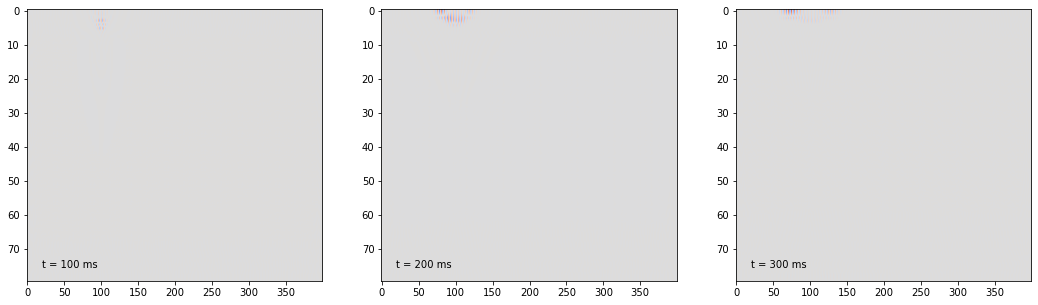

In [13]:
iterations_to_show = [100, 200, 300]

fgr, axs = plt.subplots(1,len(iterations_to_show), figsize = (18,5))
        
for j, ax in enumerate(axs):
    ax.imshow(test_3.RangeInOne(test_3._vx[:, :, iterations_to_show[j]].T), cmap = plt.cm.coolwarm, vmin = -1, vmax = 1, interpolation='quadric', aspect='auto')
    ax.annotate("t = {0} ms".format(iterations_to_show[j]), xy=(0.05, 0.05), xycoords="axes fraction")
plt.show()

In [10]:
print(test_3._vx)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
